# Initialization (FastKAN)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import *
import numpy as np
import matplotlib.pyplot as plt
from pulp import LpProblem, LpVariable, LpMinimize, LpMaximize, LpStatus, LpBinary, lpSum, PULP_CBC_CMD, LpAffineExpression
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import scipy as sc
from torch import autograd
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import sympy as sp
import scipy as sc
import matplotlib.pyplot as plt
import torch
import random
import warnings
from torch import autograd
from tqdm import tqdm
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import r2_score
import optuna
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm
from sklearn.metrics import r2_score
import scipy as sc
import warnings
warnings.filterwarnings("ignore")
from torch import nn
import torch.nn.functional as F
import math
from typing import *
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")
import time
import torch
import numpy as np
from typing import List, Dict, Any, Tuple, Optional, Union




class SplineLinear(nn.Linear):
    def __init__(self, in_features: int, out_features: int, init_scale: float = 0.1, **kw) -> None:
        self.init_scale = init_scale
        super().__init__(in_features, out_features, bias=False, **kw)

    def reset_parameters(self) -> None:
        nn.init.trunc_normal_(self.weight, mean=0, std=self.init_scale)

class RadialBasisFunction(nn.Module):
    def __init__(
        self,
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 8,
        denominator: float = None,  # larger denominators lead to smoother basis
    ):
        super().__init__()
        self.grid_min = grid_min
        self.grid_max = grid_max
        self.num_grids = num_grids
        grid = torch.linspace(grid_min, grid_max, num_grids)
        self.grid = torch.nn.Parameter(grid, requires_grad=False)
        self.denominator = denominator or (grid_max - grid_min) / (num_grids - 1)

    def forward(self, x):
        return torch.exp(-((x[..., None] - self.grid) / self.denominator) ** 2)

class FastKANLayer(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 8,
        use_base_update: bool = True,
        use_layernorm: bool = True,
        base_activation = F.silu,
        spline_weight_init_scale: float = 0.1,
    ) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.layernorm = None
        if use_layernorm:
            assert input_dim > 1, "Do not use layernorms on 1D inputs. Set `use_layernorm=False`."
            self.layernorm = nn.LayerNorm(input_dim)
        self.rbf = RadialBasisFunction(grid_min, grid_max, num_grids)
        self.spline_linear = SplineLinear(input_dim * num_grids, output_dim, spline_weight_init_scale)
        self.use_base_update = use_base_update
        if use_base_update:
            self.base_activation = base_activation
            self.base_linear = nn.Linear(input_dim, output_dim)

    def forward(self, x, use_layernorm=True):
        if self.layernorm is not None and use_layernorm:
            spline_basis = self.rbf(self.layernorm(x))
        else:
            spline_basis = self.rbf(x)
        ret = self.spline_linear(spline_basis.view(*spline_basis.shape[:-2], -1))
        if self.use_base_update:
            base = self.base_linear(self.base_activation(x))
            ret = ret + base
        return ret

    def plot_curve(
        self,
        input_index: int,
        output_index: int,
        num_pts: int = 1000,
        num_extrapolate_bins: int = 2
    ):
        '''this function returns the learned curves in a FastKANLayer.
        input_index: the selected index of the input, in [0, input_dim) .
        output_index: the selected index of the output, in [0, output_dim) .
        num_pts: num of points sampled for the curve.
        num_extrapolate_bins (N_e): num of bins extrapolating from the given grids. The curve 
            will be calculate in the range of [grid_min - h * N_e, grid_max + h * N_e].
        '''
        ng = self.rbf.num_grids
        h = self.rbf.denominator
        assert input_index < self.input_dim
        assert output_index < self.output_dim
        w = self.spline_linear.weight[
            output_index, input_index * ng : (input_index + 1) * ng
        ]   # num_grids,
        x = torch.linspace(
            self.rbf.grid_min - num_extrapolate_bins * h,
            self.rbf.grid_max + num_extrapolate_bins * h,
            num_pts
        )   # num_pts, num_grids
        with torch.no_grad():
            y = (w * self.rbf(x.to(w.dtype))).sum(-1)
        return x, y


class FastKAN(nn.Module):
    def __init__(
        self,
        layers_hidden: List[int],
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 8,
        use_base_update: bool = True,
        use_layernorm: bool = True,  # Added this parameter
        base_activation = F.silu,
        spline_weight_init_scale: float = 0.1,
    ) -> None:
        super().__init__()
        self.use_layernorm = use_layernorm  # Store the parameter
        self.layers = nn.ModuleList([
            FastKANLayer(
                in_dim, out_dim,
                grid_min=grid_min,
                grid_max=grid_max,
                num_grids=num_grids,
                use_base_update=use_base_update,
                use_layernorm=use_layernorm,  # Pass it to each layer
                base_activation=base_activation,
                spline_weight_init_scale=spline_weight_init_scale,
            ) for in_dim, out_dim in zip(layers_hidden[:-1], layers_hidden[1:])
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x, use_layernorm=self.use_layernorm)  # Use the stored parameter here
        return x


class AttentionWithFastKANTransform(nn.Module):
    
    def __init__(
        self,
        q_dim: int,
        k_dim: int,
        v_dim: int,
        head_dim: int,
        num_heads: int,
        gating: bool = True,
        use_layernorm: bool = True,  # Added this parameter
    ):
        super(AttentionWithFastKANTransform, self).__init__()

        self.num_heads = num_heads
        total_dim = head_dim * self.num_heads
        self.gating = gating
        self.use_layernorm = use_layernorm  # Store the parameter
        self.linear_q = FastKANLayer(q_dim, total_dim, use_layernorm=use_layernorm)
        self.linear_k = FastKANLayer(k_dim, total_dim, use_layernorm=use_layernorm)
        self.linear_v = FastKANLayer(v_dim, total_dim, use_layernorm=use_layernorm)
        self.linear_o = FastKANLayer(total_dim, q_dim, use_layernorm=use_layernorm)
        self.linear_g = None
        if self.gating:
            self.linear_g = FastKANLayer(q_dim, total_dim, use_layernorm=use_layernorm)
        # precompute the 1/sqrt(head_dim)
        self.norm = head_dim**-0.5

    def forward(
        self,
        q: torch.Tensor,
        k: torch.Tensor,
        v: torch.Tensor,
        bias: torch.Tensor = None,      # additive attention bias
    ) -> torch.Tensor:         

        wq = self.linear_q(q, use_layernorm=self.use_layernorm).view(*q.shape[:-1], 1, self.num_heads, -1) * self.norm     # *q1hc
        wk = self.linear_k(k, use_layernorm=self.use_layernorm).view(*k.shape[:-2], 1, k.shape[-2], self.num_heads, -1)    # *1khc
        att = (wq * wk).sum(-1).softmax(-2)     # *qkh
        del wq, wk
        if bias is not None:
            att = att + bias[..., None]

        wv = self.linear_v(v, use_layernorm=self.use_layernorm).view(*v.shape[:-2],1, v.shape[-2], self.num_heads, -1)     # *1khc
        o = (att[..., None] * wv).sum(-3)        # *qhc
        del att, wv

        o = o.view(*o.shape[:-2], -1)           # *q(hc)

        if self.linear_g is not None:
            # gating, use raw query input
            g = self.linear_g(q, use_layernorm=self.use_layernorm)
            o = torch.sigmoid(g) * o

        # merge heads
        o = self.linear_o(o, use_layernorm=self.use_layernorm)
        return o

# Training

In [2]:
def train_mnist():
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    )
    trainset = torchvision.datasets.MNIST(
        root="./data_mnist", train=True, download=True, transform=transform
    )
    valset = torchvision.datasets.MNIST(
        root="./data_mnist", train=False, download=True, transform=transform
    )
    trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
    valloader = DataLoader(valset, batch_size=64, shuffle=False)

    # Define model
    #model = FastKAN([28 * 28, 64, 10])
    model = FastKAN([28 * 28, 16, 10], use_base_update=False, use_layernorm=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # Define optimizer
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    # Define learning rate scheduler
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

    # Define loss
    criterion = nn.CrossEntropyLoss()
    for epoch in range(1):
        # Train
        model.train()
        with tqdm(trainloader) as pbar:
            for i, (images, labels) in enumerate(pbar):
                images = images.view(-1, 28 * 28).to(device)
                optimizer.zero_grad()
                output = model(images)
                loss = criterion(output, labels.to(device))
                loss.backward()
                optimizer.step()
                accuracy = (output.argmax(dim=1) == labels.to(device)).float().mean()
                pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])

        # Validation
        model.eval()
        val_loss = 0
        val_accuracy = 0
        with torch.no_grad():
            for images, labels in valloader:
                images = images.view(-1, 28 * 28).to(device)
                output = model(images)
                val_loss += criterion(output, labels.to(device)).item()
                val_accuracy += (
                    (output.argmax(dim=1) == labels.to(device)).float().mean().item()
                )
        val_loss /= len(valloader)
        val_accuracy /= len(valloader)

        # Update learning rate
        scheduler.step()

        print(
            f"Epoch {epoch + 1}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}"
        )
    return model

model_mnist = train_mnist()

100%|██████████| 938/938 [00:05<00:00, 169.09it/s, accuracy=0.688, loss=1.35, lr=0.001]


Epoch 1, Val Loss: 1.2521940743087963, Val Accuracy: 0.6747611464968153


In [3]:
def train_cifar10():
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    )
    trainset = torchvision.datasets.CIFAR10(
        root="./data_cifar10", train=True, download=True, transform=transform
    )
    valset = torchvision.datasets.CIFAR10(
        root="./data_cifar10", train=False, download=True, transform=transform
    )
    trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
    valloader = DataLoader(valset, batch_size=64, shuffle=False)

    # Define model
    model = FastKAN([3072, 32, 10])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # Define optimizer
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    # Define learning rate scheduler
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

    # Define loss
    criterion = nn.CrossEntropyLoss()
    for epoch in range(20):
        # Train
        model.train()
        with tqdm(trainloader) as pbar:
            for i, (images, labels) in enumerate(pbar):
                images = images.view(-1, 3072).to(device)
                optimizer.zero_grad()
                output = model(images)
                loss = criterion(output, labels.to(device))
                loss.backward()
                optimizer.step()
                accuracy = (output.argmax(dim=1) == labels.to(device)).float().mean()
                pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])

        # Validation
        model.eval()
        val_loss = 0
        val_accuracy = 0
        with torch.no_grad():
            for images, labels in valloader:
                images = images.view(-1, 3072).to(device)
                output = model(images)
                val_loss += criterion(output, labels.to(device)).item()
                val_accuracy += (
                    (output.argmax(dim=1) == labels.to(device)).float().mean().item()
                )
        val_loss /= len(valloader)
        val_accuracy /= len(valloader)

        # Update learning rate
        scheduler.step()

        print(
            f"Epoch {epoch + 1}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}"
        )
    return model

model_cifar10 = train_cifar10()
#0.4635748407643312

100%|██████████| 782/782 [00:13<00:00, 58.36it/s, accuracy=0.562, loss=1.52, lr=0.001]


Epoch 1, Val Loss: 1.553666372208079, Val Accuracy: 0.4538216560509554


100%|██████████| 782/782 [00:13<00:00, 57.87it/s, accuracy=0.625, loss=1.21, lr=0.0008]


Epoch 2, Val Loss: 1.4976587637214904, Val Accuracy: 0.47740843949044587


100%|██████████| 782/782 [00:13<00:00, 58.33it/s, accuracy=0.75, loss=1.3, lr=0.00064]   


Epoch 3, Val Loss: 1.4455606929815499, Val Accuracy: 0.48915207006369427


 64%|██████▍   | 503/782 [00:08<00:04, 56.17it/s, accuracy=0.562, loss=1.28, lr=0.000512] 


KeyboardInterrupt: 

Number of steps: 5
Dataset shape: torch.Size([150, 8])
Train dataset shape: torch.Size([125, 8]), Test dataset shape: torch.Size([25, 8])
Jacobian shape: torch.Size([125, 3, 1])
Training model...
Iteration 0, Loss: 1.9071193933486938
Iteration 1, Loss: 0.8277780413627625
Iteration 2, Loss: 0.6639266014099121
Iteration 3, Loss: 0.7175949811935425
Iteration 4, Loss: 0.5712574124336243

Test set predictions:


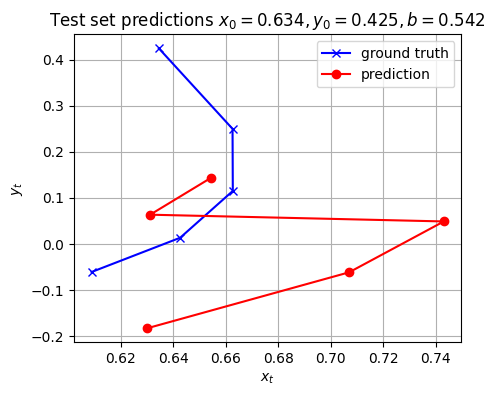

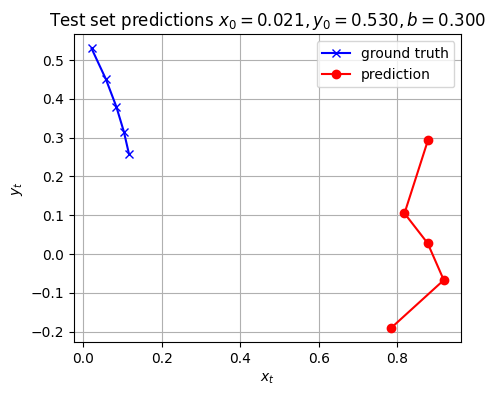

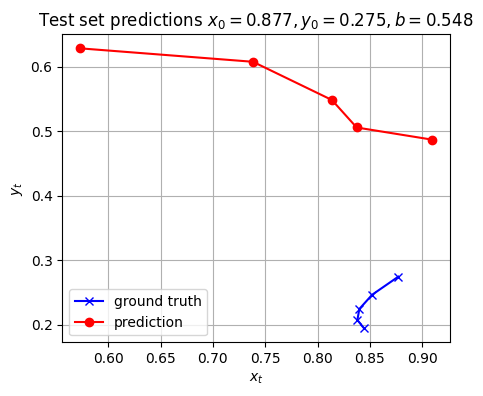

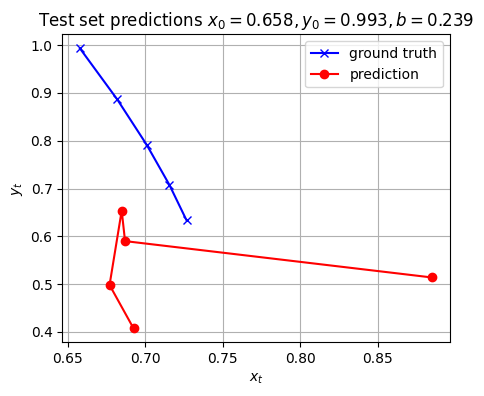

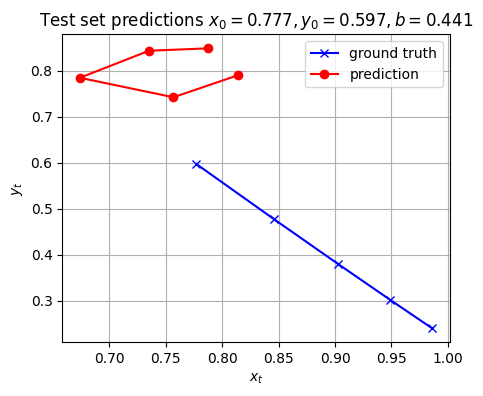


Train set predictions:


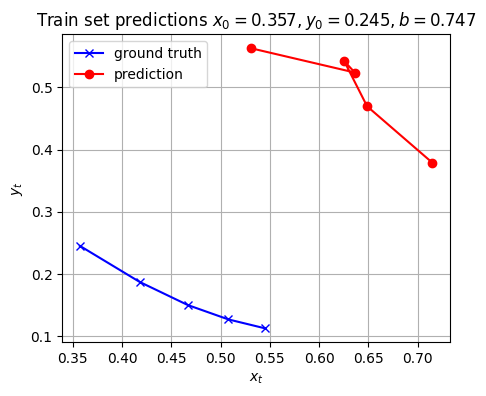

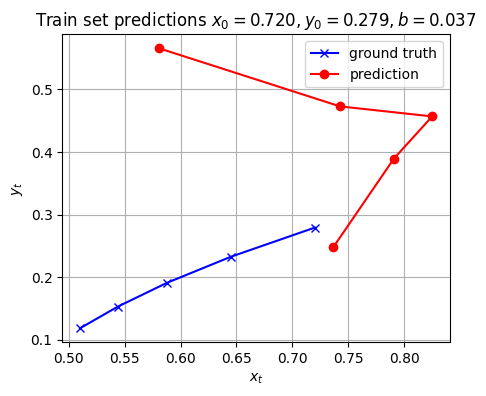

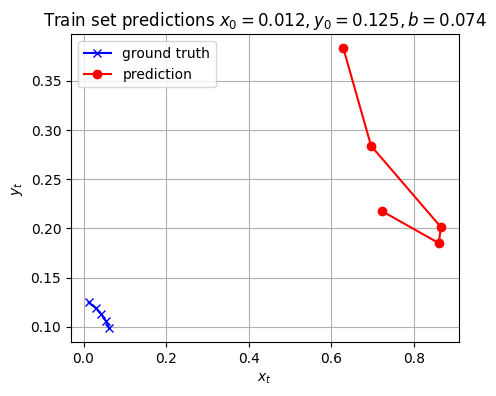

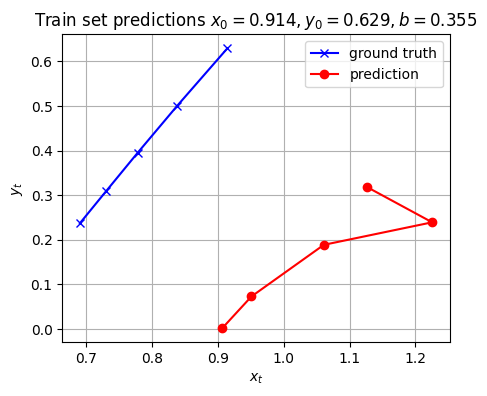

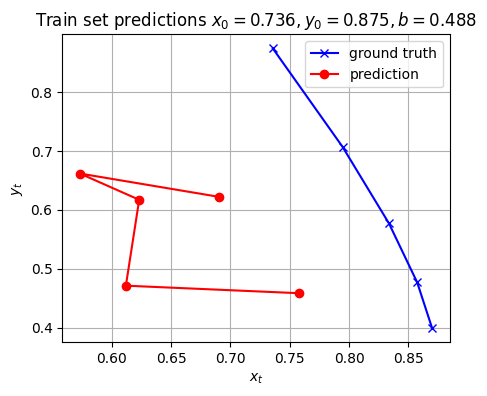


Evaluating test set performance:
Overall R2-Score (test_dataset): -0.9650984406471252

Evaluating train set performance:
Overall R2-Score (train_dataset): -0.1572502851486206


In [ ]:
#Scenario 1: Dampened Pendulum

# Implementation of custom LBFGS optimizer to match the one used in file 2
class LBFGS(optim.LBFGS):
    def __init__(self, params, lr=1, history_size=10, **kwargs):
        super().__init__(params, lr=lr, history_size=history_size, **kwargs)

# Now let's implement the ODE learning code

# Set up device
device = "cpu"

# Define dataset parameters
s_size = 30

# Sample input data
x_sample = torch.tensor(np.random.uniform(0, 1, size=s_size), dtype=torch.float32, device=device)
y_sample = torch.tensor(np.random.uniform(0, 1, size=s_size), dtype=torch.float32, device=device)
z_sample = torch.tensor(np.random.uniform(0, 1, size=s_size), dtype=torch.float32, device=device)
a_sample = torch.tensor(np.random.uniform(0, 1, size=s_size), dtype=torch.float32, device=device)
b_sample = torch.tensor(np.random.uniform(0, 1, size=s_size), dtype=torch.float32, device=device)
c_sample = torch.tensor(np.random.uniform(0, 1, size=s_size), dtype=torch.float32, device=device)
d_sample = torch.tensor(np.random.uniform(0, 1, size=s_size), dtype=torch.float32, device=device)

# Define time steps
duration = 1
time_interval = 0.2
steps = int(duration / time_interval)
print(f"Number of steps: {steps}")
t_eval = torch.linspace(0, duration, steps=int(steps))

# Create dataset
dataset = torch.stack([x_sample, y_sample, z_sample, a_sample, b_sample, c_sample, d_sample], dim=1).to(device)
dataset = dataset.repeat_interleave(steps, dim=0)
t_eval_set = t_eval.T.repeat(s_size).view(-1, 1).to(device)

dataset = torch.cat([t_eval_set, dataset], dim=1)
dataset.requires_grad = True
print(f"Dataset shape: {dataset.shape}")

# Split into train and test
test_size = 5
test_dataset = dataset[(s_size-test_size)*steps:]
dataset = dataset[:(s_size-test_size)*steps]
print(f"Train dataset shape: {dataset.shape}, Test dataset shape: {test_dataset.shape}")

# Define the Jacobian computation function
def compute_jacobian(model, x):
    def ret_sum(x):
        return model(x)
    jacb = autograd.functional.jacobian(ret_sum, x, create_graph=True)  # Compute the jacobian
    jacb = jacb[:, :, :, 0]  # only get the d/dt for the output vars
    jacb = jacb.sum(dim=-1).unsqueeze(-1)  # sum across the final axis and reshape
    return jacb

# Define the ODE computation function
def compute_ode(y_pred, x):
    def ode(init_cond, a, b, c, d):
        return -a*init_cond[:, 0] + b*init_cond[:, 1] + c*init_cond[:, 2], \
               (d - a)*init_cond[:, 0] - 2*b*init_cond[:, 1], \
               d*init_cond[:, 0] + b*init_cond[:, 1] - c*init_cond[:, 2]

    grad = ode(y_pred, x[:, 4], x[:, 5], x[:, 6], x[:, 7])  # Compute the ddt through the ODE
    grad = torch.tensor([[dxdt, dydt, dzdt] for dxdt, dydt, dzdt in zip(grad[0], grad[1], grad[2])], 
                        device=device).unsqueeze(-1)  # reshape tensor
    return grad

# Compute forward integrals using scipy
def compute_forward_integrals(dataset, duration, t_eval):
    def system_cont(t, x, a, b, c, d):
        dxdt = [-a*x[0] + b*x[1] + c*x[2], 
                (d - a)*x[0] - 2*b*x[1], 
                d*x[0] + b*x[1] - c*x[2]]
        return dxdt 
    
    sol_set = []
    for init_cond in dataset.detach().cpu().numpy():
        t, x0, y0, z0, a, b, c, d = init_cond[0], init_cond[1], init_cond[2], init_cond[3], \
                                    init_cond[4], init_cond[5], init_cond[6], init_cond[7]
        sol = sc.integrate.solve_ivp(system_cont, [0, duration], (x0, y0, z0), 
                                     args=(a, b, c, d), t_eval=t_eval)
        sol_set.extend(np.array(sol.y.T))
    
    sol_set = torch.tensor(np.array(sol_set), dtype=torch.float32, device=device)
    return sol_set

# Define the ODE residual loss function
def ode_residuals(model, coords, steps, duration, t_eval, alpha=1.0, beta=1.0, gamma=1.0):
    coords = coords.clone().detach().requires_grad_(True)

    # Compute integral points through time
    y_pred = model(coords)  # shape: nsamplex3x1
    y_gt = compute_forward_integrals(coords[::steps], duration, t_eval)  # shape: nsamplex3x1

    # Compute gradients
    kan_autograd = compute_jacobian(model, coords)  # shape: nsamplex3x1
    kan_ode_grad = compute_ode(y_pred, coords)  # shape: nsamplex3x1

    # Compute initial points in space
    init_kan_grad = y_pred[::steps]  # shape: s_sizex3
    init_ode_grad = coords[::steps][:, 1:4]  # shape: s_sizex3

    # Compute loss components
    dyn_loss = torch.mean((kan_autograd - kan_ode_grad)**2)
    integral_loss = torch.mean((y_pred - y_gt)**2)
    init_loss = torch.mean((init_kan_grad - init_ode_grad)**2)
    
    # Combine losses
    batch_loss = alpha*dyn_loss + beta*integral_loss + gamma*init_loss
    
    return batch_loss

# Create FastKAN model 
# The width corresponds to [input_dim, hidden_dim, output_dim]
model_scenario1 = FastKAN(
    layers_hidden=[8, 24, 3],  # 8 inputs, 24 hidden units, 3 outputs
    grid_min=-2.0,
    grid_max=2.0,
    num_grids=15,  # Matching the 'grid=15' parameter
    use_base_update=False,
    use_layernorm=False
)
model_scenario1.to(device)

# Verify Jacobian shape (for debugging)
print(f"Jacobian shape: {compute_jacobian(model_scenario1, dataset).shape}")

# Training function
def train(model, iterations=2):
    # Using Adam instead of LBFGS for simplicity in this implementation
    # You could also use optim.LBFGS directly
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    for i in range(iterations):
        optimizer.zero_grad()
        loss = ode_residuals(model, dataset, steps, duration, t_eval)
        loss.backward()
        optimizer.step()
        
        if i % 1 == 0:
            print(f"Iteration {i}, Loss: {loss.item()}")
    
    return model

# Function to run ODE system for visualization
def system_eq_dis(cond_input, t_eval, time):
    def system_cont(t, x, a, b, c, d):
        dxdt = [-a*x[0] + b*x[1] + c*x[2], 
                (d - a)*x[0] - 2*b*x[1], 
                d*x[0] + b*x[1] - c*x[2]]
        return dxdt
    
    x0, y0, z0, a, b, c, d = cond_input
    sol = sc.integrate.solve_ivp(system_cont, [0, time], (x0, y0, z0), 
                                args=(a, b, c, d), t_eval=t_eval)
    return sol.y.T, sol.t.T

# Train the model
print("Training model...")
model_scenario1 = train(model_scenario1, iterations=5)  # Increased iterations for better convergence

# Visualize test set results
print("\nTest set predictions:")
for k in range(0, 5):
    plt.figure(figsize=[5,4])
    sol, t_h = system_eq_dis(test_dataset[int(steps)*k, 1:].detach().cpu(), t_eval, duration)
    plt.plot(sol[:, 0], sol[:, 1], c='b', marker='x', label='ground truth')
    
    y_pred = model_scenario1(test_dataset[int(steps)*k:int(steps)*(k+1)]).detach().cpu().numpy()
    plt.plot(y_pred[:, 0], y_pred[:, 1], c='r', marker='o', label='prediction')
    
    plt.grid()
    x0, y0, z0, a, b, c, d = test_dataset[int(steps)*k, 1:].detach().cpu().numpy()
    plt.title(f"Test set predictions $x_0={x0:.3f}, y_0={y0:.3f}, b={b:.3f}$")
    plt.xlabel(r"$x_t$")
    plt.ylabel(r"$y_t$")
    plt.legend()
    plt.show()

# Visualize train set results
print("\nTrain set predictions:")
for k in range(0, 5):
    plt.figure(figsize=[5,4])
    sol, t_h = system_eq_dis(dataset[int(steps)*k, 1:].detach().cpu(), t_eval, duration)
    plt.plot(sol[:, 0], sol[:, 1], c='b', marker='x', label='ground truth')
    
    y_pred = model_scenario1(dataset[int(steps)*k:int(steps)*(k+1)]).detach().cpu().numpy()
    plt.plot(y_pred[:, 0], y_pred[:, 1], c='r', marker='o', label='prediction')
    
    plt.grid()
    x0, y0, z0, a, b, c, d = dataset[int(steps)*k, 1:].detach().cpu().numpy()
    plt.title(f"Train set predictions $x_0={x0:.3f}, y_0={y0:.3f}, b={b:.3f}$")
    plt.xlabel(r"$x_t$")
    plt.ylabel(r"$y_t$")
    plt.legend()
    plt.show()

# Compute error metrics on test set
print("\nEvaluating test set performance:")
sol_map = []
for init_conds in test_dataset[::steps].detach().cpu().numpy():
    sol, _ = system_eq_dis(init_conds[1:], t_eval, duration)
    sol_map.extend(sol)

np.savetxt('groundtruths_test.txt', sol_map, fmt='%f')
pred = model_scenario1(test_dataset).detach().cpu().numpy()
res_score = r2_score(sol_map, pred)
print(f"Overall R2-Score (test_dataset): {res_score}")
np.savetxt('predictions_test.txt', pred, fmt='%f')

# Compute error metrics on train set
print("\nEvaluating train set performance:")
sol_map = []
for init_conds in dataset[::steps].detach().cpu().numpy():
    sol, _ = system_eq_dis(init_conds[1:], t_eval, duration)
    sol_map.extend(sol)

np.savetxt('groundtruths_train.txt', sol_map, fmt='%f')
pred = model_scenario1(dataset).detach().cpu().numpy()
res_score = r2_score(sol_map, pred)
print(f"Overall R2-Score (train_dataset): {res_score}")
np.savetxt('predictions_train.txt', pred, fmt='%f')

# Evaluating test set performance:
# Overall R2-Score (test_dataset): 0.36257079243659973

# Evaluating train set performance:
# Overall R2-Score (train_dataset): 0.9957847595214844

In [ ]:
# Scenario 2: Duffing Oscillator 
class LBFGS(torch.optim.LBFGS):
    def __init__(self, params, lr=1, history_size=10, tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32):
        super().__init__(params, lr=lr, history_size=history_size, tolerance_grad=tolerance_grad, 
                         tolerance_change=tolerance_change)
        self.tolerance_ys = tolerance_ys

# The ODE we are trying to learn is the Van der Pol Oscillator
# Define device
device = "cpu"

# Sample size
s_size = 50

# Create random samples for initial conditions and parameters
x_sample = np.random.uniform(-1, 1, size=s_size)
y_sample = np.random.uniform(-1, 1, size=s_size)
d_sample = np.random.uniform(0.1, 0.5, size=s_size)
x_sample = torch.tensor(x_sample, dtype=torch.float32, device=device)
y_sample = torch.tensor(y_sample, dtype=torch.float32, device=device)
d_sample = torch.tensor(d_sample, dtype=torch.float32, device=device)

# Time parameters
duration = 1
time_interval = 0.2
steps = int(duration / time_interval)
print(f"Steps: {steps}")
t_eval = torch.linspace(0, duration, steps=steps)

# Create the dataset for the model
dataset = torch.stack([x_sample, y_sample, d_sample], dim=1).to(device)
dataset = dataset.repeat_interleave(steps, dim=0)
t_eval_set = t_eval.T.repeat(s_size).view(-1, 1).to(device)

dataset = torch.cat([t_eval_set, dataset], dim=1)
dataset.requires_grad = True
print(f"Dataset shape: {dataset.shape}")

# Create test and train datasets
test_size = 5
test_dataset = dataset[(s_size-test_size)*steps:]
dataset = dataset[:(s_size-test_size)*steps]
print(f"Train dataset shape: {dataset.shape}, Test dataset shape: {test_dataset.shape}")

# Function to compute the Jacobian (time derivative)
def compute_jacobian(model, x):
    def ret_sum(x):
        return model(x)
    jacb = autograd.functional.jacobian(ret_sum, x, create_graph=True)  # Compute the jacobian across all input variables and output vars
    jacb = jacb[:, :, :, 0]  # only get the d/dt for the output vars
    jacb = jacb.sum(dim=-1).unsqueeze(-1)  # sum across the final axis and reshape to 1 vector
    return jacb

# Function to compute the ODE using the output of the FastKAN
def compute_ode(y_pred, x):
    def ode(init_cond, d):
        return init_cond[:, 1], init_cond[:, 0] - init_cond[:, 0]**3 - d*init_cond[:, 1]

    grad = ode(y_pred, x[:, 3])  # Compute the ddt through the ODE for the output of the model
    grad = torch.tensor([[dxdt, dydt] for dxdt, dydt in zip(grad[0], grad[1])], device=device).unsqueeze(-1)  # reshape tensor to match the jacobian tensors
    return grad

# Function to compute the forward integrals using scipy
def compute_forward_integrals(dataset, duration, t_eval):
    def system_cont(t, x, d):
        dxdt = [x[1], x[0] - x[0]**3 - d*x[1]]
        return dxdt 
    
    sol_set = []
    for init_cond in dataset.detach().cpu().numpy():
        t, x0, y0, d = init_cond[0], init_cond[1], init_cond[2], init_cond[3]
        sol = sc.integrate.solve_ivp(system_cont, [0, duration], (x0, y0), args=(d,), t_eval=t_eval)
        sol_set.extend(np.array(sol.y.T))
    
    sol_set = torch.tensor(np.array(sol_set), dtype=torch.float32, device=device)
    return sol_set

# Define the ODE residuals function (loss function)
def ode_residuals(model, coords, steps, duration, t_eval, alpha=1.0, beta=1.0, gamma=1.0):
    coords = coords.clone().detach().requires_grad_(True)

    # Compute integral points through time
    y_pred = model(coords)  # shape: nsamplex2
    y_gt = compute_forward_integrals(coords[::steps], duration, t_eval.cpu().numpy())  # shape: nsamplex2

    # Compute gradients
    kan_autograd = compute_jacobian(model, coords)  # shape: nsamplex2x1
    kan_ode_grad = compute_ode(y_pred, coords)  # shape: nsamplex2x1

    # Compute initial points in space
    init_kan_grad = y_pred[::steps]  # shape: s_sizex2
    init_ode_grad = coords[::steps][:, 1:3]  # shape: s_sizex2

    # Compute the loss of the dynamics
    dyn_loss = torch.mean((kan_autograd - kan_ode_grad)**2)
    # Compute the loss of the integral points through time
    integral_loss = torch.mean((y_pred - y_gt)**2)
    # Compute the loss of the initial condition
    init_loss = torch.mean((init_kan_grad - init_ode_grad)**2)
    
    batch_loss = alpha*dyn_loss + beta*integral_loss + beta*init_loss

    return batch_loss

# Create the FastKAN model - using similar architecture as in the original KAN implementation
model_scenario2 = FastKAN(layers_hidden=[4, 15, 2], grid_min=-2., grid_max=2., num_grids=15, use_base_update = False, use_layernorm=False)

# Train the model
def train(model):
    optimizer = LBFGS(model.parameters(), lr=1, history_size=10, tolerance_grad=1e-32, 
                     tolerance_change=1e-32, tolerance_ys=1e-32)
    
    iter_ = 1
    for i in range(iter_):
        def closure():
            optimizer.zero_grad()
            loss = ode_residuals(model, dataset, steps, duration, t_eval, alpha=0.2, beta=0.6, gamma=0.2)
            loss.backward()
            return loss
        optimizer.step(closure)
        if i % 1 == 0:
            current_loss = closure().item()
            print(f"Iteration {i}, Loss: {current_loss}")

print("Starting training...")
train(model_scenario2)

# Function to create solution trajectories for visualization
def system_eq_dis(cond_input, t_eval, time):
    def system_cont(t, x, d):
        dxdt = [x[1], x[0] - x[0]**3 - d*x[1]]
        return dxdt
    x0, y0, d = cond_input
    sol = sc.integrate.solve_ivp(system_cont, [0, time], (x0, y0), args=(d,), t_eval=t_eval)
    return sol.y.T, sol.t.T

# Visualize the performance on test set
print("\nTest set predictions:")
for k in range(0, 2):
    plt.figure(figsize=[5, 4])
    sol, t_h = system_eq_dis(test_dataset[int(steps)*k, 1:4].detach().cpu(), t_eval.numpy(), duration)
    plt.plot(sol[:, 0], sol[:, 1], c='b', marker='x', label='gt')
    y_pred = model_scenario2(test_dataset[int(steps)*k:int(steps)*(k+1)]).detach().cpu().numpy()
    plt.plot(y_pred[:, 0], y_pred[:, 1], c='r', marker='o', label='pred')
    plt.grid()
    x0, y0, d = test_dataset[int(steps)*k, 1:4].detach().numpy()
    plt.title(f"Test set predictions $x_0={x0:.3f}, y_0={y0:.3f}, d={d:.3f}$")
    plt.xlabel(r"$x_t$")
    plt.ylabel(r"$y_t$")
    plt.legend()
    plt.show()  # Display in notebook instead of saving

# Visualize the performance on train set
print("\nTrain set predictions:")
for k in range(0, 2):
    plt.figure(figsize=[5, 4])
    sol, t_h = system_eq_dis(dataset[int(steps)*k, 1:4].detach().cpu(), t_eval.numpy(), duration)
    plt.plot(sol[:, 0], sol[:, 1], c='b', marker='x', label='gt')
    y_pred = model_scenario2(dataset[int(steps)*k:int(steps)*(k+1)]).detach().cpu().numpy()
    plt.plot(y_pred[:, 0], y_pred[:, 1], c='r', marker='o', label='pred')
    x0, y0, d = dataset[int(steps)*k, 1:4].detach().numpy()
    plt.title(f"Train set predictions $x_0={x0:.3f}, y_0={y0:.3f}, d={d:.3f}$")
    plt.xlabel(r"$x_t$")
    plt.ylabel(r"$y_t$")
    plt.grid()
    plt.legend()
    plt.show()  # Display in notebook instead of saving

# Compute error metrics on test set
print("\nComputing error metrics on test set:")
sol_map = []
for init_conds in test_dataset[::steps].detach().cpu().numpy():
    sol, _ = system_eq_dis(init_conds[1:], t_eval.numpy(), duration)
    sol_map.extend(sol)

np.savetxt('groundtruths_test_fastkan.txt', sol_map, fmt='%f')
pred = model_scenario2(test_dataset).detach().numpy()
res_score = r2_score(sol_map, pred)
print(f"Overall R2-Score (test dataset): {res_score}")
np.savetxt('predictions_test_fastkan.txt', pred, fmt='%f')

# Compute error metrics on train set
print("\nComputing error metrics on train set:")
sol_map = []
for init_conds in dataset[::steps].detach().cpu().numpy():
    sol, _ = system_eq_dis(init_conds[1:], t_eval.numpy(), duration)
    sol_map.extend(sol)

np.savetxt('groundtruths_train_fastkan.txt', sol_map, fmt='%f')
pred = model_scenario2(dataset).detach().numpy()
res_score = r2_score(sol_map, pred)
print(f"Overall R2-Score (train dataset): {res_score}")
np.savetxt('predictions_train_fastkan.txt', pred, fmt='%f')

# Good

Steps: 5
Dataset shape: torch.Size([250, 4])
Train dataset shape: torch.Size([225, 4]), Test dataset shape: torch.Size([25, 4])
Starting training...


KeyboardInterrupt: 

Using device: cpu
Number of time steps: 5
Dataset shape: torch.Size([150, 7])
Train dataset shape: torch.Size([125, 7]), Test dataset shape: torch.Size([25, 7])
Starting training...
Epoch 1/5, Loss: 0.00674916
Epoch 2/5, Loss: 0.00149946
Epoch 3/5, Loss: 0.00052525
Epoch 4/5, Loss: 0.00021817
Epoch 5/5, Loss: 0.00011114

Evaluating on test set...
Test R2-Score: 0.918760

Evaluating on train set...
Train R2-Score: 0.999844

Visualizing test set predictions...


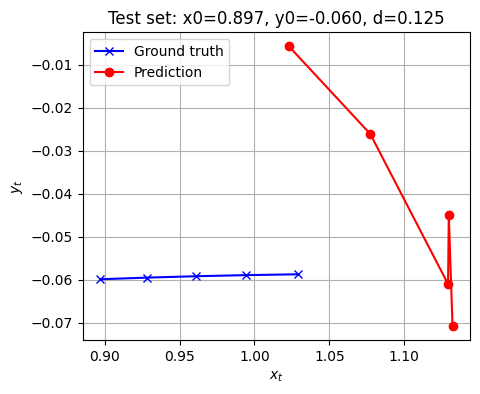

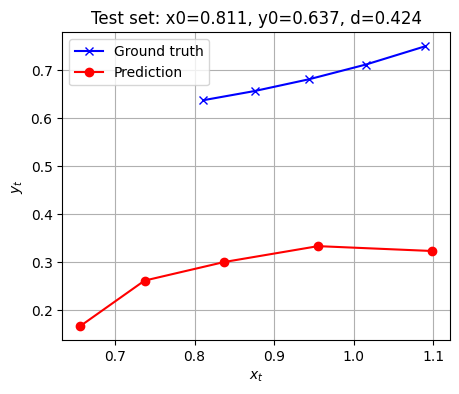

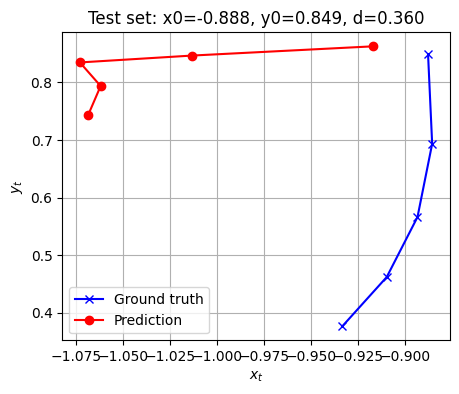

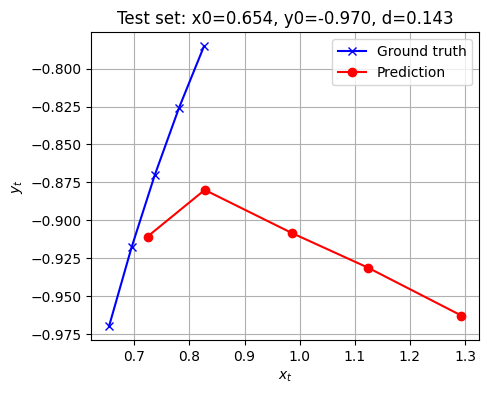

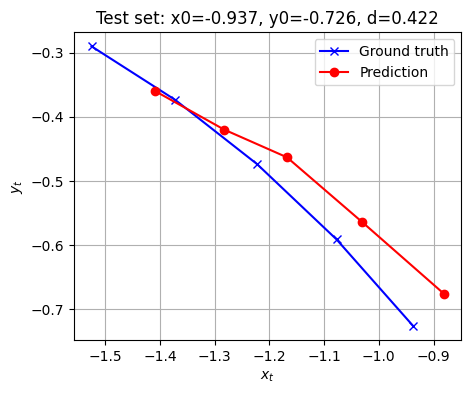


Visualizing train set predictions...


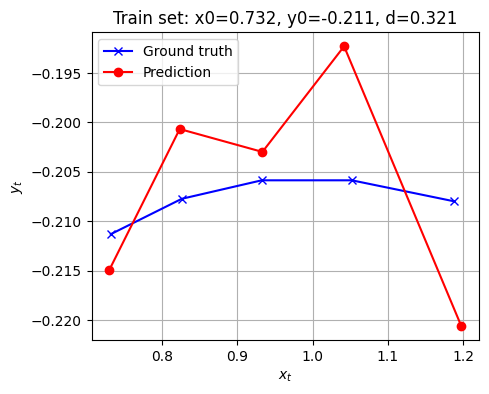

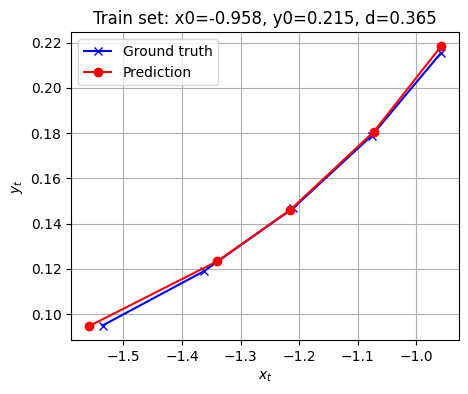

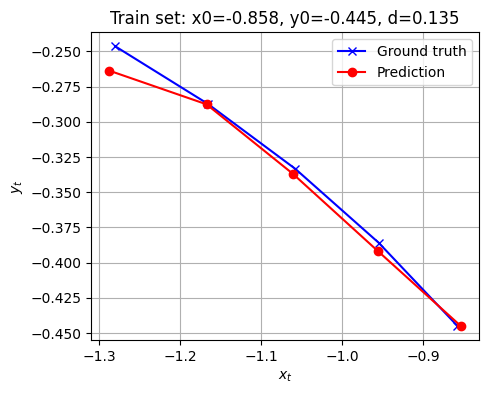

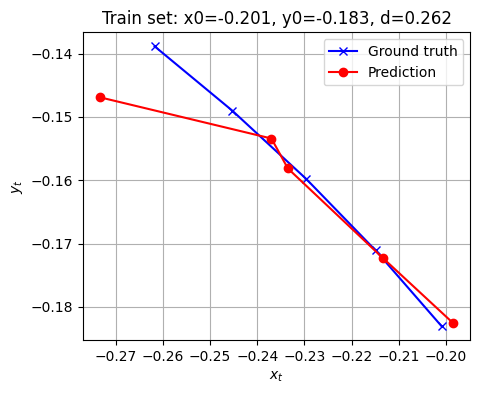

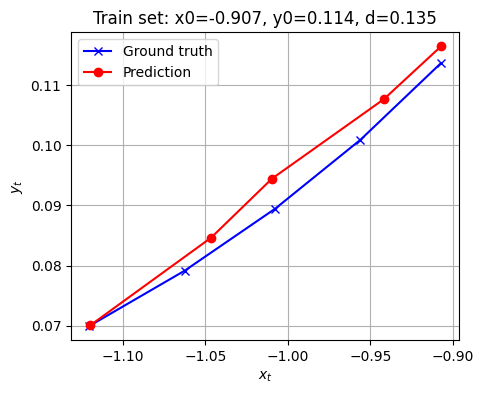

In [ ]:
#Scenario 3: PiKAN-Lotka-Volterra.ipynb


def compute_jacobian(model, x):
    """Returns the d/dt jacobian of the values computed by FastKAN"""
    def ret_sum(x):
        return model(x)
    
    jacb = autograd.functional.jacobian(ret_sum, x, create_graph=True)  # Compute the jacobian
    jacb = jacb[:, :, :, 0]  # only get the d/dt for the output vars
    jacb = jacb.sum(dim=-1).unsqueeze(-1)  # reshape to match dimension
    return jacb

def compute_ode(y_pred, x):
    """Computes the ODE using the output of the FastKAN"""
    def ode(init_cond, a, b, c, d):
        return (
            init_cond[:, 0]*a - init_cond[:, 0]*init_cond[:, 1]*b, 
            -init_cond[:, 1]*c + init_cond[:, 0]*init_cond[:, 1]*d
        )

    # Compute the ddt through the ODE for the output of the KAN
    grad = ode(y_pred, x[:, 3], x[:, 4], x[:, 5], x[:, 6])
    # Reshape tensor to match the jacobian tensors
    grad = torch.stack([grad[0], grad[1]], dim=1).unsqueeze(-1)
    return grad

def compute_forward_integrals(dataset, duration, t_eval):
    """Compute the forward derivative in time for each value in initial condition set"""
    def system_cont(t, x, a, b, c, d):
        dxdt = [x[0]*a - x[0]*x[1]*b, -x[1]*c + x[0]*x[1]*d]
        return dxdt 
    
    sol_set = []
    for init_cond in dataset.detach().cpu().numpy():
        t, x0, y0, a, b, c, d = init_cond[0], init_cond[1], init_cond[2], init_cond[3], init_cond[4], init_cond[5], init_cond[6]
        sol = sc.integrate.solve_ivp(system_cont, [0, duration], (x0, y0), args=(a, b, c, d), t_eval=t_eval)
        sol_set.extend(np.array(sol.y.T))
    
    sol_set = torch.tensor(np.array(sol_set), dtype=torch.float32, device=dataset.device)
    return sol_set

def ode_residuals(model, coords, steps, duration, t_eval, alpha=1.0, beta=1.0, gamma=1.0):
    """Calculate the loss for the ODE model"""
    coords = coords.clone().detach().requires_grad_(True)

    # Compute integral points through time
    y_pred = model(coords)  # shape: nsamplex2x1
    y_gt = compute_forward_integrals(coords[::steps], duration, t_eval)  # shape: nsamplex2

    # Compute gradients
    kan_autograd = compute_jacobian(model, coords)  # shape: nsamplex2x1
    kan_ode_grad = compute_ode(y_pred, coords)  # shape: nsamplex2x1

    # Compute initial points in space
    init_kan_grad = y_pred[::steps]  # shape: s_sizex2
    init_ode_grad = torch.stack([coords[::steps][:, 1], coords[::steps][:, 2]], dim=1)  # shape: s_sizex2

    # Compute the loss of the dynamics
    dyn_loss = torch.mean((kan_autograd - kan_ode_grad)**2)
    # Compute the loss of the integral points through time
    integral_loss = torch.mean((y_pred - y_gt)**2)
    # Compute the loss of the initial condition
    init_loss = torch.mean((init_kan_grad - init_ode_grad)**2)
    
    batch_loss = alpha*dyn_loss + beta*integral_loss + gamma*init_loss

    return batch_loss

def system_eq_dis(cond_input, t_eval, duration):
    """Compute ODE solution for a given initial condition"""
    def system_cont(t, x, a, b, c, d):
        dxdt = [x[0]*a - x[0]*x[1]*b, -x[1]*c + x[0]*x[1]*d]
        return dxdt
        
    x0, y0, a, b, c, d = cond_input
    sol = sc.integrate.solve_ivp(system_cont, [0, duration], (x0, y0), args=(a, b, c, d), t_eval=t_eval)
    return sol.y.T, sol.t.T

def train_fastkan_ode():
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Sample dataset
    s_size = 30
    x_sample = torch.tensor(np.random.uniform(-1, 1, size=s_size), dtype=torch.float32, device=device)
    y_sample = torch.tensor(np.random.uniform(-1, 1, size=s_size), dtype=torch.float32, device=device)
    a_sample = torch.tensor(np.random.uniform(0.1, 0.5, size=s_size), dtype=torch.float32, device=device)
    b_sample = torch.tensor(np.random.uniform(0.1, 0.5, size=s_size), dtype=torch.float32, device=device)
    c_sample = torch.tensor(np.random.uniform(0.1, 0.5, size=s_size), dtype=torch.float32, device=device)
    d_sample = torch.tensor(np.random.uniform(0.1, 0.5, size=s_size), dtype=torch.float32, device=device)

    # Time span
    duration = 1
    time_interval = 0.2
    steps = int(duration / time_interval)
    t_eval = torch.linspace(0, duration, steps=int(steps))
    print(f"Number of time steps: {steps}")

    # Create the dataset
    dataset = torch.stack([x_sample, y_sample, a_sample, b_sample, c_sample, d_sample], dim=1).to(device)
    dataset = dataset.repeat_interleave(steps, dim=0)
    t_eval_set = t_eval.T.repeat(s_size).view(-1, 1).to(device)

    dataset = torch.cat([t_eval_set, dataset], dim=1)
    dataset.requires_grad = True
    print(f"Dataset shape: {dataset.shape}")

    # Split into train/test
    test_size = 5
    test_dataset = dataset[(s_size-test_size)*steps:]
    train_dataset = dataset[:(s_size-test_size)*steps]
    print(f"Train dataset shape: {train_dataset.shape}, Test dataset shape: {test_dataset.shape}")

    # Create the FastKAN model
    model = FastKAN(
        layers_hidden=[7, 24, 2],  # 7 inputs, 24 hidden, 2 outputs (like in file 2)
        grid_min=-2.0,
        grid_max=2.0,
        num_grids=15,  # Using 15 grids like in file 2
        use_base_update=False,
        use_layernorm=False
    ).to(device)
    
    # Train the model
    optimizer = optim.LBFGS(model.parameters(), 
                           lr=1, 
                           max_iter=20,
                           max_eval=25, 
                           tolerance_grad=1e-7,
                           tolerance_change=1e-9,
                           history_size=10)

    print("Starting training...")
    iter_ = 5
    for epoch in range(iter_):
        def closure():
            optimizer.zero_grad()
            loss = ode_residuals(model, train_dataset, steps, duration, t_eval.numpy(), 
                               alpha=0.2, beta=0.6, gamma=0.2)
            loss.backward()
            return loss
        
        optimizer.step(closure)
        current_loss = closure().item()
        print(f"Epoch {epoch+1}/{iter_}, Loss: {current_loss:.8f}")

    # Evaluate on test set
    print("\nEvaluating on test set...")
    # Calculate ground truth for test set
    sol_map_test = []
    for init_conds in test_dataset[::steps].detach().cpu().numpy():
        sol, _ = system_eq_dis(init_conds[1:], t_eval.numpy(), duration)
        sol_map_test.extend(sol)

    # Get predictions
    with torch.no_grad():
        pred_test = model(test_dataset).detach().cpu().numpy()
    
    # Calculate R2 score
    res_score_test = r2_score(sol_map_test, pred_test)
    print(f"Test R2-Score: {res_score_test:.6f}")

    # Evaluate on train set
    print("\nEvaluating on train set...")
    # Calculate ground truth for train set
    sol_map_train = []
    for init_conds in train_dataset[::steps].detach().cpu().numpy():
        sol, _ = system_eq_dis(init_conds[1:], t_eval.numpy(), duration)
        sol_map_train.extend(sol)

    # Get predictions
    with torch.no_grad():
        pred_train = model(train_dataset).detach().cpu().numpy()
    
    # Calculate R2 score
    res_score_train = r2_score(sol_map_train, pred_train)
    print(f"Train R2-Score: {res_score_train:.6f}")

    # Save predictions
    np.savetxt('groundtruths_test.txt', sol_map_test, fmt='%f')
    np.savetxt('predictions_test.txt', pred_test, fmt='%f')
    np.savetxt('groundtruths_train.txt', sol_map_train, fmt='%f')
    np.savetxt('predictions_train.txt', pred_train, fmt='%f')

    # Visualize results
    print("\nVisualizing test set predictions...")
    for k in range(min(5, test_size)):
        plt.figure(figsize=[5, 4])
        sol, _ = system_eq_dis(test_dataset[int(steps)*k, 1:7].detach().cpu().numpy(), t_eval.numpy(), duration)
        plt.plot(sol[:, 0], sol[:, 1], c='b', marker='x', label='Ground truth')
        
        y_pred = model(test_dataset[int(steps)*k:int(steps)*(k+1)]).detach().cpu().numpy()
        plt.plot(y_pred[:, 0], y_pred[:, 1], c='r', marker='o', label='Prediction')
        
        x0, y0, a, b, c, d = test_dataset[int(steps)*k, 1:7].detach().cpu().numpy()
        plt.title(f"Test set: x0={x0:.3f}, y0={y0:.3f}, d={d:.3f}")
        plt.xlabel(r"$x_t$")
        plt.ylabel(r"$y_t$")
        plt.grid()
        plt.legend()
        plt.show()

    print("\nVisualizing train set predictions...")
    for k in range(min(5, s_size-test_size)):
        plt.figure(figsize=[5, 4])
        sol, _ = system_eq_dis(train_dataset[int(steps)*k, 1:7].detach().cpu().numpy(), t_eval.numpy(), duration)
        plt.plot(sol[:, 0], sol[:, 1], c='b', marker='x', label='Ground truth')
        
        y_pred = model(train_dataset[int(steps)*k:int(steps)*(k+1)]).detach().cpu().numpy()
        plt.plot(y_pred[:, 0], y_pred[:, 1], c='r', marker='o', label='Prediction')
        
        x0, y0, a, b, c, d = train_dataset[int(steps)*k, 1:7].detach().cpu().numpy()
        plt.title(f"Train set: x0={x0:.3f}, y0={y0:.3f}, d={d:.3f}")
        plt.xlabel(r"$x_t$")
        plt.ylabel(r"$y_t$")
        plt.grid()
        plt.legend()
        plt.show()

    return model

if __name__ == "__main__":
    model_scenario3 = train_fastkan_ode()

# Evaluating on test set...
# Test R2-Score: 0.942015

# Evaluating on train set...
# Train R2-Score: 0.999969

Number of steps: 5
Dataset shape: torch.Size([150, 8])
Train dataset shape: torch.Size([125, 8]), Test dataset shape: torch.Size([25, 8])
Jacobian shape: torch.Size([125, 3, 1])
Training model...
Iteration 0, Loss: 2.0031867027282715
Iteration 1, Loss: 0.9628633856773376
Iteration 2, Loss: 1.4147043228149414
Iteration 3, Loss: 1.2118498086929321
Iteration 4, Loss: 0.6882681250572205

Test set predictions:


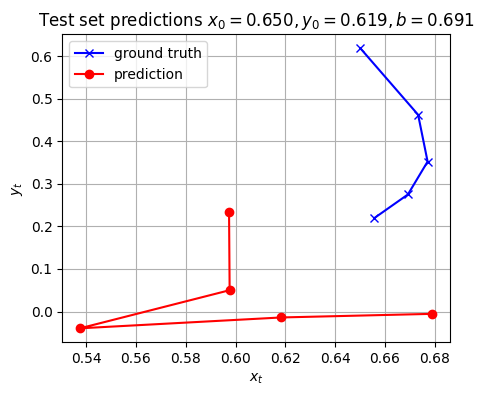

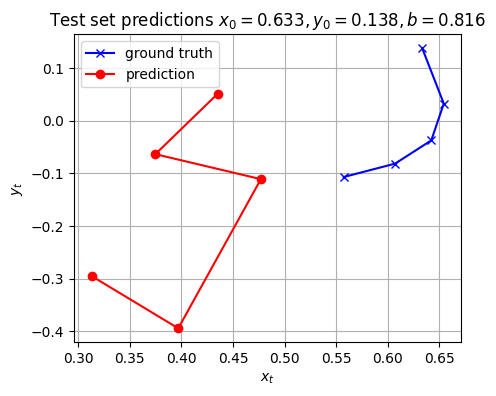

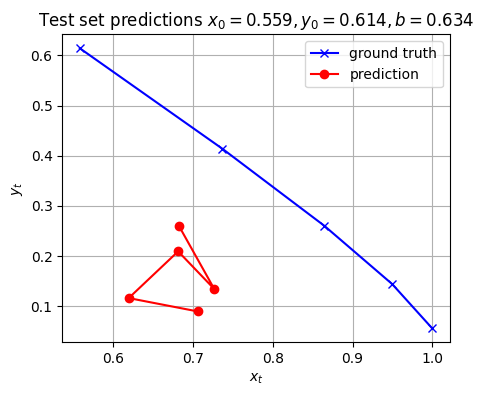

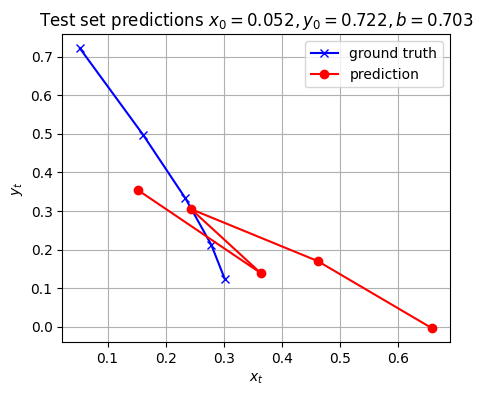

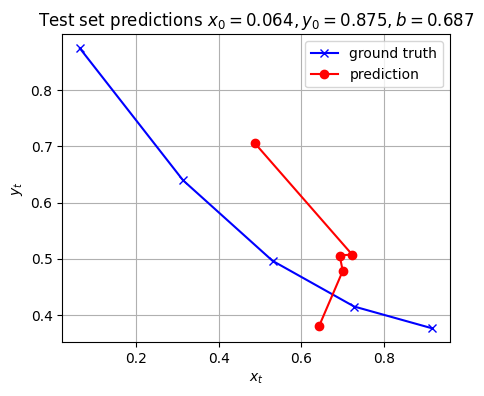


Train set predictions:


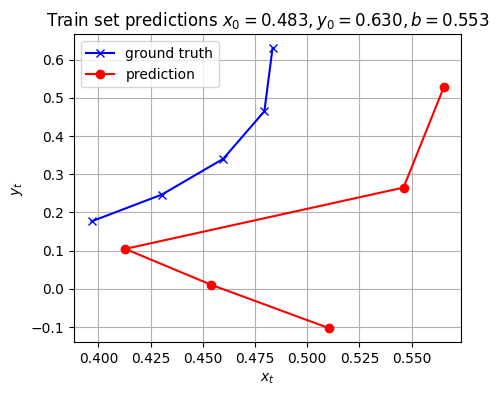

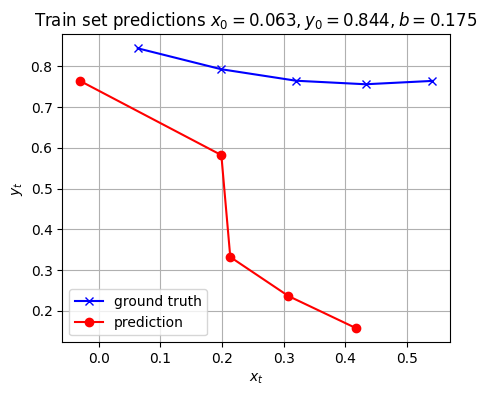

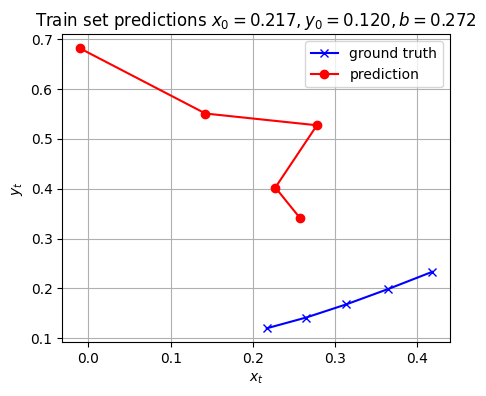

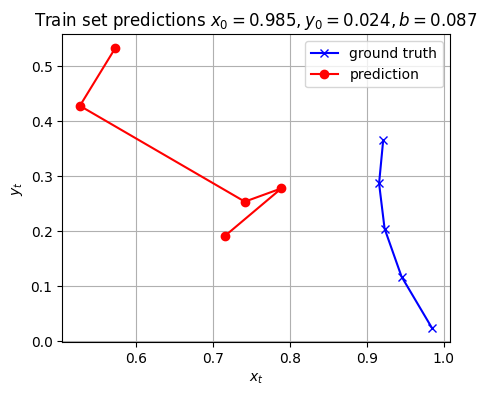

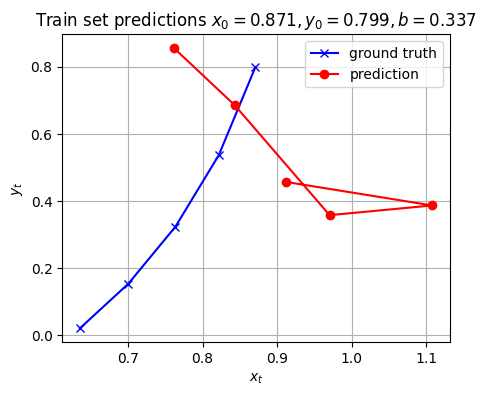


Evaluating test set performance:
Overall R2-Score (test_dataset): 0.12252715975046158

Evaluating train set performance:
Overall R2-Score (train_dataset): 0.09520337730646133


In [ ]:

# Implementation of custom LBFGS optimizer to match the one used in file 2
class LBFGS(optim.LBFGS):
    def __init__(self, params, lr=1, history_size=10, **kwargs):
        super().__init__(params, lr=lr, history_size=history_size, **kwargs)

# Now let's implement the ODE learning code

# Set up device
device = "cpu"

# Define dataset parameters
s_size = 30

# Sample input data
x_sample = torch.tensor(np.random.uniform(0, 1, size=s_size), dtype=torch.float32, device=device)
y_sample = torch.tensor(np.random.uniform(0, 1, size=s_size), dtype=torch.float32, device=device)
z_sample = torch.tensor(np.random.uniform(0, 1, size=s_size), dtype=torch.float32, device=device)
a_sample = torch.tensor(np.random.uniform(0, 1, size=s_size), dtype=torch.float32, device=device)
b_sample = torch.tensor(np.random.uniform(0, 1, size=s_size), dtype=torch.float32, device=device)
c_sample = torch.tensor(np.random.uniform(0, 1, size=s_size), dtype=torch.float32, device=device)
d_sample = torch.tensor(np.random.uniform(0, 1, size=s_size), dtype=torch.float32, device=device)

# Define time steps
duration = 1
time_interval = 0.2
steps = int(duration / time_interval)
print(f"Number of steps: {steps}")
t_eval = torch.linspace(0, duration, steps=int(steps))

# Create dataset
dataset = torch.stack([x_sample, y_sample, z_sample, a_sample, b_sample, c_sample, d_sample], dim=1).to(device)
dataset = dataset.repeat_interleave(steps, dim=0)
t_eval_set = t_eval.T.repeat(s_size).view(-1, 1).to(device)

dataset = torch.cat([t_eval_set, dataset], dim=1)
dataset.requires_grad = True
print(f"Dataset shape: {dataset.shape}")

# Split into train and test
test_size = 5
test_dataset = dataset[(s_size-test_size)*steps:]
dataset = dataset[:(s_size-test_size)*steps]
print(f"Train dataset shape: {dataset.shape}, Test dataset shape: {test_dataset.shape}")

# Define the Jacobian computation function
def compute_jacobian(model, x):
    def ret_sum(x):
        return model(x)
    jacb = autograd.functional.jacobian(ret_sum, x, create_graph=True)  # Compute the jacobian
    jacb = jacb[:, :, :, 0]  # only get the d/dt for the output vars
    jacb = jacb.sum(dim=-1).unsqueeze(-1)  # sum across the final axis and reshape
    return jacb

# Define the ODE computation function
def compute_ode(y_pred, x):
    def ode(init_cond, a, b, c, d):
        return -a*init_cond[:, 0] + b*init_cond[:, 1] + c*init_cond[:, 2], \
               (d - a)*init_cond[:, 0] - 2*b*init_cond[:, 1], \
               d*init_cond[:, 0] + b*init_cond[:, 1] - c*init_cond[:, 2]

    grad = ode(y_pred, x[:, 4], x[:, 5], x[:, 6], x[:, 7])  # Compute the ddt through the ODE
    grad = torch.tensor([[dxdt, dydt, dzdt] for dxdt, dydt, dzdt in zip(grad[0], grad[1], grad[2])], 
                        device=device).unsqueeze(-1)  # reshape tensor
    return grad

# Compute forward integrals using scipy
def compute_forward_integrals(dataset, duration, t_eval):
    def system_cont(t, x, a, b, c, d):
        dxdt = [-a*x[0] + b*x[1] + c*x[2], 
                (d - a)*x[0] - 2*b*x[1], 
                d*x[0] + b*x[1] - c*x[2]]
        return dxdt 
    
    sol_set = []
    for init_cond in dataset.detach().cpu().numpy():
        t, x0, y0, z0, a, b, c, d = init_cond[0], init_cond[1], init_cond[2], init_cond[3], \
                                    init_cond[4], init_cond[5], init_cond[6], init_cond[7]
        sol = sc.integrate.solve_ivp(system_cont, [0, duration], (x0, y0, z0), 
                                     args=(a, b, c, d), t_eval=t_eval)
        sol_set.extend(np.array(sol.y.T))
    
    sol_set = torch.tensor(np.array(sol_set), dtype=torch.float32, device=device)
    return sol_set

# Define the ODE residual loss function
def ode_residuals(model, coords, steps, duration, t_eval, alpha=1.0, beta=1.0, gamma=1.0):
    coords = coords.clone().detach().requires_grad_(True)

    # Compute integral points through time
    y_pred = model(coords)  # shape: nsamplex3x1
    y_gt = compute_forward_integrals(coords[::steps], duration, t_eval)  # shape: nsamplex3x1

    # Compute gradients
    kan_autograd = compute_jacobian(model, coords)  # shape: nsamplex3x1
    kan_ode_grad = compute_ode(y_pred, coords)  # shape: nsamplex3x1

    # Compute initial points in space
    init_kan_grad = y_pred[::steps]  # shape: s_sizex3
    init_ode_grad = coords[::steps][:, 1:4]  # shape: s_sizex3

    # Compute loss components
    dyn_loss = torch.mean((kan_autograd - kan_ode_grad)**2)
    integral_loss = torch.mean((y_pred - y_gt)**2)
    init_loss = torch.mean((init_kan_grad - init_ode_grad)**2)
    
    # Combine losses
    batch_loss = alpha*dyn_loss + beta*integral_loss + gamma*init_loss
    
    return batch_loss

# Create FastKAN model 
# The width corresponds to [input_dim, hidden_dim, output_dim]
model_scenario4  = FastKAN(
    layers_hidden=[8, 24, 3],  # 8 inputs, 24 hidden units, 3 outputs
    grid_min=-2.0,
    grid_max=2.0,
    num_grids=15,  # Matching the 'grid=15' parameter
    use_base_update=False,
    use_layernorm=False
)
model_scenario4.to(device)

# Verify Jacobian shape (for debugging)
print(f"Jacobian shape: {compute_jacobian(model_scenario4, dataset).shape}")

# Training function
def train(model, iterations=2):
    # Using Adam instead of LBFGS for simplicity in this implementation
    # You could also use optim.LBFGS directly
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    for i in range(iterations):
        optimizer.zero_grad()
        loss = ode_residuals(model, dataset, steps, duration, t_eval)
        loss.backward()
        optimizer.step()
        
        if i % 1 == 0:
            print(f"Iteration {i}, Loss: {loss.item()}")
    
    return model

# Function to run ODE system for visualization
def system_eq_dis(cond_input, t_eval, time):
    def system_cont(t, x, a, b, c, d):
        dxdt = [-a*x[0] + b*x[1] + c*x[2], 
                (d - a)*x[0] - 2*b*x[1], 
                d*x[0] + b*x[1] - c*x[2]]
        return dxdt
    
    x0, y0, z0, a, b, c, d = cond_input
    sol = sc.integrate.solve_ivp(system_cont, [0, time], (x0, y0, z0), 
                                args=(a, b, c, d), t_eval=t_eval)
    return sol.y.T, sol.t.T

# Train the model
print("Training model...")
model_scenario4 = train(model_scenario4, iterations=5)

# Visualize test set results
print("\nTest set predictions:")
for k in range(0, 5):
    plt.figure(figsize=[5,4])
    sol, t_h = system_eq_dis(test_dataset[int(steps)*k, 1:].detach().cpu(), t_eval, duration)
    plt.plot(sol[:, 0], sol[:, 1], c='b', marker='x', label='ground truth')
    
    y_pred = model_scenario4(test_dataset[int(steps)*k:int(steps)*(k+1)]).detach().cpu().numpy()
    plt.plot(y_pred[:, 0], y_pred[:, 1], c='r', marker='o', label='prediction')
    
    plt.grid()
    x0, y0, z0, a, b, c, d = test_dataset[int(steps)*k, 1:].detach().cpu().numpy()
    plt.title(f"Test set predictions $x_0={x0:.3f}, y_0={y0:.3f}, b={b:.3f}$")
    plt.xlabel(r"$x_t$")
    plt.ylabel(r"$y_t$")
    plt.legend()
    plt.show()

# Visualize train set results
print("\nTrain set predictions:")
for k in range(0, 5):
    plt.figure(figsize=[5,4])
    sol, t_h = system_eq_dis(dataset[int(steps)*k, 1:].detach().cpu(), t_eval, duration)
    plt.plot(sol[:, 0], sol[:, 1], c='b', marker='x', label='ground truth')
    
    y_pred = model_scenario4(dataset[int(steps)*k:int(steps)*(k+1)]).detach().cpu().numpy()
    plt.plot(y_pred[:, 0], y_pred[:, 1], c='r', marker='o', label='prediction')
    
    plt.grid()
    x0, y0, z0, a, b, c, d = dataset[int(steps)*k, 1:].detach().cpu().numpy()
    plt.title(f"Train set predictions $x_0={x0:.3f}, y_0={y0:.3f}, b={b:.3f}$")
    plt.xlabel(r"$x_t$")
    plt.ylabel(r"$y_t$")
    plt.legend()
    plt.show()

# Compute error metrics on test set
print("\nEvaluating test set performance:")
sol_map = []
for init_conds in test_dataset[::steps].detach().cpu().numpy():
    sol, _ = system_eq_dis(init_conds[1:], t_eval, duration)
    sol_map.extend(sol)

np.savetxt('groundtruths_test.txt', sol_map, fmt='%f')
pred = model_scenario4(test_dataset).detach().cpu().numpy()
res_score = r2_score(sol_map, pred)
print(f"Overall R2-Score (test_dataset): {res_score}")
np.savetxt('predictions_test.txt', pred, fmt='%f')

# Compute error metrics on train set
print("\nEvaluating train set performance:")
sol_map = []
for init_conds in dataset[::steps].detach().cpu().numpy():
    sol, _ = system_eq_dis(init_conds[1:], t_eval, duration)
    sol_map.extend(sol)

np.savetxt('groundtruths_train.txt', sol_map, fmt='%f')
pred = model_scenario4(dataset).detach().cpu().numpy()
res_score = r2_score(sol_map, pred)
print(f"Overall R2-Score (train_dataset): {res_score}")
np.savetxt('predictions_train.txt', pred, fmt='%f')


# Evaluating test set performance:
# Overall R2-Score (test_dataset): -0.02846693992614746

# Evaluating train set performance:
# Overall R2-Score (train_dataset): 0.9651715159416199

# Fitting Segments With Constant Number (Vanilla)

Fitting KAN model with 2 FastKANLayer(s)...
Fitting Layer 0 (2 -> 6)
Fitting Layer 1 (6 -> 2)
Fitting process completed. Generated data for 24 connections.


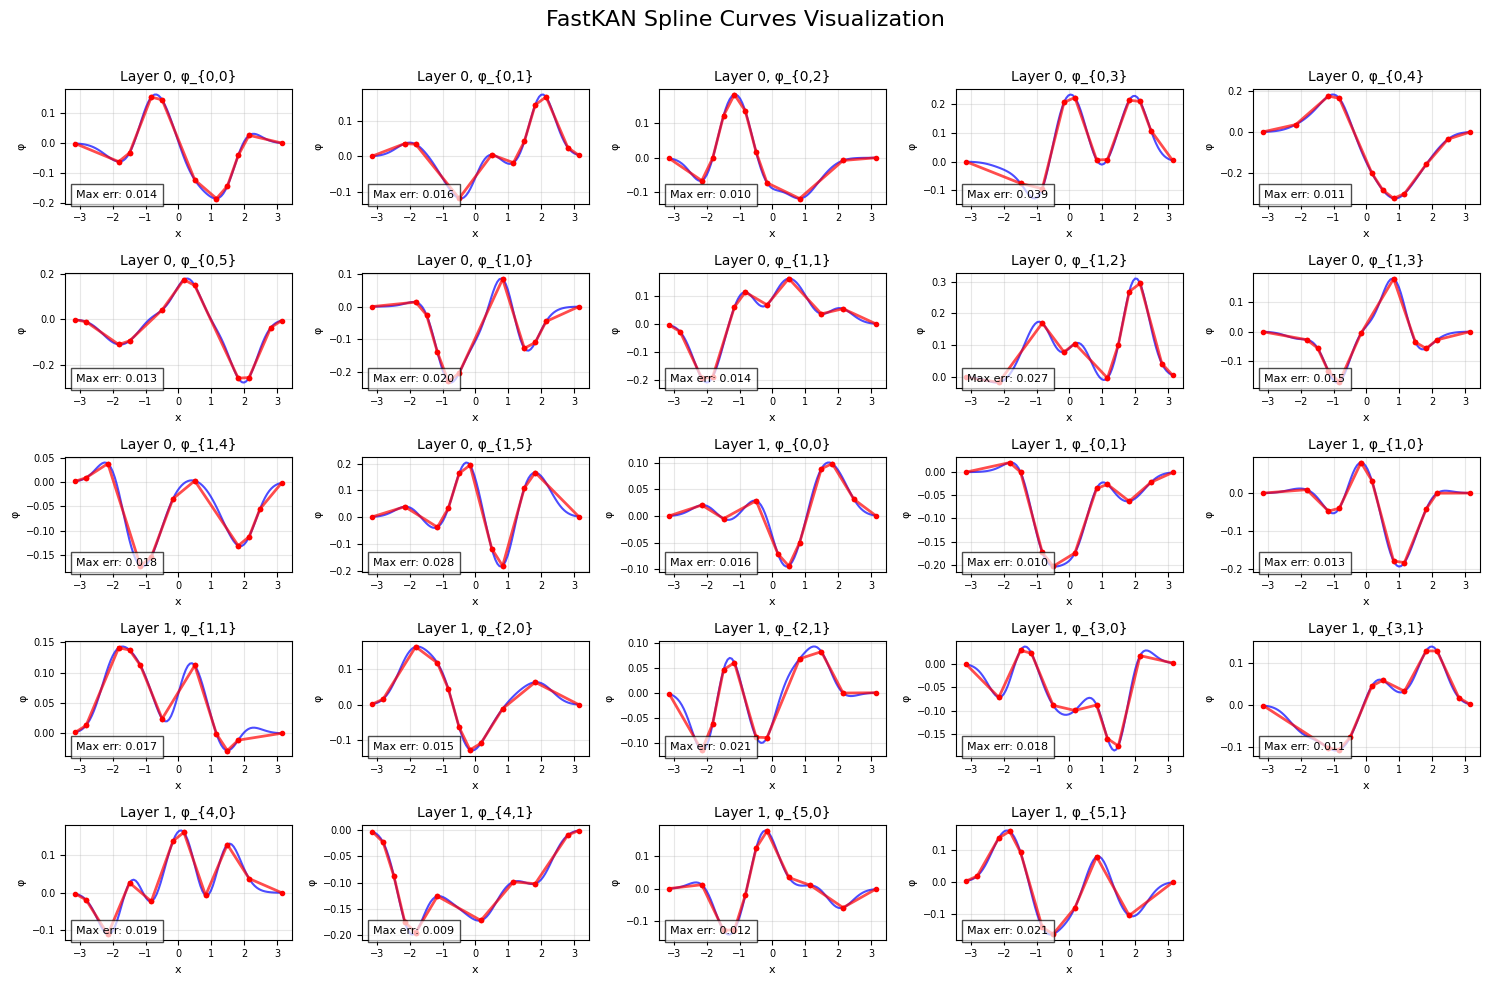

In [54]:
def fit_line_through_points(x1, y1, x2, y2):
    slope = (y2 - y1) / (x2 - x1)
    intercept = y1 - slope * x1
    return slope, intercept

def find_bspline_segments_given_max_segments(layer, input_index, output_index, max_segments, min_x, max_x):
    
    # Sample points from the spline
    n_samples = min(max_segments * 10, 20)
    
    # Create evenly spaced x points
    x_points = np.linspace(min_x, max_x, n_samples)
    
    # Get y values from the FastKAN layer
    x_tensor, y_tensor = layer.plot_curve(input_index, output_index, num_pts=n_samples)
    
    # Extract numpy arrays and filter to the desired range
    x_np = x_tensor.detach().cpu().numpy()
    y_np = y_tensor.detach().cpu().numpy()
    mask = (x_np >= min_x) & (x_np <= max_x)
    x_points = x_np[mask]
    y_points = y_np[mask]
    
    n = len(x_points)
    if n < 2:
        return [], 0.0
    
    # Precompute errors for all possible segments
    errors = np.full((n, n), np.inf)
    
    for start_idx in range(n-1):
        # Limit the maximum length of segments
        max_len = min(n - start_idx, int(np.round((max_x - min_x) / ((max_x - min_x) / n))))
        
        # For each possible end point
        x_start = x_points[start_idx]
        y_start = y_points[start_idx]
        
        for end_idx in range(start_idx + 1, start_idx + max_len):
            if end_idx >= n:
                break
                
            x_end = x_points[end_idx]
            y_end = y_points[end_idx]
            
            # Skip if segment is too short
            if abs(x_end - x_start) <= 1e-10:
                continue
                
            # Calculate slope and intercept
            slope = (y_end - y_start) / (x_end - x_start)
            intercept = y_start - slope * x_start
            
            # Calculate predicted y values for points in this segment
            segment_x = x_points[start_idx:end_idx+1]
            segment_y = y_points[start_idx:end_idx+1]
            predicted_y = slope * segment_x + intercept
            
            # Calculate maximum error
            segment_error = np.max(np.abs(predicted_y - segment_y))
            errors[start_idx, end_idx] = segment_error
    
    # Dynamic programming to find optimal segmentation
    dp = np.full((max_segments, n), np.inf)
    back = np.zeros((max_segments, n), dtype=int)
    
    # Base case: one segment from start to j
    for j in range(1, n):
        dp[0, j] = errors[0, j]
    
    # Fill dp table
    for i in range(1, max_segments):
        for j in range(i+1, n):
            for k in range(i, j):
                if dp[i-1, k] == np.inf:
                    continue
                    
                if errors[k, j] == np.inf:
                    continue
                    
                curr_error = max(dp[i-1, k], errors[k, j])
                if curr_error < dp[i, j]:
                    dp[i, j] = curr_error
                    back[i, j] = k
    
    # Reconstruct the segments
    segments = []
    curr_seg = n - 1
    
    # If we couldn't find a valid segmentation, return empty
    if dp[max_segments-1, curr_seg] == np.inf:
        return [], np.inf
    
    # Reconstruct the segments
    for i in range(max_segments-1, -1, -1):
        if i > 0:
            prev_seg = back[i, curr_seg]
        else:
            prev_seg = 0
        
        x1, y1 = x_points[prev_seg], y_points[prev_seg]
        x2, y2 = x_points[curr_seg], y_points[curr_seg]
        
        slope, intercept = fit_line_through_points(x1, y1, x2, y2)
        segments.insert(0, (x1, x2, slope, intercept))
        
        curr_seg = prev_seg
        
        if curr_seg <= 0:
            break
    
    # Return segments and maximum error
    return segments, dp[max_segments-1, n-1]

def fit_kan_vanilla(kan_model, segments_per_curve, min_x, max_x):
    # --- (Keep existing fit_kan_vanilla, minor logging improvements) ---
    all_segments = []
    if not hasattr(kan_model, 'layers') or not isinstance(kan_model.layers, nn.ModuleList):
         raise ValueError("Provided model does not have a 'layers' attribute of type nn.ModuleList.")

    num_layers = len(kan_model.layers)
    print(f"Fitting KAN model with {num_layers} FastKANLayer(s)...")

    for layer_idx, layer in enumerate(kan_model.layers):
        if not isinstance(layer, FastKANLayer):
             print(f"Warning: Layer {layer_idx} is not a FastKANLayer, skipping.")
             continue

        # Ensure layer is on CPU for numpy compatibility in find_bspline_segments
        layer.cpu()
        input_dim = layer.input_dim
        output_dim = layer.output_dim
        print(f"Fitting Layer {layer_idx} ({input_dim} -> {output_dim})")

        for input_index in range(input_dim):
            for output_index in range(output_dim):
                #print(f"  Fitting curve: Input {input_index}, Output {output_index}")
                segments, max_error = find_bspline_segments_given_max_segments(
                    layer, input_index, output_index, segments_per_curve, min_x, max_x
                )

                # Handle fitting results
                if not segments and max_error == np.inf:
                     print(f"    ERROR: Failed to fit segments for Layer {layer_idx}, Input {input_index}, Output {output_index}. Max error is Inf.")
                elif not segments:
                     # This case means n < 2 points were in range, or DP failed but fallback didn't run/succeed
                     # If max_error is 0, it implies flat line within range or trivially fits
                     if max_error == 0.0:
                          print(f"    Note: No segments needed (likely flat/trivial fit) for Layer {layer_idx}, Input {input_index}, Output {output_index} within [{min_x:.2f}, {max_x:.2f}]. Max error={max_error:.4f}")
                     else: # DP failed, no fallback, or fallback failed
                          print(f"    WARNING: Failed to fit segments (no segments returned) for Layer {layer_idx}, Input {input_index}, Output {output_index}. Max error={max_error:.4f}")
                          # Treat as high error but store the info
                          max_error = np.inf # Ensure it's treated as high error later

                all_segments.append({ # Use dict for clarity
                    'layer_idx': layer_idx,
                    'input_idx': input_index,
                    'output_idx': output_index,
                    'segments': segments,
                    'max_error': max_error # Store actual error (incl np.inf)
                })
    print(f"Fitting process completed. Generated data for {len(all_segments)} connections.")
    return all_segments

def plot_kan(
    kan_model,
    all_segments,
    figsize=(15, 10),
    min_x=-5.0,
    max_x=5.0,
    num_pts=500,
):
    """
    Plot the KAN model's activation functions and their linear segment approximations.
    
    Args:
        kan_model: The KAN model to visualize
        all_segments: List of dictionaries containing segment data from fit_kan_vanilla
        figsize: Figure size (width, height) in inches
        min_x, max_x: X-axis range for visualization
        num_pts: Number of points to sample for the original curve
    
    Returns:
        matplotlib Figure object
    """
    total_curves = len(all_segments)
    cols = math.ceil(math.sqrt(total_curves))
    rows = math.ceil(total_curves / cols)
    fig, axes = plt.subplots(rows, cols, figsize=figsize, squeeze=False)
    fig.suptitle('FastKAN Spline Curves Visualization', fontsize=16)
    axes = axes.flatten()
    
    for idx, segment_data in enumerate(all_segments):
        # Extract data from the dictionary
        layer_idx = segment_data['layer_idx']
        input_index = segment_data['input_idx']
        output_index = segment_data['output_idx']
        segments = segment_data['segments']
        max_error = segment_data['max_error']
        
        ax = axes[idx]
        layer = kan_model.layers[layer_idx]
        
        # Plot original curve
        x_tensor, y_tensor = layer.plot_curve(
            input_index, output_index, 
            num_pts=num_pts
        )
        x_orig = x_tensor.detach().cpu().numpy()
        y_orig = y_tensor.detach().cpu().numpy()
        mask = (x_orig >= min_x) & (x_orig <= max_x)
        x_orig = x_orig[mask]
        y_orig = y_orig[mask]
        ax.plot(x_orig, y_orig, 'b-', linewidth=1.5, alpha=0.7, label='Original')
        
        # Plot segments if they exist
        if segments and max_error != np.inf:
            for x1, x2, slope, intercept in segments:
                x_seg = np.linspace(x1, x2, 50)
                y_seg = slope * x_seg + intercept
                ax.plot(x_seg, y_seg, 'r-', linewidth=2, alpha=0.7)
                ax.plot([x1], [slope * x1 + intercept], 'ro', markersize=3)
                ax.plot([x2], [slope * x2 + intercept], 'ro', markersize=3)
        
        # Show error or failure message
        error_text = f'Max err: {max_error:.3f}' if max_error != np.inf else 'Fitting failed'
        ax.text(0.05, 0.05, error_text, transform=ax.transAxes, 
                fontsize=8, bbox=dict(facecolor='white', alpha=0.7))
        
        ax.set_title(f'Layer {layer_idx}, φ_{{{input_index},{output_index}}}', fontsize=10)
        ax.set_xlabel('x', fontsize=8)
        ax.set_ylabel(f'φ', fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=7)
        ax.grid(True, alpha=0.3)
    
    # Turn off any unused subplots
    for i in range(total_curves, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    return fig

kan_model = FastKAN([2, 6, 2])
all_segments = fit_kan_vanilla(
    kan_model,
    min_x=-5.0,
    max_x=5.0,
    segments_per_curve=10
)
fig = plot_kan(
    kan_model,
    all_segments,
    figsize=(15, 10),
    min_x=-5.0,
    max_x=5.0,
    num_pts=100,
)
plt.show()

# Fitting Segments With Lipschitz

![image.png](python_lipschitz.png)

Creating example FastKAN model...

Comparing original and weighted error tables...
Analyzing Layer 0: 2 inputs -> 3 outputs
Analyzing Layer 1: 3 inputs -> 2 outputs
Weighing Layer 0: 2 inputs -> 3 outputs
Weighing Layer 1: 3 inputs -> 2 outputs
Analyzing Layer 0: 2 inputs -> 3 outputs
Analyzing Layer 1: 3 inputs -> 2 outputs

====== Layer 0: 2 inputs -> 3 outputs ======

B-spline at Layer 0, Input 0, Output 0:
  Lipschitz constant: 0.3729
  Downstream Lipschitz product: 0.1560
  Number of downstream splines: 2

  Error Table Comparison:
  -------------------------------------------------------------------------------------
  | Segments |  Original Error  |  Weighted Error  |  Weight Factor  |  Ratio (W/O)  |
  -------------------------------------------------------------------------------------
  |     1    |   4.459729e-02 |   6.958463e-03 |   1.560288e-01 |       0.156029 |
  |     2    |   8.846779e-02 |   1.380353e-02 |   1.560288e-01 |       0.156029 |
  |     3    |   3.179038e-0

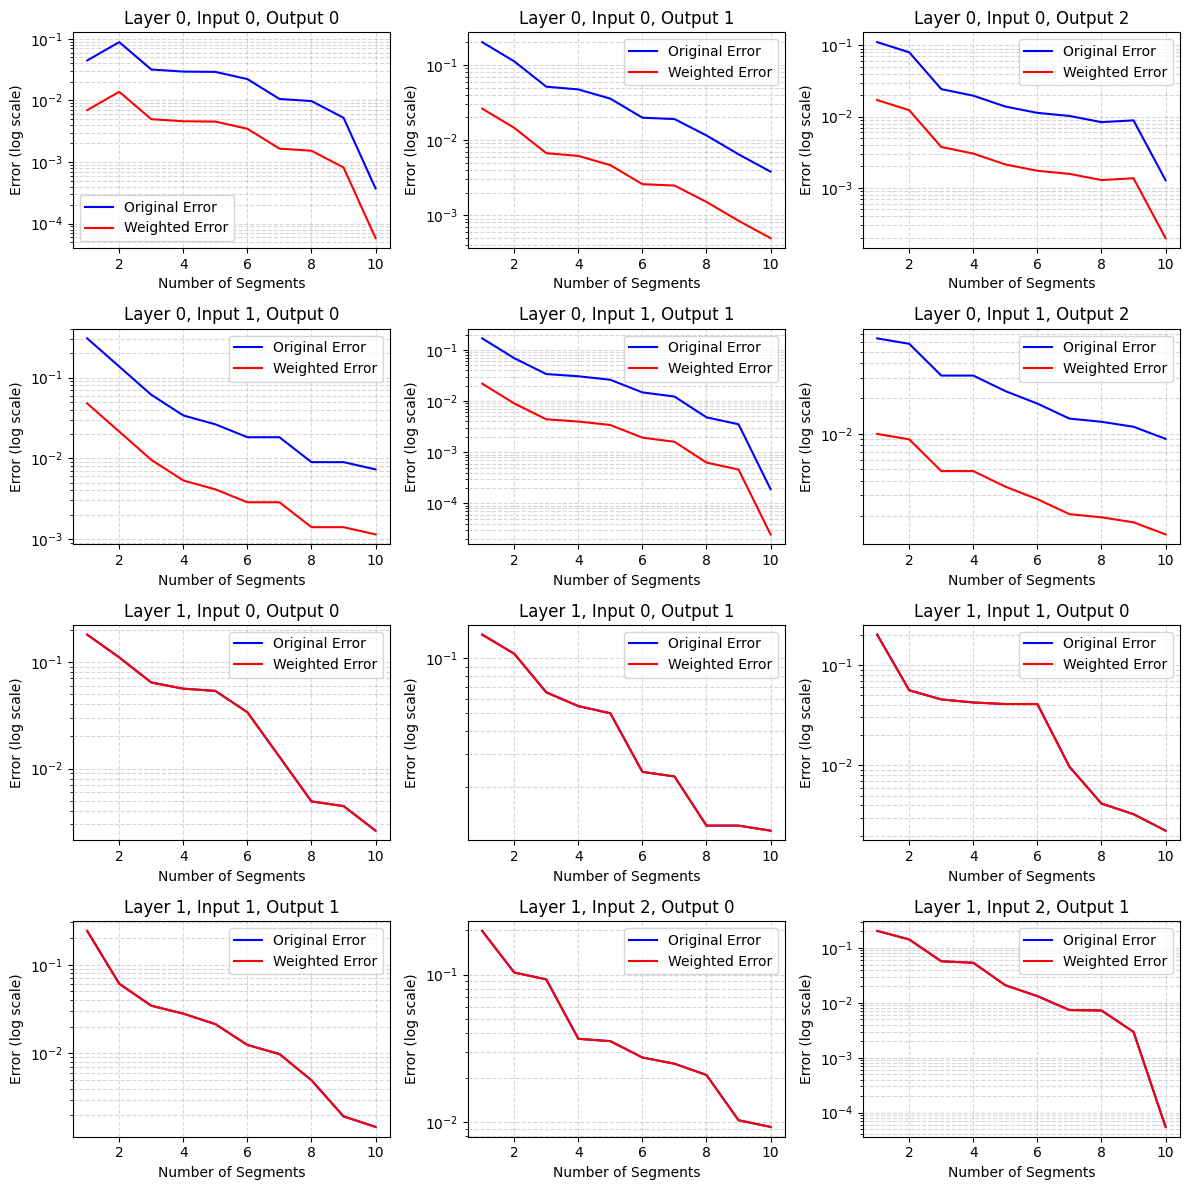

In [5]:
def optimize_bspline(kan_model, layer_idx, input_idx, output_idx, 
                    min_x=-5.0, max_x=5.0, max_segments=15):
    layer = kan_model.layers[layer_idx]
    
    # Generate the error table for this B-spline
    error_table = {}
    segments_table = {}
    
    for num_segments in range(1, max_segments + 1):
        segments, error = find_bspline_segments_given_max_segments(
            layer, input_idx, output_idx, num_segments, min_x, max_x
        )
        error_table[num_segments] = error
        segments_table[num_segments] = segments
    
    return error_table, segments_table

def compute_dp_tables_lipschitz(kan_model, min_x=-5.0, max_x=5.0, max_segments=15):
    error_tables = {}
    segments_tables = {}
    lipschitz_constants = {}
    
    # Iterate through all layers
    for layer_idx, layer in enumerate(kan_model.layers):
        input_dim = layer.input_dim
        output_dim = layer.output_dim
        
        print(f"Analyzing Layer {layer_idx}: {input_dim} inputs -> {output_dim} outputs")
        
        # Iterate through all B-splines in this layer
        for input_idx in range(input_dim):
            for output_idx in range(output_dim):
                spline_key = (layer_idx, input_idx, output_idx)
               # print(f"  Processing B-spline at Layer {layer_idx}, Input {input_idx}, Output {output_idx}...")
                
                # Optimize this B-spline
                error_table, segments_table = optimize_bspline(
                    kan_model=kan_model,
                    layer_idx=layer_idx,
                    input_idx=input_idx,
                    output_idx=output_idx,
                    min_x=min_x,
                    max_x=max_x,
                    max_segments=max_segments
                )
                
                # Calculate Lipschitz constant for this B-spline
                lipschitz_constant = calculate_bspline_lipschitz_constant(
                    layer=layer,
                    input_idx=input_idx,
                    output_idx=output_idx
                )
                
                # Store the results
                error_tables[spline_key] = error_table
                segments_tables[spline_key] = segments_table
                lipschitz_constants[spline_key] = lipschitz_constant
                
                #print(f"    Lipschitz constant: {lipschitz_constant}")
    
    return error_tables, segments_tables, lipschitz_constants

def calculate_bspline_lipschitz_constant(
    layer: 'FastKANLayer', 
    input_idx: int, 
    output_idx: int, 
    num_pts: int = 1000,
    min_x: float = None,
    max_x: float = None
) -> float:
    # Set default range if not provided
    if min_x is None:
        min_x = layer.rbf.grid_min
    if max_x is None:
        max_x = layer.rbf.grid_max
    
    # Sample points from the B-spline
    x_tensor, y_tensor = layer.plot_curve(
        input_idx, 
        output_idx, 
        num_pts=num_pts
    )
    
    # Convert to numpy arrays
    x_np = x_tensor.detach().cpu().numpy()
    y_np = y_tensor.detach().cpu().numpy()
    
    # Filter to desired range
    mask = (x_np >= min_x) & (x_np <= max_x)
    x_np = x_np[mask]
    y_np = y_np[mask]
    
    # Calculate numerical derivatives (slopes between adjacent points)
    dx = np.diff(x_np)
    dy = np.diff(y_np)
    
    # Avoid division by zero
    nonzero_dx = dx != 0
    slopes = np.zeros_like(dx)
    slopes[nonzero_dx] = dy[nonzero_dx] / dx[nonzero_dx]
    
    # The Lipschitz constant is the maximum absolute slope
    lipschitz_constant = np.max(np.abs(slopes))
    
    return lipschitz_constant

def get_all_downstream_splines(kan_model, layer_idx, input_idx, output_idx, visited=None):
    if visited is None:
        visited = set()
    
    if layer_idx >= len(kan_model.layers) - 1:
        # This is the last layer, no downstream splines
        return set()
    
    # The output of this spline becomes an input in the next layer
    next_input_idx = output_idx
    next_layer_idx = layer_idx + 1
    next_layer = kan_model.layers[next_layer_idx]
    
    downstream_splines = set()
    
    # For each output in the next layer
    for next_output_idx in range(next_layer.output_dim):
        next_spline = (next_layer_idx, next_input_idx, next_output_idx)
        
        if next_spline not in visited:
            visited.add(next_spline)
            downstream_splines.add(next_spline)
            
            # Recursively get all splines downstream of the next spline
            further_downstream = get_all_downstream_splines(
                kan_model, next_layer_idx, next_input_idx, next_output_idx, visited
            )
            downstream_splines.update(further_downstream)
    
    return downstream_splines

def fit_kan_lipschitz(kan_model, min_x=-5.0, max_x=5.0, max_segments=15):
    # First, compute the DP tables and Lipschitz constants
    error_tables, segments_tables, lipschitz_constants = compute_dp_tables_lipschitz(
        kan_model, min_x, max_x, max_segments
    )
    
    # Initialize the weighted error tables
    weighted_error_tables = {}
    
    # Iterate through all splines in the network
    for layer_idx, layer in enumerate(kan_model.layers):
        input_dim = layer.input_dim
        output_dim = layer.output_dim
        
        print(f"Weighing Layer {layer_idx}: {input_dim} inputs -> {output_dim} outputs")
        
        for input_idx in range(input_dim):
            for output_idx in range(output_dim):
                spline_key = (layer_idx, input_idx, output_idx)
               # print(f"  Processing B-spline at Layer {layer_idx}, Input {input_idx}, Output {output_idx}...")
                
                # Get all unique downstream splines
                downstream_splines = get_all_downstream_splines(
                    kan_model, layer_idx, input_idx, output_idx
                )
                
                # Compute the product of Lipschitz constants of all downstream splines
                lipschitz_product = 1.0
                for downstream_spline in downstream_splines:
                    if downstream_spline in lipschitz_constants:
                        lipschitz_product *= lipschitz_constants[downstream_spline]
                
                # Weight the error table
                weighted_table = {}
                for num_segments, error in error_tables[spline_key].items():
                    weighted_table[num_segments] = error * lipschitz_product
                
                weighted_error_tables[spline_key] = weighted_table
                
               # print(f"    Unique downstream splines: {len(downstream_splines)}")
               # print(f"    Lipschitz product: {lipschitz_product}")
    
    return weighted_error_tables, segments_tables, lipschitz_constants

def compare_error_tables(kan_model, min_x=-5.0, max_x=5.0, max_segments=20):
    # First, compute the weighted error tables
    weighted_error_tables, segments_tables, lipschitz_constants = fit_kan_lipschitz(
        kan_model, min_x, max_x, max_segments
    )
    
    # Get the original error tables from compute_dp_tables_lipschitz
    original_error_tables, _, _ = compute_dp_tables_lipschitz(
        kan_model, min_x, max_x, max_segments
    )
    
    # Create figures to display the comparison
    num_layers = len(kan_model.layers)
    for layer_idx in range(num_layers):
        layer = kan_model.layers[layer_idx]
        input_dim = layer.input_dim
        output_dim = layer.output_dim
        
        print(f"\n====== Layer {layer_idx}: {input_dim} inputs -> {output_dim} outputs ======")
        
        for input_idx in range(input_dim):
            for output_idx in range(output_dim):
                spline_key = (layer_idx, input_idx, output_idx)
                
                # Get the original and weighted error tables
                orig_table = original_error_tables[spline_key]
                weighted_table = weighted_error_tables[spline_key]
                
                # Get the Lipschitz constant
                lip_const = lipschitz_constants[spline_key]
                
                # Get the downstream splines
                downstream_splines = get_all_downstream_splines(
                    kan_model, layer_idx, input_idx, output_idx
                )
                
                # Compute the product of downstream Lipschitz constants
                lipschitz_product = 1.0
                for ds_spline in downstream_splines:
                    if ds_spline in lipschitz_constants:
                        lipschitz_product *= lipschitz_constants[ds_spline]
                
                print(f"\nB-spline at Layer {layer_idx}, Input {input_idx}, Output {output_idx}:")
                print(f"  Lipschitz constant: {lip_const:.4f}")
                print(f"  Downstream Lipschitz product: {lipschitz_product:.4f}")
                print(f"  Number of downstream splines: {len(downstream_splines)}")
                
                # Create a table to display the comparison
                print("\n  Error Table Comparison:")
                print("  -------------------------------------------------------------------------------------")
                print("  | Segments |  Original Error  |  Weighted Error  |  Weight Factor  |  Ratio (W/O)  |")
                print("  -------------------------------------------------------------------------------------")
                
                # Display selected segment counts for clarity
                selected_segments = [1, 2, 3, 5, 10, max_segments]
                for num_segments in selected_segments:
                    if num_segments in orig_table and num_segments in weighted_table:
                        orig_error = orig_table[num_segments]
                        weighted_error = weighted_table[num_segments]
                        
                        # Calculate the ratio
                        ratio = weighted_error / orig_error if orig_error != 0 else float('inf')
                        
                        print(f"  |    {num_segments:2d}    | {orig_error:14.6e} | {weighted_error:14.6e} | {lipschitz_product:14.6e} | {ratio:14.6f} |")
                
                print("  -------------------------------------------------------------------------------------")
    
    # Return all the tables for potential further analysis
    return original_error_tables, weighted_error_tables, lipschitz_constants

def visualize_error_comparison(kan_model, min_x=-5.0, max_x=5.0, max_segments=20):
    # Compute the tables
    original_tables, weighted_tables, lipschitz_constants = compare_error_tables(
        kan_model, min_x, max_x, max_segments
    )
    
    # Count the total number of splines
    total_splines = sum(
        layer.input_dim * layer.output_dim 
        for layer in kan_model.layers
    )
    
    # Set up the figure with subplots (adjust the layout based on the number of splines)
    rows = int(np.ceil(np.sqrt(total_splines)))
    cols = int(np.ceil(total_splines / rows))
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3), squeeze=False)
    
    # Flatten the axes array for easy iteration
    axes_flat = axes.flatten()
    
    # Counter for subplot index
    subplot_idx = 0
    
    # For each layer and spline
    for layer_idx, layer in enumerate(kan_model.layers):
        for input_idx in range(layer.input_dim):
            for output_idx in range(layer.output_dim):
                if subplot_idx >= len(axes_flat):
                    break  # In case we have more splines than subplots
                
                ax = axes_flat[subplot_idx]
                spline_key = (layer_idx, input_idx, output_idx)
                
                # Get original and weighted errors
                orig_errors = [original_tables[spline_key].get(s, 0) for s in range(1, max_segments+1)]
                weighted_errors = [weighted_tables[spline_key].get(s, 0) for s in range(1, max_segments+1)]
                
                # Plot the data
                segments = list(range(1, max_segments+1))
                ax.plot(segments, orig_errors, 'b-', label='Original Error')
                ax.plot(segments, weighted_errors, 'r-', label='Weighted Error')
                
                # Add logarithmic scale for better visualization
                ax.set_yscale('log')
                
                # Add title and labels
                ax.set_title(f'Layer {layer_idx}, Input {input_idx}, Output {output_idx}')
                ax.set_xlabel('Number of Segments')
                ax.set_ylabel('Error (log scale)')
                ax.legend()
                ax.grid(True, which="both", ls="--", alpha=0.5)
                
                subplot_idx += 1
    
    # Remove any unused subplots
    for i in range(subplot_idx, len(axes_flat)):
        fig.delaxes(axes_flat[i])
    
    plt.tight_layout()
    
    # Return the figure for further customization or saving
    return fig

# Example usage with a small FastKAN model
def create_example_kan_model():
    """Create a small FastKAN model for testing."""
    # Define the layer sizes: input, hidden layers, output
    layers_hidden = [2, 3, 2]  # 2 inputs -> 3 hidden -> 2 hidden -> 1 output
    
    # Create the model
    model = FastKAN(
        layers_hidden=layers_hidden,
        grid_min=-2.0,
        grid_max=2.0,
        num_grids=8,
        use_base_update=True,
    )
    
    return model

def demo_error_comparison():
    """Demonstrate the error comparison on a small example model."""
    print("Creating example FastKAN model...")
    model = create_example_kan_model()
    
    print("\nComparing original and weighted error tables...")
    # Use smaller max_segments for this demo
    fig = visualize_error_comparison(model, min_x=-2.0, max_x=2.0, max_segments=10)
    
    print("\nVisualization complete. Close the plot window to continue.")
    plt.show()
    
    return model

model = demo_error_comparison()

Analyzing Layer 0: 2 inputs -> 3 outputs
Analyzing Layer 1: 3 inputs -> 2 outputs
Weighing Layer 0: 2 inputs -> 3 outputs
Weighing Layer 1: 3 inputs -> 2 outputs
Optimizing segment allocation for 12 B-splines...
  Processing spline 1/12...
  Processing spline 2/12...
  Processing spline 3/12...
  Processing spline 4/12...
  Processing spline 5/12...
  Processing spline 6/12...
  Processing spline 7/12...
  Processing spline 8/12...
  Processing spline 9/12...
  Processing spline 10/12...
  Processing spline 11/12...
  Processing spline 12/12...
  Achieved error: 0.07671478390693665
  Total segments allocated: 25

Dynamic Programming Table (Error values):
--------------------------------------------------------------------------------
Spline \ Segments |     0 |    20
---------------------------------
  0 | 0.000 | inf  
  1 | inf   | inf  
  2 | inf   | 0.003
  3 | inf   | 0.005
  4 | inf   | 0.008
  5 | inf   | 0.012
  6 | inf   | 0.014
  7 | inf   | 0.024
  8 | inf   | 0.034
  9 | in

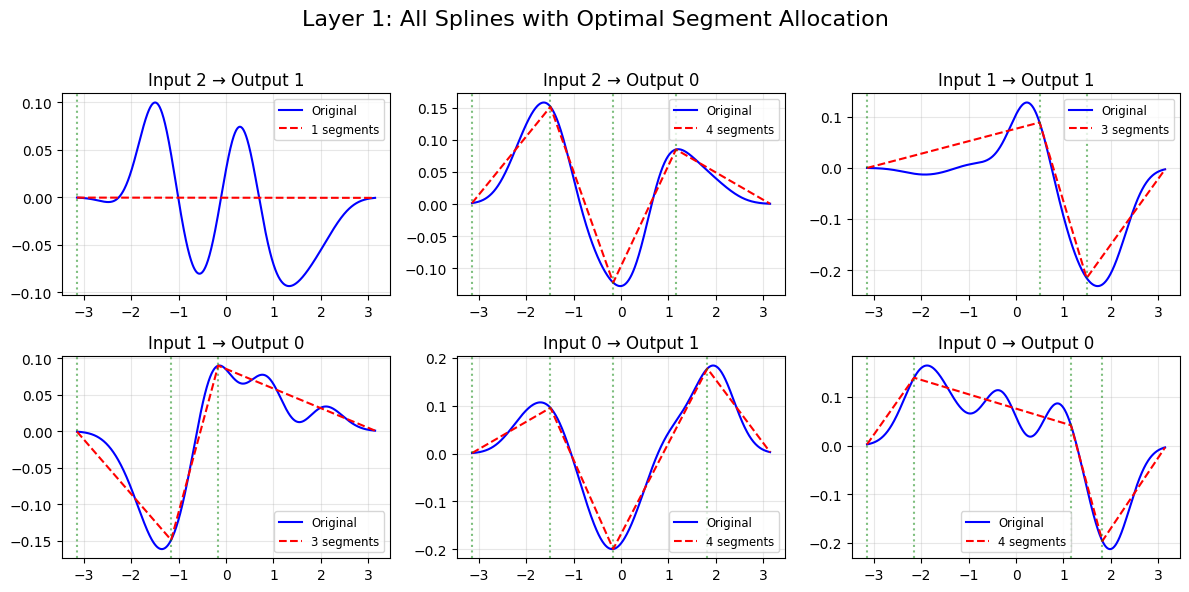

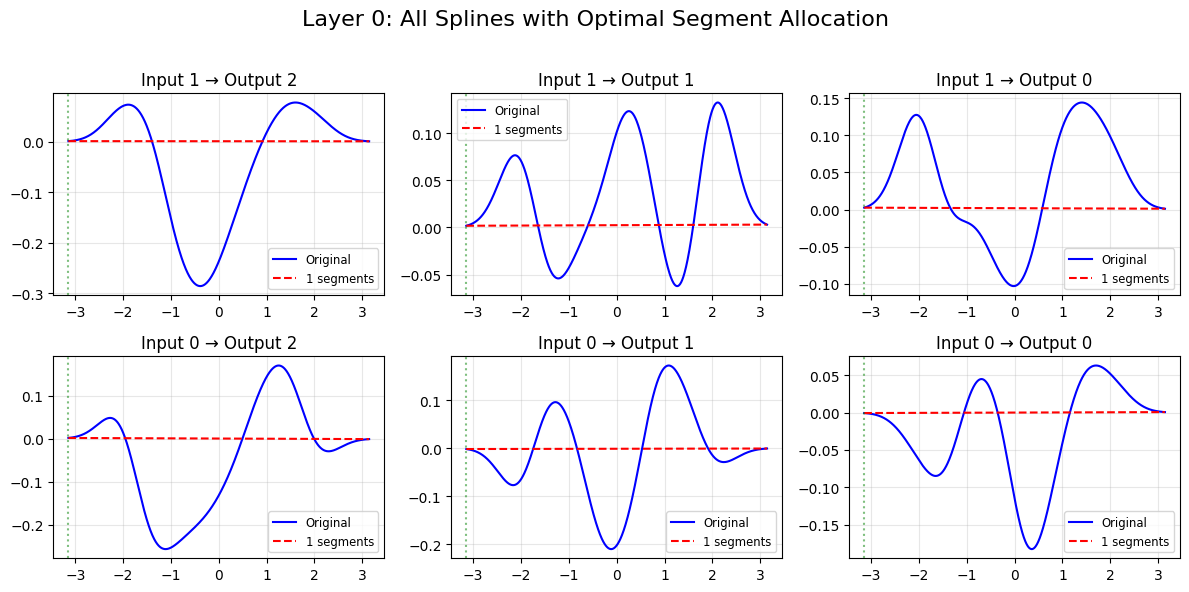

In [6]:
def weight_dp_tables_lipschitz(kan_model, min_x=-5.0, max_x=5.0, max_segments=15):
    error_tables, segments_tables, lipschitz_constants = compute_dp_tables_lipschitz(
        kan_model, min_x, max_x, max_segments
    )
    
    # Initialize the weighted error tables
    weighted_error_tables = {}
    
    # Iterate through all splines in the network
    for layer_idx, layer in enumerate(kan_model.layers):
        input_dim = layer.input_dim
        output_dim = layer.output_dim
        
        print(f"Weighing Layer {layer_idx}: {input_dim} inputs -> {output_dim} outputs")
        
        for input_idx in range(input_dim):
            for output_idx in range(output_dim):
                spline_key = (layer_idx, input_idx, output_idx)
               # print(f"  Processing B-spline at Layer {layer_idx}, Input {input_idx}, Output {output_idx}...")
                
                # Get all unique downstream splines
                downstream_splines = get_all_downstream_splines(
                    kan_model, layer_idx, input_idx, output_idx
                )
                
                # Compute the product of Lipschitz constants of all downstream splines
                lipschitz_product = 1.0
                for downstream_spline in downstream_splines:
                    if downstream_spline in lipschitz_constants:
                        lipschitz_product *= lipschitz_constants[downstream_spline]
                
                # Weight the error table
                weighted_table = {}
                for num_segments, error in error_tables[spline_key].items():
                    weighted_table[num_segments] = error * lipschitz_product
                
                weighted_error_tables[spline_key] = weighted_table
                
               # print(f"    Unique downstream splines: {len(downstream_splines)}")
               # print(f"    Lipschitz product: {lipschitz_product}")
    
    return weighted_error_tables, segments_tables, lipschitz_constants

def fit_kan_optimally_lipschitz(kan_model, weighted_error_tables, segments_tables, max_error, 
                             min_x=-5.0, max_x=5.0, max_segments=50):
    problem = False
    all_splines = list(weighted_error_tables.keys())
    num_splines = len(all_splines)
    
    print(f"Optimizing segment allocation for {num_splines} B-splines...")
    
    max_total_segments = num_splines * max_segments
    
    # Initialize DP table: dp[i][j] represents the minimum error achievable when
    # allocating j total segments to the first i splines
    dp = np.full((num_splines + 1, max_total_segments + 1), float('inf'))
    dp[0, 0] = 0  # Base case: 0 error when allocating 0 segments to 0 splines
    backtrack = np.zeros((num_splines + 1, max_total_segments + 1), dtype=int)
    all_spline_errors = {}
    
    # Fill the DP table
    for i in range(1, num_splines + 1):
        print(f"  Processing spline {i}/{num_splines}...")
        spline_key = all_splines[i-1]
        
        for j in range(max_total_segments + 1):
            # Try different allocations for the current spline
            for segs in range(min(j + 1, max_segments + 1)):
                
                # Check if this number of segments is valid for this spline
                if segs not in weighted_error_tables[spline_key]:
                    continue
                
                # Get the error for this allocation
                spline_error = weighted_error_tables[spline_key][segs]
                prev_error = dp[i-1, j-segs]
                
                # Update if this allocation is better
                if prev_error != float('inf') and max(prev_error, spline_error) < dp[i, j]:
                    dp[i, j] = max(prev_error, spline_error)
                    backtrack[i, j] = segs
    
    # Find the minimum total segments that achieve error <= max_error
    optimal_total_segments = None
    achieved_error = float('inf')
    
    for j in range(max_total_segments + 1):
        if dp[num_splines, j] <= max_error:
            optimal_total_segments = j
            achieved_error = dp[num_splines, j]
            break
    
    # If no allocation satisfies the max_error constraint, find the best possible allocation
    if optimal_total_segments is None:
        # Find the allocation with the minimum error
        min_error_idx = np.argmin(dp[num_splines, :])
        optimal_total_segments = min_error_idx
        achieved_error = dp[num_splines, min_error_idx]
        print(f"Could not find allocation satisfying the max error constraint ({max_error}).")
        print(f"Returning best allocation with error: {achieved_error}")
        problem = True
    
    # Reconstruct the optimal allocation
    optimal_allocation = {}
    actual_segments = {}
    
    remaining_segments = optimal_total_segments
    for i in range(num_splines, 0, -1):
        spline_key = all_splines[i-1]
        # Get the segment allocation for this spline and convert to integer
        segs_for_spline = int(backtrack[i, remaining_segments])
        optimal_allocation[spline_key] = segs_for_spline
        
        # Use integer key to retrieve segments
        actual_segments[spline_key] = segments_tables[spline_key].get(segs_for_spline, [])
        remaining_segments -= segs_for_spline
    
    total_segments = sum(optimal_allocation.values())
    print(f"  Achieved error: {achieved_error}")
    print(f"  Total segments allocated: {total_segments}")
    return optimal_allocation, actual_segments, total_segments, achieved_error, dp, problem

# def fit_kan_optimally_lipschitz(kan_model, weighted_error_tables, segments_tables, max_error, 
#                                       min_x=-5.0, max_x=5.0, max_segments=50, max_total_segments=None,
#                                       pruning_threshold=1000):
#     """
#     Memory-efficient version of fit_kan_optimally_lipschitz for large KAN models.
#     Uses sliding window DP and aggressive state pruning to handle large models.
    
#     Args:
#         kan_model: The FastKAN model
#         weighted_error_tables: Weighted error tables for each spline
#         segments_tables: Segment data for each spline
#         max_error: Maximum acceptable error
#         min_x, max_x: Input domain range
#         max_segments: Maximum segments per spline
#         max_total_segments: Maximum total segments across all splines (None for auto)
#         pruning_threshold: When to prune states to save memory
        
#     Returns:
#         optimal_allocation: Dictionary mapping spline keys to segment counts
#         actual_segments: Dictionary mapping spline keys to actual segment data
#         total_segments: Total number of segments allocated
#         achieved_error: The error achieved by the optimal allocation
#         final_dp: The final DP table for analysis
#         problem: Flag indicating if the solution satisfies the max_error constraint
#     """
#     problem = False
#     all_splines = list(weighted_error_tables.keys())
#     num_splines = len(all_splines)
    
#     print(f"Optimizing segment allocation for {num_splines} B-splines with efficient algorithm...")
    
#     # Set a reasonable limit for total segments
#     if max_total_segments is None:
#         # Adaptive sizing based on number of splines
#         max_total_segments = min(num_splines * 5, 5000)
    
#     print(f"Using maximum of {max_total_segments} total segments")
    
#     # We only need two layers of DP state at a time (sliding window)
#     prev_dp = {0: 0.0}  # Base case: {total_segments: min_error}
    
#     # Store backpointers for the entire DP table (we need this for backtracking)
#     # Format: {layer_index: {total_segments: (prev_segments, allocated_segments)}}
#     backtrack = [{} for _ in range(num_splines + 1)]
    
#     # Process each spline
#     for i in range(1, num_splines + 1):
#         spline_key = all_splines[i-1]
#         print(f"  Processing spline {i}/{num_splines}: {spline_key}")
        
#         # Get valid segment counts for this spline (including 0)
#         valid_segs = [0] + [s for s in range(1, max_segments+1) 
#                          if s in weighted_error_tables[spline_key]]
        
#         # Current layer's DP state
#         curr_dp = {}
        
#         # For each previous state
#         for prev_total_segs, prev_error in prev_dp.items():
#             # Try each possible segment allocation for current spline
#             for segs in valid_segs:
#                 new_total_segs = prev_total_segs + segs
                
#                 # Skip if over the limit
#                 if new_total_segs > max_total_segments:
#                     continue
                
#                 # Calculate new error
#                 if segs == 0:
#                     new_error = prev_error
#                 else:
#                     spline_error = weighted_error_tables[spline_key][segs]
#                     new_error = max(prev_error, spline_error)
                
#                 # Update if better than existing
#                 if new_total_segs not in curr_dp or new_error < curr_dp[new_total_segs]:
#                     curr_dp[new_total_segs] = new_error
#                     backtrack[i][new_total_segs] = (prev_total_segs, segs)
        
#         # Prune states if there are too many
#         if len(curr_dp) > pruning_threshold:
#             print(f"    Pruning states ({len(curr_dp)} states before pruning)...")
            
#             # Sort states by total segments
#             sorted_states = sorted(curr_dp.items())
            
#             # Keep track of best error seen so far
#             best_error_so_far = float('inf')
#             states_to_keep = {}
            
#             # Process states from fewest to most segments
#             for total_segs, error in sorted_states:
#                 # If this state has less error than any we've seen, keep it
#                 if error < best_error_so_far:
#                     states_to_keep[total_segs] = error
#                     best_error_so_far = error
#                 # Also keep some regularly spaced states for diversity
#                 elif total_segs % 10 == 0:
#                     states_to_keep[total_segs] = error
            
#             # Update the current DP state
#             curr_dp = states_to_keep
#             # Clean up backtrack to match
#             backtrack[i] = {segs: entry for segs, entry in backtrack[i].items() 
#                           if segs in states_to_keep}
            
#             print(f"    After pruning: {len(curr_dp)} states")
        
#         # Move to next layer
#         prev_dp = curr_dp
    
#     # Find best allocation
#     final_dp = prev_dp
#     best_total_segs = None
#     achieved_error = float('inf')
    
#     # Try to find allocation within error constraint
#     for total_segs, error in final_dp.items():
#         if error <= max_error and (best_total_segs is None or total_segs < best_total_segs):
#             best_total_segs = total_segs
#             achieved_error = error
    
#     # If not found, use best possible
#     if best_total_segs is None:
#         if final_dp:
#             best_total_segs, achieved_error = min(final_dp.items(), key=lambda x: x[1])
#             print(f"Could not find allocation satisfying max error constraint ({max_error}).")
#             print(f"Using best allocation with error: {achieved_error}")
#             problem = True
#         else:
#             print("ERROR: No valid allocations found!")
#             return {}, {}, 0, float('inf'), None, True
    
#     # Reconstruct optimal allocation
#     optimal_allocation = {key: 0 for key in all_splines}
#     actual_segments = {}
    
#     # Backtrack
#     i = num_splines
#     remaining_segs = best_total_segs
    
#     while i > 0:
#         if remaining_segs not in backtrack[i]:
#             print(f"ERROR: Cannot find backtrack for state ({i}, {remaining_segs})")
#             break
            
#         prev_total_segs, curr_segs = backtrack[i][remaining_segs]
#         spline_key = all_splines[i-1]
        
#         optimal_allocation[spline_key] = curr_segs
#         if curr_segs > 0:
#             actual_segments[spline_key] = segments_tables[spline_key].get(curr_segs, [])
        
#         remaining_segs = prev_total_segs
#         i -= 1
    
#     print(f"Optimization complete with {best_total_segs} total segments.")
#     print(f"Achieved error: {achieved_error}")
    
#     # Return the DP table as well for analysis
#     return optimal_allocation, actual_segments, best_total_segs, achieved_error, final_dp, problem



def print_dp_table(dp_table, num_splines, max_total_segments, step=20):
    print("\nDynamic Programming Table (Error values):")
    print("-" * 80)
    
    # Header row with column indices
    header = "Spline \\ Segments"
    for j in range(0, max_total_segments + 1, step):
        header += f" | {j:5d}"
    print(header)
    print("-" * len(header))
    
    # Print rows with error values
    for i in range(num_splines + 1):
        row = f"{i:3d}"
        for j in range(0, max_total_segments + 1, step):
            if np.isinf(dp_table[i, j]):
                row += " | inf  "
            else:
                row += f" | {dp_table[i, j]:.3f}"
        print(row)
    
    print("-" * 80)
    print("Note: 'inf' indicates that the error is infinite (impossible allocation)")
    print("Only the first 100 columns are shown (if applicable)")

def visualize_all_splines(kan_model, optimal_allocation, actual_segments):
    
    # Group splines by layer for better organization
    splines_by_layer = {}
    for spline_key in optimal_allocation.keys():
        layer_idx, input_idx, output_idx = spline_key
        if layer_idx not in splines_by_layer:
            splines_by_layer[layer_idx] = []
        splines_by_layer[layer_idx].append((input_idx, output_idx))
    
    figures = []
    
    # Create a separate figure for each layer
    for layer_idx, splines in splines_by_layer.items():
        layer = kan_model.layers[layer_idx]
        num_splines = len(splines)
        
        # Determine grid dimensions (try to make it roughly square)
        grid_size = math.ceil(math.sqrt(num_splines))
        rows = math.ceil(num_splines / grid_size)
        cols = min(grid_size, num_splines)
        
        # Create figure and subplots
        fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
        fig.suptitle(f"Layer {layer_idx}: All Splines with Optimal Segment Allocation", fontsize=16)
        
        # Flatten axes if it's a grid
        if num_splines > 1:
            axes_flat = axes.flatten()
        else:
            axes_flat = [axes]
        
        # Plot each spline in this layer
        for i, (input_idx, output_idx) in enumerate(splines):
            if i >= len(axes_flat):
                break
                
            ax = axes_flat[i]
            spline_key = (layer_idx, input_idx, output_idx)
            
            # Get the original spline
            x_tensor, y_tensor = layer.plot_curve(input_idx, output_idx, num_pts=1000)
            x_original = x_tensor.detach().cpu().numpy()
            y_original = y_tensor.detach().cpu().numpy()
            
            # Get the simplified spline
            segments = actual_segments[spline_key]
            x_simplified = []
            y_simplified = []
            
            for x1, x2, slope, intercept in segments:
                segment_x = np.linspace(x1, x2, 50)
                segment_y = slope * segment_x + intercept
                x_simplified.extend(segment_x)
                y_simplified.extend(segment_y)
            
            # Plot
            ax.plot(x_original, y_original, 'b-', label='Original')
            ax.plot(x_simplified, y_simplified, 'r--', label=f'{optimal_allocation[spline_key]} segments')
            
            # Mark segment boundaries
            for x1, x2, _, _ in segments:
                ax.axvline(x=x1, color='g', linestyle=':', alpha=0.5)
            
            ax.set_title(f'Input {input_idx} → Output {output_idx}')
            ax.legend(loc='best', fontsize='small')
            ax.grid(True, alpha=0.3)
        
        # Hide unused subplots if any
        for j in range(num_splines, len(axes_flat)):
            axes_flat[j].set_visible(False)
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave room for the suptitle
        figures.append(fig)
    
    return figures

 # First, compute the weighted error tables
kan_model = FastKAN([2,3,2])  # Replace with your actual FastKAN model
weighted_error_tables, segments_tables, lipschitz_constants = weight_dp_tables_lipschitz(
    kan_model, min_x=-5.0, max_x=5.0, max_segments=12
)

# Then, find the optimal allocation (now returns the DP table too)
optimal_allocation, actual_segments, total_segments, achieved_error, dp_table, _ = fit_kan_optimally_lipschitz(
    kan_model, 
    weighted_error_tables, 
    segments_tables, 
    max_error=0.11375463008880615
)

# Print the DP table for analysis
print_dp_table(dp_table, len(optimal_allocation), total_segments)

# Visualize all splines with their optimal allocations
figures = visualize_all_splines(kan_model, optimal_allocation, actual_segments)

# If you want to save the figures to disk
for i, fig in enumerate(figures):
    fig.savefig(f"layer_{i}_splines.png")

# MILP Verification

In [33]:
class DynamicSplineApproximation:
     # --- (Keep existing DynamicSplineApproximation class, improved get_bounding_box) ---
    def __init__(self, segments: List[Tuple[float, float, float, float]], max_error: float):
        self.segments = sorted(segments, key=lambda s: s[0]) if segments else []
        # Store max_error, replace inf with large number for MIP, but keep track if it was infinite
        self.original_max_error = max_error
        self.max_error_mip = max_error if np.isfinite(max_error) else 1e7 # For MIP solver stability

        # Validate segments are mostly non-overlapping (allow touching at endpoints)
        for i in range(len(self.segments) - 1):
            if self.segments[i][1] > self.segments[i+1][0] + 1e-6: # Allow slight overlap due to float precision
                print(f"Warning: Segments may overlap: {self.segments[i]} and {self.segments[i+1]}")


    def get_bounding_box(self):
        if not self.segments:
            # Return a default invalid range or raise error?
            # Returning invalid range allows MIP to potentially still run if other parts are bounded.
            return np.inf, -np.inf # Min > Max indicates invalid/empty range

        min_x = self.segments[0][0]
        max_x = self.segments[-1][1]
        return min_x, max_x

    def is_valid(self):
        """Checks if the approximation is usable (has segments and finite error)."""
        return bool(self.segments) and np.isfinite(self.original_max_error)


# --- MODIFIED Conversion Function ---

def fit_kan_to_spline_approximation_3layer(
    kan_segments_data: List[dict],
    input_dim: int,
    hidden_dim: int,
    output_dim: int
) -> Tuple[List[List[Optional[DynamicSplineApproximation]]], List[List[Optional[DynamicSplineApproximation]]]]:
    layer0_approximations: List[List[Optional[DynamicSplineApproximation]]] = \
        [[None for _ in range(hidden_dim)] for _ in range(input_dim)]
    layer1_approximations: List[List[Optional[DynamicSplineApproximation]]] = \
        [[None for _ in range(output_dim)] for _ in range(hidden_dim)]

    processed_indices_l0 = set()
    processed_indices_l1 = set()

    # Separate data by layer
    segments_layer0 = [s for s in kan_segments_data if s['layer_idx'] == 0]
    segments_layer1 = [s for s in kan_segments_data if s['layer_idx'] == 1]

    # --- Process Layer 0 (Input -> Hidden) ---
    print(f"Processing Layer 0 segments ({len(segments_layer0)} entries)...")
    for seg_data in segments_layer0:
        i = seg_data['input_idx']  # Input node index
        h = seg_data['output_idx'] # Hidden node index (output of layer 0)

        if i >= input_dim or h >= hidden_dim:
            print(f"Warning: Segment data index out of bounds for Layer 0 (Input {i}, Hidden {h}). Expected dims ({input_dim}, {hidden_dim}). Skipping.")
            continue
        if (i, h) in processed_indices_l0:
             print(f"Warning: Duplicate segment data found for Layer 0 connection: Input {i} -> Hidden {h}. Using the first encountered.")
             continue

        # Create approximation object, even if fitting failed (max_error=inf) or no segments needed (segments=[])
        approx = DynamicSplineApproximation(seg_data['segments'], seg_data['max_error'])
        layer0_approximations[i][h] = approx
        processed_indices_l0.add((i, h))

    # Check for missing connections in Layer 0
    for i in range(input_dim):
        for h in range(hidden_dim):
            if layer0_approximations[i][h] is None:
                print(f"Warning: No segment data found for Layer 0 connection: Input {i} -> Hidden {h}.")
                # Optionally create a default (e.g., zero spline) or leave as None
                # layer0_approximations[i][h] = DynamicSplineApproximation([], 0.0) # Example: default to zero

    # --- Process Layer 1 (Hidden -> Output) ---
    print(f"Processing Layer 1 segments ({len(segments_layer1)} entries)...")
    for seg_data in segments_layer1:
        h = seg_data['input_idx']  # Hidden node index (input of layer 1)
        o = seg_data['output_idx'] # Output node index

        if h >= hidden_dim or o >= output_dim:
            print(f"Warning: Segment data index out of bounds for Layer 1 (Hidden {h}, Output {o}). Expected dims ({hidden_dim}, {output_dim}). Skipping.")
            continue
        if (h, o) in processed_indices_l1:
             print(f"Warning: Duplicate segment data found for Layer 1 connection: Hidden {h} -> Output {o}. Using the first encountered.")
             continue

        approx = DynamicSplineApproximation(seg_data['segments'], seg_data['max_error'])
        layer1_approximations[h][o] = approx
        processed_indices_l1.add((h, o))

    # Check for missing connections in Layer 1
    for h in range(hidden_dim):
        for o in range(output_dim):
            if layer1_approximations[h][o] is None:
                print(f"Warning: No segment data found for Layer 1 connection: Hidden {h} -> Output {o}.")
                # layer1_approximations[h][o] = DynamicSplineApproximation([], 0.0) # Example: default to zero


    print("Segment conversion complete.")
    return layer0_approximations, layer1_approximations

def create_relative_width_ratio_graph(results: Dict[str, Any], output_dir: str):
    """
    Create visualizations for bound tightness - showing how much of the MILP bound
    is filled by the actual sampled output range.
    
    Args:
        results: Dictionary containing comparison metrics
        output_dir: Directory to save the plots
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import os
    import pandas as pd
    from matplotlib.ticker import PercentFormatter
    
    # Check if validation samples exist
    if "validation" not in results or "sampled_min" not in results["validation"]:
        print("Cannot create relative width ratio graph: validation data not available")
        return
    
    # Get sampled bounds from validation
    sampled_min = results["validation"]["sampled_min"]
    sampled_max = results["validation"]["sampled_max"]
    
    # Get MILP bounds from verification for vanilla method
    vanilla_results = results["verification"]["vanilla_results"]
    output_dim = len(vanilla_results)
    
    # Check if Lipschitz method completed successfully
    lipschitz_successful = ("error" not in results["lipschitz"] and 
                           "lipschitz_results" in results["verification"])
    
    # Create dataframe to store the results
    columns = ['Output', 'Method', 'MILP Min', 'MILP Max', 'MILP Width', 
               'Sampled Min', 'Sampled Max', 'Sampled Width', 'Tightness (%)']
    df_data = []
    
    # Calculate tightness ratio for vanilla method
    vanilla_tightness = []
    for i in range(output_dim):
        mip_min, mip_max = vanilla_results[i]
        samp_min, samp_max = sampled_min[i], sampled_max[i]
        
        mip_width = mip_max - mip_min
        sampled_width = samp_max - samp_min
        
        # Calculate tightness as percentage of MILP bound filled by sampled range
        tightness = (sampled_width / mip_width * 100) if mip_width > 0 else 100.0
        vanilla_tightness.append(tightness)
        
        # Add to dataframe
        df_data.append([
            i, 'Vanilla', mip_min, mip_max, mip_width,
            samp_min, samp_max, sampled_width, tightness
        ])
    
    # Calculate tightness ratio for Lipschitz method (if available)
    lipschitz_tightness = []
    if lipschitz_successful:
        lipschitz_results = results["verification"]["lipschitz_results"]
        
        for i in range(output_dim):
            mip_min, mip_max = lipschitz_results[i]
            samp_min, samp_max = sampled_min[i], sampled_max[i]
            
            mip_width = mip_max - mip_min
            sampled_width = samp_max - samp_min
            
            # Calculate tightness as percentage of MILP bound filled by sampled range
            tightness = (sampled_width / mip_width * 100) if mip_width > 0 else 100.0
            lipschitz_tightness.append(tightness)
            
            # Add to dataframe
            df_data.append([
                i, 'Lipschitz', mip_min, mip_max, mip_width,
                samp_min, samp_max, sampled_width, tightness
            ])
    
    # Create dataframe
    df = pd.DataFrame(df_data, columns=columns)
    
    # 1. Create bar chart showing tightness for each output dimension
    plt.figure(figsize=(12, 6))
    
    x = np.arange(output_dim)
    width = 0.35
    
    # Plot vanilla tightness
    plt.bar(x - width/2, vanilla_tightness, width, label='Vanilla', color='#3498db')
    
    # Plot Lipschitz tightness (if available)
    if lipschitz_successful:
        plt.bar(x + width/2, lipschitz_tightness, width, label='Lipschitz', color='#e74c3c')
    
    # Calculate average tightness
    avg_vanilla = sum(vanilla_tightness) / len(vanilla_tightness)
    plt.axhline(y=avg_vanilla, color='#3498db', linestyle='--', 
               label=f'Avg Vanilla: {avg_vanilla:.2f}%')
    
    if lipschitz_successful:
        avg_lipschitz = sum(lipschitz_tightness) / len(lipschitz_tightness)
        plt.axhline(y=avg_lipschitz, color='#e74c3c', linestyle='--',
                   label=f'Avg Lipschitz: {avg_lipschitz:.2f}%')
    
    plt.title('MILP Bound Tightness (Higher % = Tighter Bounds)')
    plt.ylabel('Tightness (%)')
    plt.xlabel('Output Dimension')
    plt.xticks(x)
    plt.ylim(0, 110)  # Allow a bit of space above 100%
    plt.gca().yaxis.set_major_formatter(PercentFormatter())
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    
    # Save the figure
    plt.tight_layout()
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, 'relative_width_ratio.png'), dpi=300)
    plt.close()
    
    # 2. Create a table visualization
    fig, ax = plt.figure(figsize=(14, output_dim * 0.5 + 2)), plt.subplot(111)
    ax.axis('off')
    ax.axis('tight')
    
    # Create a table with the tightness data
    if lipschitz_successful:
        # If both methods are available, create a table comparing them
        table_data = []
        for i in range(output_dim):
            table_data.append([
                i,
                f"{vanilla_tightness[i]:.2f}%",
                f"{lipschitz_tightness[i]:.2f}%"
            ])
        table_data.append([
            "Average",
            f"{avg_vanilla:.2f}%",
            f"{avg_lipschitz:.2f}%"
        ])
        
        table = ax.table(
            cellText=table_data,
            colLabels=['Output Dimension', 'Vanilla Tightness', 'Lipschitz Tightness'],
            loc='center',
            cellLoc='center'
        )
    else:
        # If only vanilla is available
        table_data = []
        for i in range(output_dim):
            table_data.append([i, f"{vanilla_tightness[i]:.2f}%"])
        table_data.append(["Average", f"{avg_vanilla:.2f}%"])
        
        table = ax.table(
            cellText=table_data,
            colLabels=['Output Dimension', 'Vanilla Tightness'],
            loc='center',
            cellLoc='center'
        )
    
    # Format the table
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    
    # Highlight the average row
    for j in range(len(table_data[0])):
        cell = table[(len(table_data), j)]
        cell.set_facecolor('#f0f0f0')
        cell.set_text_props(weight='bold')
    
    # Add a title
    plt.title('MILP Bound Tightness - Detailed Comparison')
    plt.tight_layout()
    
    # Save the table figure
    plt.savefig(os.path.join(output_dir, 'relative_width_ratio_table.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
# --- MODIFIED MIP Function ---

def kan_interval_analysis_MIP_3layer(
    layer0_approximations: List[List[Optional[DynamicSplineApproximation]]],
    layer1_approximations: List[List[Optional[DynamicSplineApproximation]]],
    x_min_vec: Union[List[float], np.ndarray],
    x_max_vec: Union[List[float], np.ndarray],
    M: float = 1e4, # Big M value - adjust based on expected ranges
    print_complexity: bool = True, # New parameter to control complexity output
) -> List[Optional[Tuple[Optional[float], Optional[float]]]]:
    from pulp import GUROBI_CMD

    if not layer0_approximations or not layer0_approximations[0]:
        print("Error: layer0_approximations is empty or invalid.")
        return []
    if not layer1_approximations or not layer1_approximations[0]:
         print("Error: layer1_approximations is empty or invalid.")
         return []

    input_dim = len(layer0_approximations)
    hidden_dim = len(layer0_approximations[0])
    # Check consistency with layer 1 input dimension
    if len(layer1_approximations) != hidden_dim:
         raise ValueError(f"Inconsistent hidden dimensions: Layer 0 output ({hidden_dim}), Layer 1 input ({len(layer1_approximations)})")
    output_dim = len(layer1_approximations[0]) if hidden_dim > 0 else 0

    if input_dim == 0 or hidden_dim == 0 or output_dim == 0:
        print("Warning: One or more dimensions (input, hidden, output) are zero. Cannot perform analysis.")
        return [(None, None)] * output_dim # Return list of Nones matching expected output shape

    if len(x_min_vec) != input_dim or len(x_max_vec) != input_dim:
        raise ValueError(f"Input bounds vector length mismatch. Expected {input_dim}, got min:{len(x_min_vec)}, max:{len(x_max_vec)}")

    print(f"Setting up MIP for KAN [{input_dim}, {hidden_dim}, {output_dim}]...")
    print(f"Input bounds: {list(zip(x_min_vec, x_max_vec))}")

    # --- Complexity Tracking Variables ---
    if print_complexity:
        num_continuous_vars = 0  # Track continuous variables
        num_binary_vars = 0      # Track binary variables
        num_constraints = 0      # Track constraints
        segment_counts = {       # Track segment count distribution
            'layer0': [],
            'layer1': []
        }

    # --- Define Common Variables (used in all min/max problems) ---
    # Input variables
    x_vars = [LpVariable(f"x_{i}", lowBound=x_min_vec[i], upBound=x_max_vec[i]) for i in range(input_dim)]
    if print_complexity:
        num_continuous_vars += input_dim
    
    # Intermediate outputs of Layer 0 splines (one per connection)
    layer0_spline_outputs = [[LpVariable(f"l0_spline_{i}_{h}") for h in range(hidden_dim)] for i in range(input_dim)]
    if print_complexity:
        num_continuous_vars += input_dim * hidden_dim
        
    # Activations of Hidden Layer nodes (sum of incoming spline outputs)
    hidden_activations = [LpVariable(f"hidden_act_{h}") for h in range(hidden_dim)] # Bounds estimated later if needed
    if print_complexity:
        num_continuous_vars += hidden_dim
        
    # Intermediate outputs of Layer 1 splines (one per connection)
    layer1_spline_outputs = [[LpVariable(f"l1_spline_{h}_{o}") for o in range(output_dim)] for h in range(hidden_dim)]
    if print_complexity:
        num_continuous_vars += hidden_dim * output_dim
        
    # Final Output variables (sum of incoming spline outputs)
    output_vars = [LpVariable(f"output_{o}") for o in range(output_dim)] # Bounds are the goal
    if print_complexity:
        num_continuous_vars += output_dim

    # Binary indicators for segment selection
    layer0_indicators = [] # List[List[List[LpVariable]]] -> [input_idx][hidden_idx][segment_idx]
    for i in range(input_dim):
        indicators_i = []
        for h in range(hidden_dim):
            approx = layer0_approximations[i][h]
            if approx and approx.segments:
                segment_count = len(approx.segments)
                indicators_i.append([LpVariable(f"l0_ind_{i}_{h}_seg_{j}", cat=LpBinary) for j in range(segment_count)])
                if print_complexity:
                    num_binary_vars += segment_count
                    segment_counts['layer0'].append(segment_count)
            else:
                indicators_i.append([]) # No indicators if no segments
                if print_complexity:
                    segment_counts['layer0'].append(0)
        layer0_indicators.append(indicators_i)

    layer1_indicators = [] # List[List[List[LpVariable]]] -> [hidden_idx][output_idx][segment_idx]
    for h in range(hidden_dim):
        indicators_h = []
        for o in range(output_dim):
            approx = layer1_approximations[h][o]
            if approx and approx.segments:
                segment_count = len(approx.segments)
                indicators_h.append([LpVariable(f"l1_ind_{h}_{o}_seg_{j}", cat=LpBinary) for j in range(segment_count)])
                if print_complexity:
                    num_binary_vars += segment_count
                    segment_counts['layer1'].append(segment_count)
            else:
                indicators_h.append([]) # No indicators if no segments
                if print_complexity:
                    segment_counts['layer1'].append(0)
        layer1_indicators.append(indicators_h)

    # --- Define Common Constraints (added to every min/max problem) ---
    base_constraints = []

    # == Layer 0 Spline Constraints (Input -> Hidden) ==
    for i in range(input_dim):
        for h in range(hidden_dim):
            approx = layer0_approximations[i][h]
            x_input = x_vars[i] # Input for this spline connection
            spline_output_var = layer0_spline_outputs[i][h]
            indicators = layer0_indicators[i][h]

            if not approx or not approx.is_valid(): # Handle missing or invalid (inf error) splines
                 # If spline doesn't exist or fitting failed, assume its contribution is zero
                 base_constraints.append(spline_output_var == 0)
                 if print_complexity:
                     num_constraints += 1
                 continue # Skip segment constraints for this connection

            # 1. One segment must be active (if segments exist)
            if indicators:
                base_constraints.append(lpSum(indicators) == 1)
                if print_complexity:
                    num_constraints += 1

            # 2. Conditional constraints for x bounds and output value
            for j, (start_x, end_x, slope, intercept) in enumerate(approx.segments):
                indicator = indicators[j]
                y_approx = slope * x_input + intercept # LpAffineExpression

                # Indicator constraint: indicator = 1 => start_x <= x_input <= end_x (using Big-M)
                base_constraints.append(x_input >= start_x - M * (1 - indicator))
                base_constraints.append(x_input <= end_x + M * (1 - indicator))

                # Indicator constraint: indicator = 1 => y_approx - err <= spline_output_var <= y_approx + err (using Big-M)
                error = approx.max_error_mip # Use MIP-safe error
                base_constraints.append(spline_output_var <= y_approx + error + M * (1 - indicator))
                base_constraints.append(spline_output_var >= y_approx - error - M * (1 - indicator))
                
                if print_complexity:
                    num_constraints += 4  # 4 constraints per segment (2 bounds, 2 value constraints)


    # == Hidden Layer Activation Constraints ==
    for h in range(hidden_dim):
        # hidden_activations[h] = sum over i (layer0_spline_outputs[i][h])
        incoming_splines = [layer0_spline_outputs[i][h] for i in range(input_dim)]
        base_constraints.append(hidden_activations[h] == lpSum(incoming_splines))
        if print_complexity:
            num_constraints += 1


    # == Layer 1 Spline Constraints (Hidden -> Output) ==
    for h in range(hidden_dim):
        for o in range(output_dim):
            approx = layer1_approximations[h][o]
            hidden_input = hidden_activations[h] # Input for this spline connection
            spline_output_var = layer1_spline_outputs[h][o]
            indicators = layer1_indicators[h][o]

            if not approx or not approx.is_valid():
                 # Assume zero contribution if spline is missing or invalid
                 base_constraints.append(spline_output_var == 0)
                 if print_complexity:
                     num_constraints += 1
                 continue

            # 1. One segment must be active
            if indicators:
                 base_constraints.append(lpSum(indicators) == 1)
                 if print_complexity:
                     num_constraints += 1

            # 3. Conditional constraints for hidden_input bounds and output value
            for j, (start_x, end_x, slope, intercept) in enumerate(approx.segments):
                indicator = indicators[j]
                y_approx = slope * hidden_input + intercept # LpAffineExpression

                # Indicator: indicator = 1 => start_x <= hidden_input <= end_x
                base_constraints.append(hidden_input >= start_x - M * (1 - indicator))
                base_constraints.append(hidden_input <= end_x + M * (1 - indicator))

                # Indicator: indicator = 1 => y_approx - err <= spline_output_var <= y_approx + err
                error = approx.max_error_mip
                base_constraints.append(spline_output_var <= y_approx + error + M * (1 - indicator))
                base_constraints.append(spline_output_var >= y_approx - error - M * (1 - indicator))
                
                if print_complexity:
                    num_constraints += 4  # 4 constraints per segment


    # == Final Output Activation Constraints ==
    for o in range(output_dim):
        # output_vars[o] = sum over h (layer1_spline_outputs[h][o])
        incoming_splines = [layer1_spline_outputs[h][o] for h in range(hidden_dim)]
        base_constraints.append(output_vars[o] == lpSum(incoming_splines))
        if print_complexity:
            num_constraints += 1

    print(f"Defined {len(base_constraints)} base constraints.")
    
    # --- Print Problem Complexity ---
    if print_complexity:
        # Calculate segment stats
        layer0_segments = segment_counts['layer0']
        layer1_segments = segment_counts['layer1']
        
        total_segments = sum(layer0_segments) + sum(layer1_segments)
        avg_segments_l0 = sum(layer0_segments) / len(layer0_segments) if layer0_segments else 0
        avg_segments_l1 = sum(layer1_segments) / len(layer1_segments) if layer1_segments else 0
        max_segments_l0 = max(layer0_segments) if layer0_segments else 0
        max_segments_l1 = max(layer1_segments) if layer1_segments else 0
        
        print("\n=== MIP Problem Complexity ===")
        print(f"Network Dimensions: [{input_dim}, {hidden_dim}, {output_dim}]")
        print(f"Total Variables: {num_continuous_vars + num_binary_vars}")
        print(f"  - Continuous Variables: {num_continuous_vars}")
        print(f"  - Binary Variables: {num_binary_vars}")
        print(f"Total Constraints: {num_constraints}")
        print(f"Total Segments: {total_segments}")
        print(f"  - Layer 0: {sum(layer0_segments)} segments (avg: {avg_segments_l0:.2f}, max: {max_segments_l0})")
        print(f"  - Layer 1: {sum(layer1_segments)} segments (avg: {avg_segments_l1:.2f}, max: {max_segments_l1})")
        print(f"Indicator Variables / Total Variables: {num_binary_vars/(num_continuous_vars + num_binary_vars):.2%}")
        print("============================\n")

    # --- Solve for Min/Max of each Output ---
    results = []
    
    # Create Gurobi solver with the options
    solver = GUROBI_CMD(path=None, keepFiles=False, mip=True, msg=True)

    for o in range(output_dim):
        print(f"\n--- Optimizing for Output Dimension {o} ---")
        target_output_var = output_vars[o]
        min_val = None
        max_val = None

        # -- Minimize --
        prob_min = LpProblem(f"KAN_Output_{o}_Min", LpMinimize)
        prob_min += target_output_var # Objective
        for constraint in base_constraints: # Add all common structural constraints
            prob_min += constraint
        print(f"Solving for Min Output {o} using Gurobi...")
        prob_min.solve(solver)
        status_min = LpStatus[prob_min.status]
        if status_min == 'Optimal':
            min_val = target_output_var.varValue
            print(f"Min Output {o} found: {min_val:.6f}")
        else:
            print(f"Min Output {o} Optimization failed. Status: {status_min}")

        # -- Maximize --
        prob_max = LpProblem(f"KAN_Output_{o}_Max", LpMaximize)
        prob_max += target_output_var # Objective
        for constraint in base_constraints: # Add all common structural constraints
            prob_max += constraint
        print(f"Solving for Max Output {o} using Gurobi...")
        prob_max.solve(solver) 
        status_max = LpStatus[prob_max.status]
        if status_max == 'Optimal':
            max_val = target_output_var.varValue
            print(f"Max Output {o} found: {max_val:.6f}")
        else:
            print(f"Max Output {o} Optimization failed. Status: {status_max}")

        results.append((min_val, max_val))

    return results

# Helper function for tolerance comparison - kept unchanged
def check_bounds(
    mip_min: Optional[float],
    mip_max: Optional[float],
    sampled_min: float,
    sampled_max: float,
    abs_tol: float = 1e-4,
    rel_tol: float = 1e-3
) -> Tuple[bool, bool, str]:
    message = []
    lower_bound_ok = False
    upper_bound_ok = False

    if mip_min is None:
        message.append("MIP Min bound is None.")
    else:
        # Check if MIP lower bound is less than or equal to sampled lower bound (allowing tolerance)
        # Tolerance = abs_tol + rel_tol * |sampled_min|
        lower_tol = abs_tol + rel_tol * abs(sampled_min)
        if mip_min <= sampled_min + lower_tol:
            lower_bound_ok = True
        else:
            message.append(f"Lower bound failed: MIP_min ({mip_min:.6f}) > Sampled_min ({sampled_min:.6f}) + Tol ({lower_tol:.6f})")

    if mip_max is None:
        message.append("MIP Max bound is None.")
    else:
        # Check if MIP upper bound is greater than or equal to sampled upper bound (allowing tolerance)
        # Tolerance = abs_tol + rel_tol * |sampled_max|
        upper_tol = abs_tol + rel_tol * abs(sampled_max)
        if mip_max >= sampled_max - upper_tol:
            upper_bound_ok = True
        else:
            message.append(f"Upper bound failed: MIP_max ({mip_max:.6f}) < Sampled_max ({sampled_max:.6f}) - Tol ({upper_tol:.6f})")

    return lower_bound_ok, upper_bound_ok, ". ".join(message)

def test_kan_mip_bounds(models: List, test_cases: List[Dict[str, Any]], fitting_type: str) -> str:
    overall_passed = True
    num_tests = len(test_cases)
    start_suite_time = time.time()

    # Ensure PuLP is available before starting
    try:
        import pulp
        print(f"PuLP version: {pulp.__version__}")
    except ImportError:
        print("\nERROR: PuLP library not found. Cannot run tests.")
        print("Please install it: pip install pulp")
        return "Failed (Missing Dependency)"

    for model_idx, kan_model in enumerate(models):
        print(f"\n=== Testing Model {model_idx+1}/{len(models)} ===")
        
        for i, config in enumerate(test_cases):
            test_name = config.get('name', f"Test Case {i+1}")
            print(f"\n--- Running {test_name} ({i+1}/{num_tests}) with Model {model_idx+1} ---")
            start_test_time = time.time()
            current_test_passed = True
            failure_reason = ""

            try:
                # --- Get parameters ---
                seed = config['seed']
                segments_per_curve = config['segments_per_curve']
                fit_min_x, fit_max_x = config['fit_range']
                M = config['M']
                num_samples = config['num_samples']
                abs_tol = config['abs_tol']
                rel_tol = config['rel_tol']

                # --- Extract model dimensions ---
                # For a FastKAN model, we need to extract the dimensions from the layers
                # Get the input dim from the first layer, output dim from the last layer
                input_dim = kan_model.layers[0].input_dim
                output_dim = kan_model.layers[-1].output_dim
                
                # For MIP testing, we often focus on [0, 1] input range for each dimension
                analysis_min_vec = [0.0] * input_dim  
                analysis_max_vec = [1.0] * input_dim

                # --- 1. Setup & Model Init ---
                print(f"Model dimensions: Input={input_dim}, Output={output_dim}")
                print(f"Config: Segments={segments_per_curve}, Fit Range=[{fit_min_x:.1f},{fit_max_x:.1f}]")
                print(f"Analysis Range: Min={analysis_min_vec[:2]}{'...' if len(analysis_min_vec)>2 else ''}")
                print(f"                Max={analysis_max_vec[:2]}{'...' if len(analysis_max_vec)>2 else ''}")
                print(f"Seed={seed}, M={M}, Samples={num_samples}, AbsTol={abs_tol}, RelTol={rel_tol}")

                # Set seeds for reproducibility
                torch.manual_seed(seed)
                np.random.seed(seed)

                # Ensure model is on CPU for testing
                kan_model.cpu()

                # --- 2. Fit Splines ---
                print(f"Fitting splines using: {fitting_type}")
                start_fit_time = time.time()
                if fitting_type == "vanilla":
                    kan_segments_data = fit_kan_vanilla(
                        kan_model,
                        segments_per_curve=segments_per_curve,
                        min_x=fit_min_x,
                        max_x=fit_max_x
                    )
                elif fitting_type == "dplipschitz":
                    weighted_error_tables, segments_tables, lipschitz_constants = weight_dp_tables_lipschitz(
                        kan_model, min_x=-5.0, max_x=5.0, max_segments=15
                    )
                    try:
                        optimal_allocation, actual_segments, total_segments, achieved_error, dp_table, _ = fit_kan_optimally_lipschitz(
                            kan_model, 
                            weighted_error_tables, 
                            segments_tables, 
                            max_error=0.9
                        )
                        kan_segments_data = []
                        for spline_key in optimal_allocation.keys():
                            layer_idx, input_idx, output_idx = spline_key
                            segments = actual_segments.get(spline_key, [])
                            segment_data = {
                                'layer_idx': layer_idx,
                                'input_idx': input_idx,
                                'output_idx': output_idx,
                                'segments': segments,
                                'max_error': achieved_error
                            }
                            kan_segments_data.append(segment_data)
                    except Exception as e:
                        print(f"FAIL: Exception during DPLipschitz fitting: {e}")
                        current_test_passed = False
                        failure_reason = str(e)
                        raise RuntimeError(failure_reason)
                else:
                    error_msg = f"Unknown fitting type: {fitting_type}. Expected 'vanilla' or 'dplipschitz'"
                    print(f"FAIL: {error_msg}")
                    current_test_passed = False
                    failure_reason = error_msg
                    raise RuntimeError(error_msg)  # Stop this test case

                
                if not kan_segments_data:
                    print("FAIL: fitting produced no segment data.")
                    current_test_passed = False
                    failure_reason = "Fitting produced no segment data."
                    raise RuntimeError(failure_reason) # Stop this test case

                end_fit_time = time.time()
                print("FIT TIME: " + str(end_fit_time - start_fit_time))
                # Check if any valid segments were found before conversion
                valid_segments_found = any(d['segments'] and np.isfinite(d['max_error']) for d in kan_segments_data)
                if not valid_segments_found:
                    print(f"FAIL: {fitting_type} fitting found no connections with valid, finite-error segments.")
                    current_test_passed = False
                    failure_reason = "No valid segments found during fitting."
                    raise RuntimeError(failure_reason) # Stop this test case

                # --- 3. Get hidden dimensions (needed for spline approximation) ---
                # For a 3-layer KAN, we need the hidden dim from the middle layer
                if len(kan_model.layers) < 2:
                    print("FAIL: Model must have at least 2 layers for this test.")
                    current_test_passed = False
                    failure_reason = "Model has insufficient layers."
                    raise RuntimeError(failure_reason)
                
                hidden_dim = kan_model.layers[0].output_dim  # Output of first layer = hidden dimension
                
                # --- 4. Convert Segments ---
                print("Converting segments...")
                layer0_approx, layer1_approx = fit_kan_to_spline_approximation_3layer(
                    kan_segments_data,
                    input_dim=input_dim,
                    hidden_dim=hidden_dim,
                    output_dim=output_dim
                )
                
                # Basic check on conversion output structure
                if not isinstance(layer0_approx, list) or not isinstance(layer1_approx, list):
                    print("FAIL: Segment conversion did not return lists.")
                    current_test_passed = False
                    failure_reason = "Segment conversion failed."
                    raise RuntimeError(failure_reason) # Stop this test case

                # --- 5. Run MIP Analysis ---
                print("Running MIP analysis...")
                mip_output_ranges = kan_interval_analysis_MIP_3layer(
                    layer0_approx,
                    layer1_approx,
                    x_min_vec=analysis_min_vec,
                    x_max_vec=analysis_max_vec,
                    M=M,
                    print_complexity=True 
                )

                if not mip_output_ranges or len(mip_output_ranges) != output_dim:
                    print(f"FAIL: MIP analysis did not return expected results (Expected {output_dim} ranges, got {len(mip_output_ranges) if mip_output_ranges else 0}).")
                    current_test_passed = False
                    failure_reason = "MIP analysis failed or returned incorrect number of outputs."
                    # Continue to sampling for comparison if possible, but mark as failed.

                # --- 6. Verification Sampling ---
                print(f"Performing verification sampling ({num_samples} points)...")
                # Use random sampling within the analysis bounds
                test_x_vals_np = np.random.uniform(
                    low=analysis_min_vec,
                    high=analysis_max_vec,
                    size=(num_samples, input_dim)
                )
                test_x_vals = torch.tensor(test_x_vals_np, dtype=torch.float32).cpu()

                with torch.no_grad():
                    kan_model.eval()
                    actual_outputs = kan_model(test_x_vals)
                    actual_outputs_np = actual_outputs.numpy()

                # --- 7. Compare Results ---
                print("Comparing MIP bounds vs. Sampled bounds...")
                for o in range(output_dim):
                    sampled_min_o = np.min(actual_outputs_np[:, o])
                    sampled_max_o = np.max(actual_outputs_np[:, o])
                    print(f" Output {o}: Sampled Range = [{sampled_min_o:.6f}, {sampled_max_o:.6f}]")

                    mip_min_o, mip_max_o = None, None
                    if mip_output_ranges and o < len(mip_output_ranges):
                        mip_min_o, mip_max_o = mip_output_ranges[o]
                        if mip_min_o is not None and mip_max_o is not None:
                            print(f" Output {o}: MIP Range     = [{mip_min_o:.6f}, {mip_max_o:.6f}]")
                        else:
                            print(f" Output {o}: MIP Range     = [Failed, Failed]")
                            if current_test_passed: # Only update reason if not already failed
                                failure_reason = f"MIP optimization failed for output {o}."
                            current_test_passed = False # Mark failure if MIP couldn't solve

                    else: # MIP results missing for this output
                        print(f" Output {o}: MIP Range     = [Not Available]")
                        # Failure reason already set above if structure was wrong
                        if current_test_passed:
                            failure_reason = f"MIP results missing for output {o}."
                        current_test_passed = False

                    # Perform the bounds check only if MIP succeeded for this output
                    if mip_min_o is not None and mip_max_o is not None:
                        lower_ok, upper_ok, msg = check_bounds(
                            mip_min_o, mip_max_o, sampled_min_o, sampled_max_o, abs_tol, rel_tol
                        )
                        if not (lower_ok and upper_ok):
                            print(f"  -> BOUND CHECK FAILED for Output {o}: {msg}")
                            if current_test_passed: # Only update reason if not already failed
                                failure_reason = f"Bounds check failed for output {o}. {msg}"
                            current_test_passed = False # Mark failure
                        else:
                            print(f"  -> BOUND CHECK PASSED for Output {o}")

            except Exception as e:
                print(f"\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
                print(f"ERROR during {test_name} with Model {model_idx+1}: {str(e)}")
                print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
                import traceback
                traceback.print_exc() # Print detailed traceback for debugging
                current_test_passed = False
                failure_reason = f"Runtime Exception: {e.__class__.__name__}"

            # --- Test Result ---
            end_test_time = time.time()
            test_duration = end_test_time - start_test_time
            if current_test_passed:
                print(f"\n---> {test_name} with Model {model_idx+1}: PASSED ({test_duration:.2f}s)")
            else:
                print(f"\n---> {test_name} with Model {model_idx+1}: FAILED ({test_duration:.2f}s)")
                print(f"     Reason: {failure_reason}")
                overall_passed = False # If any test fails, the suite fails

    # --- Suite Result ---
    end_suite_time = time.time()
    suite_duration = end_suite_time - start_suite_time
    print(f"\n============================================")
    print(f"Test Suite Summary:")
    print(f"Total Time: {suite_duration:.2f}s")
    print(f"Models Tested: {len(models)}")
    print(f"Test Cases Per Model: {num_tests}")
    if overall_passed:
        print(f"Result: Passed")
        return "Passed"
    else:
        print(f"Result: Failed (At least one test case failed)")
        return "Failed"
    
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
from typing import Dict, Any, List, Tuple

# Import all your original functions here
# (compute_propagated_error, calculate_bspline_lipschitz_constant, get_all_downstream_splines, etc.)

# Keep all original functions unchanged

# Add these new functions to split fitting from verification:
def compute_propagated_error(kan_model, all_segments):
    """
    Computes the propagated error across the entire KAN model based on 
    segment allocations and Lipschitz constants.
    
    Args:
        kan_model: The FastKAN model to analyze
        all_segments: The segment data produced by fit_kan_vanilla
        
    Returns:
        total_propagated_error: The overall propagated error for the model
        spline_errors: Dictionary mapping spline keys to their propagated errors
        lipschitz_constants: Dictionary mapping spline keys to their Lipschitz constants
    """
    # Convert all_segments to a dictionary for easier lookup
    segment_dict = {}
    for segment_data in all_segments:
        layer_idx = segment_data['layer_idx']
        input_idx = segment_data['input_idx']
        output_idx = segment_data['output_idx']
        spline_key = (layer_idx, input_idx, output_idx)
        segment_dict[spline_key] = segment_data
    
    # Calculate Lipschitz constants for each B-spline
    lipschitz_constants = {}
    for layer_idx, layer in enumerate(kan_model.layers):
        for input_idx in range(layer.input_dim):
            for output_idx in range(layer.output_dim):
                spline_key = (layer_idx, input_idx, output_idx)
                
                # Calculate Lipschitz constant for this B-spline
                lip_const = calculate_bspline_lipschitz_constant(
                    layer=layer,
                    input_idx=input_idx,
                    output_idx=output_idx
                )
                lipschitz_constants[spline_key] = lip_const
    
    # For each spline, compute propagated error
    spline_errors = {}
    for layer_idx, layer in enumerate(kan_model.layers):
        for input_idx in range(layer.input_dim):
            for output_idx in range(layer.output_dim):
                spline_key = (layer_idx, input_idx, output_idx)
                
                # Skip if this spline wasn't in all_segments
                if spline_key not in segment_dict:
                    continue
                
                # Get the local approximation error for this spline
                local_error = segment_dict[spline_key]['max_error']
                
                # Get all downstream splines
                downstream_splines = get_all_downstream_splines(
                    kan_model, layer_idx, input_idx, output_idx
                )
                
                # Compute the product of Lipschitz constants of all downstream splines
                lipschitz_product = 1.0
                for ds_spline in downstream_splines:
                    if ds_spline in lipschitz_constants:
                        lipschitz_product *= lipschitz_constants[ds_spline]
                
                # Compute propagated error for this spline
                propagated_error = local_error * lipschitz_product
                spline_errors[spline_key] = propagated_error
    
    # Compute the overall propagated error (maximum across all splines)
    if spline_errors:
        total_propagated_error = max(spline_errors.values())
    else:
        total_propagated_error = float('inf')
    
    return total_propagated_error, spline_errors, lipschitz_constants

def visualize_comparison_results(results: Dict[str, Any], output_dir: str):
    """
    Create visualizations to compare the two fitting methods.
    All plots are arranged in a single row.
    
    Args:
        results: Dictionary containing comparison metrics from compare_kan_fitting_methods
        output_dir: Directory to save the plot
    """
    # Check if both methods completed successfully
    lipschitz_successful = "error" not in results["lipschitz"]
    
    # Set up figure layout - all graphs in a row
    plt.figure(figsize=(24, 6))
    
    # 1. Fitting Times Comparison
    plt.subplot(1, 3, 1)
    labels = ['Vanilla']
    vanilla_times = [results["vanilla"]["fit_time"]]
    
    if lipschitz_successful:
        labels.append('Lipschitz')
        lipschitz_times = [
            results["lipschitz"]["dp_time"],
            results["lipschitz"]["weighting_time"],
            results["lipschitz"]["allocation_time"]
        ]
        lipschitz_total = sum(lipschitz_times)
        vanilla_times.append(lipschitz_total)
        
        # Create stacked bar for Lipschitz detailed times
        plt.bar(1, lipschitz_times[0], color='#ff8c00', label='DP Computation')
        plt.bar(1, lipschitz_times[1], bottom=lipschitz_times[0], color='#e74c3c', label='Error Weighting')
        plt.bar(1, lipschitz_times[2], bottom=sum(lipschitz_times[:2]), color='#9b59b6', label='Allocation')
    
    # Simple bar for Vanilla
    plt.bar(0, vanilla_times[0], color='#3498db', label='Vanilla Fitting')
    
    plt.title('Segment Fitting Time Comparison')
    plt.ylabel('Time (seconds)')
    plt.xticks(range(len(labels)), labels)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 2. Total Segments Comparison
    plt.subplot(1, 3, 2)
    segments = [results["vanilla"]["total_segments"]]
    if lipschitz_successful:
        segments.append(results["lipschitz"]["total_segments"])
    
    plt.bar(range(len(segments)), segments, color=['#3498db', '#e74c3c'][:len(segments)])
    plt.title('Total Number of Segments')
    plt.ylabel('Number of Segments')
    plt.xticks(range(len(segments)), labels)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 3. Verification Time Comparison
    plt.subplot(1, 3, 3)
    verification_labels = ['Vanilla']
    verification_times = [results["verification"]["vanilla_mip_time"]]
    
    if lipschitz_successful and "lipschitz_mip_time" in results["verification"]:
        verification_labels.append('Lipschitz')
        verification_times.append(results["verification"]["lipschitz_mip_time"])
    
    plt.bar(range(len(verification_times)), verification_times, color=['#3498db', '#e74c3c'][:len(verification_times)])
    plt.title('MIP Verification Time')
    plt.ylabel('Time (seconds)')
    plt.xticks(range(len(verification_times)), verification_labels)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    # Save the figure to the output directory
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, 'output.png'), dpi=300)
    plt.close()

def detailed_metrics_visualization(results: Dict[str, Any], output_dir: str):
    """
    Create detailed visualizations for deeper insights.
    All plots are arranged in a row.
    
    Args:
        results: Dictionary containing comparison metrics
        output_dir: Directory to save the plot
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import os
    
    # Check if both methods completed successfully
    lipschitz_successful = "error" not in results["lipschitz"]
    
    # Set up figure layout - four plots in a row
    plt.figure(figsize=(32, 6))
    
    # 1. End-to-end Time Breakdown
    plt.subplot(1, 4, 1)
    
    # For vanilla method:
    vanilla_fitting_time = results["vanilla"]["fit_time"]
    vanilla_mip_time = results["verification"]["vanilla_mip_time"]
    # If conversion time isn't properly captured, calculate it from the timestamps
    if "vanilla_conversion_time" in results["verification"] and results["verification"]["vanilla_conversion_time"] > 0:
        vanilla_conversion_time = results["verification"]["vanilla_conversion_time"]
    else:
        # Estimate conversion time as total time minus (fitting + MIP)
        vanilla_total = results["verification"]["vanilla_total_time"]
        vanilla_conversion_time = vanilla_total - vanilla_mip_time
    
    vanilla_times = [
        vanilla_fitting_time,
        vanilla_conversion_time,
        vanilla_mip_time
    ]
    
    labels = ['Vanilla']
    # Create stacked bar for Vanilla times
    plt.bar(0, vanilla_times[0], color='#3498db', label='Fitting')
    plt.bar(0, vanilla_times[1], bottom=vanilla_times[0], color='#2ecc71', label='Conversion')
    plt.bar(0, vanilla_times[2], bottom=sum(vanilla_times[:2]), color='#f39c12', label='MIP')
    
    if lipschitz_successful and "lipschitz_mip_time" in results["verification"]:
        labels.append('Lipschitz')
        
        # Similar approach for lipschitz method
        lipschitz_fitting_time = results["lipschitz"]["total_fit_time"]
        lipschitz_mip_time = results["verification"]["lipschitz_mip_time"]
        
        if "lipschitz_conversion_time" in results["verification"] and results["verification"]["lipschitz_conversion_time"] > 0:
            lipschitz_conversion_time = results["verification"]["lipschitz_conversion_time"]
        else:
            # Estimate conversion time
            lipschitz_total = results["verification"]["lipschitz_total_time"]
            lipschitz_conversion_time = lipschitz_total - lipschitz_mip_time
        
        lipschitz_times = [
            lipschitz_fitting_time,
            lipschitz_conversion_time,
            lipschitz_mip_time
        ]
        
        plt.bar(1, lipschitz_times[0], color='#3498db')
        plt.bar(1, lipschitz_times[1], bottom=lipschitz_times[0], color='#2ecc71')
        plt.bar(1, lipschitz_times[2], bottom=sum(lipschitz_times[:2]), color='#f39c12')
    
    plt.title('End-to-End Time Breakdown')
    plt.ylabel('Time (seconds)')
    plt.xticks(range(len(labels)), labels)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # 2. Lipschitz breakdown (if successful)
    plt.subplot(1, 4, 2)
    
    if lipschitz_successful:
        lipschitz_times = [
            results["lipschitz"]["dp_time"],
            results["lipschitz"]["weighting_time"],
            results["lipschitz"]["allocation_time"]
        ]
        
        labels = ['DP Comp.', 'Error Weight.', 'Allocation']
        plt.bar(range(len(lipschitz_times)), lipschitz_times, color=['#ff8c00', '#e74c3c', '#9b59b6'])
        plt.title('Lipschitz Method Time Breakdown')
    else:
        plt.title('Lipschitz Method Not Available')
        plt.text(0.5, 0.5, 'Lipschitz method failed', 
                 horizontalalignment='center', verticalalignment='center')
    
    plt.ylabel('Time (seconds)')
    plt.xticks(range(len(labels) if lipschitz_successful else 0), labels if lipschitz_successful else [])
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 3. Verification Results Comparison (Output Bounds)
    plt.subplot(1, 4, 3)
    
    vanilla_results = results["verification"]["vanilla_results"]
    output_dim = len(vanilla_results)
    
    if lipschitz_successful and "lipschitz_results" in results["verification"]:
        lipschitz_results = results["verification"]["lipschitz_results"]
        
        # Create x positions for grouped bars
        x = np.arange(output_dim)
        width = 0.35
        
        # Plot vanilla output ranges
        vanilla_mins = [r[0] if r[0] is not None else 0 for r in vanilla_results]
        vanilla_maxs = [r[1] if r[1] is not None else 0 for r in vanilla_results]
        vanilla_ranges = [max_val - min_val for min_val, max_val in zip(vanilla_mins, vanilla_maxs)]
        
        # Plot lipschitz output ranges
        lipschitz_mins = [r[0] if r[0] is not None else 0 for r in lipschitz_results]
        lipschitz_maxs = [r[1] if r[1] is not None else 0 for r in lipschitz_results]
        lipschitz_ranges = [max_val - min_val for min_val, max_val in zip(lipschitz_mins, lipschitz_maxs)]
        
        # Plot output ranges as bar chart
        plt.bar(x - width/2, vanilla_ranges, width, label='Vanilla', color='#3498db')
        plt.bar(x + width/2, lipschitz_ranges, width, label='Lipschitz', color='#e74c3c')
        
    else:
        # Only plot vanilla output ranges
        vanilla_mins = [r[0] if r[0] is not None else 0 for r in vanilla_results]
        vanilla_maxs = [r[1] if r[1] is not None else 0 for r in vanilla_results]
        vanilla_ranges = [max_val - min_val for min_val, max_val in zip(vanilla_mins, vanilla_maxs)]
        
        plt.bar(range(output_dim), vanilla_ranges, color='#3498db', label='Vanilla')
    
    plt.title('Output Range Width Comparison')
    plt.ylabel('Range Width')
    plt.xlabel('Output Dimension')
    plt.xticks(range(output_dim))
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 4. NEW: Relative Width Ratio (Lipschitz/Vanilla)
    plt.subplot(1, 4, 4)
    
    if lipschitz_successful and "lipschitz_results" in results["verification"]:
        # Calculate width ratios (Lipschitz/Vanilla)
        relative_width_ratios = []
        for i in range(output_dim):
            vanilla_min, vanilla_max = vanilla_results[i]
            lipschitz_min, lipschitz_max = lipschitz_results[i]
            
            vanilla_range = vanilla_max - vanilla_min
            lipschitz_range = lipschitz_max - lipschitz_min
            
            # Prevent division by zero
            if vanilla_range != 0:
                ratio = lipschitz_range / vanilla_range
            else:
                ratio = 1.0  # Default to 1 if vanilla range is zero
                
            relative_width_ratios.append(ratio)
        
        # Calculate average ratio
        avg_ratio = sum(relative_width_ratios) / len(relative_width_ratios)
        
        # Plot individual ratios
        bars = plt.bar(range(output_dim), relative_width_ratios, color='#9b59b6')
        
        # Add a horizontal line for average
        plt.axhline(y=avg_ratio, color='#e74c3c', linestyle='--', 
                   label=f'Avg: {avg_ratio:.4f}')
        
        # Add text labels with exact values
        for i, bar in enumerate(bars):
            plt.text(bar.get_x() + bar.get_width()/2., 
                     bar.get_height() + 0.02,
                     f'{relative_width_ratios[i]:.4f}', 
                     ha='center', va='bottom', 
                     fontsize=8, rotation=45)
        
        plt.title('Relative Width Ratio (Lipschitz/Vanilla)')
        plt.ylabel('Ratio')
        plt.xlabel('Output Dimension')
        plt.xticks(range(output_dim))
        plt.ylim(0, max(relative_width_ratios) * 1.2)  # Add some space for labels
        plt.legend(loc='upper right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Add text with exact average ratio value
        plt.text(output_dim * 0.5, avg_ratio * 1.05, 
                 f'Average: {avg_ratio:.4f}', 
                 ha='center', va='bottom',
                 fontsize=10, fontweight='bold', color='#e74c3c')
    else:
        plt.title('Relative Width Ratio Not Available')
        plt.text(0.5, 0.5, 'Lipschitz method results not available', 
                 horizontalalignment='center', verticalalignment='center')
    
    plt.tight_layout()
    # Save the figure to the output directory
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, 'detailed_metrics.png'), dpi=300)
    plt.close()

def run_kan_fitting_only(
    kan_model, 
    input_dim: int,
    hidden_dim: int, 
    output_dim: int,
    max_error_threshold: float = 0.1,
    vanilla_segments_per_curve: int = 5,
    max_segments_lipschitz: int = 15,
    min_x: float = -5.0,
    max_x: float = 5.0,
    time_limit_seconds: int = 6000,  # Default time limit for MIP solver
    seed: int = 42
) -> Dict[str, Any]:
    """
    Run only the fitting part (vanilla and Lipschitz) without verification.
    
    Returns:
        Dictionary containing vanilla and Lipschitz segment data
    """
    print("=" * 80)
    print("KAN SEGMENT FITTING SETTINGS")
    print("=" * 80)
    print(f"Input Dimensions: {input_dim}")
    print(f"Hidden Dimensions: {hidden_dim}")
    print(f"Output Dimensions: {output_dim}")
    print(f"Max Error Threshold: {max_error_threshold}")
    print(f"Vanilla Segments Per Curve: {vanilla_segments_per_curve}")
    print(f"Max Segments Lipschitz: {max_segments_lipschitz}")
    print(f"Min X: {min_x}")
    print(f"Max X: {max_x}")
    print(f"Random Seed: {seed}")
    
    print("=" * 80)
    print("RUNNING KAN SEGMENT FITTING")
    print("=" * 80)
    
    results = {
        "vanilla": {},
        "lipschitz": {}
    }
    
    # ---- VANILLA METHOD ----
    print("\n" + "-" * 50)
    print("METHOD 1: VANILLA FITTING (EQUAL SEGMENTS)")
    print("-" * 50)
    
    # Measure vanilla fitting time
    vanilla_start = time.time()
    vanilla_segments = fit_kan_vanilla(
        kan_model, 
        segments_per_curve=vanilla_segments_per_curve,
        min_x=min_x, 
        max_x=max_x
    )
    total_propagated_error, _, _ = compute_propagated_error(kan_model, vanilla_segments)
    max_error_threshold = total_propagated_error / 2
    print("Max Error Threshold Changed to: ", total_propagated_error / 2)
    vanilla_fit_time = time.time() - vanilla_start
    
    # Process vanilla segment data
    total_vanilla_segments = sum(len(segment_data['segments']) for segment_data in vanilla_segments)
    max_vanilla_error = max(segment_data['max_error'] for segment_data in vanilla_segments 
                          if np.isfinite(segment_data['max_error']))
    inf_error_count_vanilla = sum(1 for segment_data in vanilla_segments 
                                if not np.isfinite(segment_data['max_error']))
    
    # Store vanilla metrics
    results["vanilla"]["fit_time"] = vanilla_fit_time
    results["vanilla"]["total_segments"] = total_vanilla_segments
    results["vanilla"]["max_error"] = max_vanilla_error
    results["vanilla"]["inf_error_count"] = inf_error_count_vanilla
    results["vanilla"]["segments_data"] = vanilla_segments
    
    print(f"Vanilla Fitting Time: {vanilla_fit_time:.4f} seconds")
    print(f"Total Segments: {total_vanilla_segments}")
    print(f"Max Error: {max_vanilla_error:.6f}")
    print(f"Connections with Infinite Error: {inf_error_count_vanilla}")
    
    # ---- LIPSCHITZ METHOD ----
    print("\n" + "-" * 50)
    print("METHOD 2: LIPSCHITZ-WEIGHTED FITTING")
    print("-" * 50)
    
    problem = False
    lipschitz_segments = None
    
    # First need to compute the DP tables and Lipschitz constants
    lipschitz_dp_start = time.time()
    try:
        # Compute DP tables for Lipschitz
        error_tables, segments_tables, lipschitz_constants = compute_dp_tables_lipschitz(
            kan_model, min_x, max_x, max_segments_lipschitz
        )
        lipschitz_dp_time = time.time() - lipschitz_dp_start
        
        # Weight the error tables
        weighting_start = time.time()
        weighted_error_tables, _, _ = weight_dp_tables_lipschitz(
            kan_model, min_x, max_x, max_segments_lipschitz
        )
        weighting_time = time.time() - weighting_start
        
        # Find optimal allocation given the max error threshold
        allocation_start = time.time()
        optimal_allocation, actual_segments, total_lipschitz_segments, achieved_error, dp_table, problem = fit_kan_optimally_lipschitz(
            kan_model, weighted_error_tables, segments_tables, max_error_threshold,
            min_x, max_x, max_segments_lipschitz
        )
        allocation_time = time.time() - allocation_start
        
        # Convert optimal allocation to same format as vanilla method for consistent processing
        lipschitz_segments = []
        for (layer_idx, input_idx, output_idx), num_segments in optimal_allocation.items():
            segments = actual_segments.get((layer_idx, input_idx, output_idx), [])
            max_error = error_tables.get((layer_idx, input_idx, output_idx), {}).get(num_segments, np.inf)
            lipschitz_segments.append({
                'layer_idx': layer_idx,
                'input_idx': input_idx,
                'output_idx': output_idx,
                'segments': segments,
                'max_error': max_error
            })
        
        # Calculate Lipschitz metrics
        lipschitz_fit_time = lipschitz_dp_time + weighting_time + allocation_time
        inf_error_count_lipschitz = sum(1 for segment_data in lipschitz_segments 
                                      if not np.isfinite(segment_data['max_error']))
        
        # Store Lipschitz metrics
        print("LIPSCHITZ ERROR: " + str(achieved_error if achieved_error is not None else "N/A"))
        results["lipschitz"]["dp_time"] = lipschitz_dp_time
        results["lipschitz"]["weighting_time"] = weighting_time
        results["lipschitz"]["allocation_time"] = allocation_time
        results["lipschitz"]["total_fit_time"] = lipschitz_fit_time
        results["lipschitz"]["total_segments"] = total_lipschitz_segments
        results["lipschitz"]["achieved_error"] = achieved_error
        results["lipschitz"]["inf_error_count"] = inf_error_count_lipschitz
        results["lipschitz"]["segments_data"] = lipschitz_segments
        
        print(f"Lipschitz DP Computation Time: {lipschitz_dp_time:.4f} seconds")
        print(f"Weighting Time: {weighting_time:.4f} seconds")
        print(f"Allocation Time: {allocation_time:.4f} seconds")
        print(f"Total Lipschitz Fitting Time: {lipschitz_fit_time:.4f} seconds")
        print(f"Total Segments: {total_lipschitz_segments}")
        print(f"Achieved Error: {achieved_error:.6f}")
        print(f"Connections with Infinite Error: {inf_error_count_lipschitz}")
    except Exception as e:
        print(f"ERROR: Lipschitz method failed: {str(e)}")
        results["lipschitz"]["error"] = str(e)
        # Define a placeholder for the lipschitz segments
        lipschitz_segments = vanilla_segments  # Fallback to vanilla results
    
    if problem:
        print("\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!WARNING: LIPSCHITZ error too small, used best possible error!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    else:
        print("\nLIPSCHITZ error was valid")
    
    return results

def run_kan_verification_with_fitting(
    kan_model,
    input_dim,
    hidden_dim,
    output_dim,
    input_bounds,
    fitting_results,
    time_limit_seconds=6000,
    validate_bounds=True,
    num_validation_samples=5000,
    abs_tol=1e-3,
    rel_tol=1e-2,
    seed=42,
    output_dir=None
):
    """
    Run verification and visualization using pre-computed fitting results.
    
    Args:
        kan_model: The KAN model to analyze
        input_dim, hidden_dim, output_dim: Model dimensions
        input_bounds: List of (min, max) tuples for each input dimension
        fitting_results: Results from run_kan_fitting_only
        time_limit_seconds: Time limit for MIP solver
        validate_bounds: Whether to validate the bounds
        output_dir: Directory to save outputs
    """
    import datetime
    
    # Create output directory if not provided
    if output_dir is None:
        model_size = f"{input_dim}_{hidden_dim}_{output_dim}"
        if input_bounds:
            input_range = f"{input_bounds[0][0]}_{input_bounds[0][1]}"
            input_range = input_range.replace('-', 'neg')  # Replace minus signs
            input_range = input_range.replace('.', 'p')    # Replace decimal points
        else:
            input_range = "unknown"
        
        # Add timestamp to ensure uniqueness
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        output_dir = os.path.join("output", f"{model_size}_{input_range}_{timestamp}")
    
    # Create the output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Setup tee to print to both terminal and file
    original_stdout = sys.stdout
    output_md_path = os.path.join(output_dir, "output.md")
    
    class Tee:
        def __init__(self, *files):
            self.files = files
        
        def write(self, obj):
            for f in self.files:
                f.write(obj)
                f.flush()
        
        def flush(self):
            for f in self.files:
                f.flush()
    
    # Extract x_min_vec and x_max_vec from input_bounds
    x_min_vec = [bound[0] for bound in input_bounds]
    x_max_vec = [bound[1] for bound in input_bounds]
    
    # Extract segment data from fitting results
    vanilla_segments = fitting_results["vanilla"]["segments_data"]
    if "error" not in fitting_results["lipschitz"]:
        lipschitz_segments = fitting_results["lipschitz"]["segments_data"]
        lipschitz_successful = True
    else:
        lipschitz_segments = vanilla_segments  # Fallback
        lipschitz_successful = False
    
    # Combined results dictionary
    results = {
        "vanilla": fitting_results["vanilla"],
        "lipschitz": fitting_results["lipschitz"],
        "verification": {},
        "validation": {}
    }
    
    with open(output_md_path, 'w') as f:
        # Redirect stdout to both terminal and file
        sys.stdout = Tee(original_stdout, f)
        
        # Print verification settings
        print("=" * 80)
        print("VERIFICATION SETTINGS")
        print("=" * 80)
        print(f"Input Bounds: {input_bounds}")
        print(f"Time Limit (seconds): {time_limit_seconds}")
        print(f"Validate Bounds: {validate_bounds}")
        print(f"Number of Validation Samples: {num_validation_samples}")
        print(f"Absolute Tolerance: {abs_tol}")
        print(f"Relative Tolerance: {rel_tol}")
        
        # ---- VERIFICATION COMPARISON ----
        print("\n" + "-" * 50)
        print("VERIFICATION COMPARISON")
        print("-" * 50)
        
        lipschitz_all_bounds_valid = True
        vanilla_all_bounds_valid = True
        
        # Verification for Lipschitz if available
        if lipschitz_successful:
            # Convert Lipschitz segments to 3-layer format
            lipschitz_start_verify = time.time()
            print("\nConverting Lipschitz segments to verification format...")
            layer0_lipschitz, layer1_lipschitz = fit_kan_to_spline_approximation_3layer(
                lipschitz_segments, input_dim, hidden_dim, output_dim
            )
            
            # Run MIP for Lipschitz
            print("\nRunning MIP verification for Lipschitz segments...")
            lipschitz_verify_start = time.time()
            lipschitz_results = kan_interval_analysis_MIP_3layer(
                layer0_lipschitz, layer1_lipschitz, x_min_vec, x_max_vec, M=1e4, print_complexity=True 
            )
            lipschitz_verify_time = time.time() - lipschitz_verify_start
            total_lipschitz_time = time.time() - lipschitz_start_verify
            
            # Store Lipschitz verification results
            results["verification"]["lipschitz_conversion_time"] = lipschitz_verify_start - lipschitz_start_verify
            results["verification"]["lipschitz_mip_time"] = lipschitz_verify_time
            results["verification"]["lipschitz_total_time"] = total_lipschitz_time
            results["verification"]["lipschitz_results"] = lipschitz_results
            
            print(f"Lipschitz Verification Time: {lipschitz_verify_time:.4f} seconds")
            print(f"Lipschitz Total Time (conversion + verification): {total_lipschitz_time:.4f} seconds")
        
        # Convert vanilla segments to 3-layer format for verification
        vanilla_start_verify = time.time()
        print("\nConverting vanilla segments to verification format...")
        layer0_vanilla, layer1_vanilla = fit_kan_to_spline_approximation_3layer(
            vanilla_segments, input_dim, hidden_dim, output_dim
        )
        
        # Run MIP for vanilla
        print("\nRunning MIP verification for vanilla segments...")
        vanilla_verify_start = time.time()
        vanilla_results = kan_interval_analysis_MIP_3layer(
            layer0_vanilla, layer1_vanilla, x_min_vec, x_max_vec, M=1e4, print_complexity=True 
        )
        vanilla_verify_time = time.time() - vanilla_verify_start
        total_vanilla_time = time.time() - vanilla_start_verify
        
        # Store vanilla verification results
        results["verification"]["vanilla_conversion_time"] = vanilla_verify_start - vanilla_start_verify
        results["verification"]["vanilla_mip_time"] = vanilla_verify_time
        results["verification"]["vanilla_total_time"] = total_vanilla_time
        results["verification"]["vanilla_results"] = vanilla_results
        
        print(f"Vanilla Verification Time: {vanilla_verify_time:.4f} seconds")
        print(f"Vanilla Total Time (conversion + verification): {total_vanilla_time:.4f} seconds")
        
        # Validation section - generating test samples
        if validate_bounds:
            print("\n" + "-" * 50)
            print("VALIDATING MIP BOUNDS")
            print("-" * 50)
            
            # Generate validation samples
            print(f"\nGenerating {num_validation_samples} validation samples...")
            validation_start = time.time()
            
            # Generate random input samples within bounds
            np.random.seed(seed)
            x_test_np = np.random.uniform(
                low=x_min_vec,
                high=x_max_vec,
                size=(num_validation_samples, input_dim)
            )
            x_test = torch.tensor(x_test_np, dtype=torch.float32)
            
            # Run the model on the test samples
            print("Running KAN model on validation samples...")
            with torch.no_grad():
                kan_model.eval()
                y_test = kan_model(x_test).detach().cpu().numpy()
            
            # Calculate sampled bounds
            sampled_min = np.min(y_test, axis=0)
            sampled_max = np.max(y_test, axis=0)
            
            # Store validation samples and bounds
            results["validation"]["x_samples"] = x_test_np
            results["validation"]["y_samples"] = y_test
            results["validation"]["sampled_min"] = sampled_min
            results["validation"]["sampled_max"] = sampled_max
            
            # Validate vanilla bounds
            print("\nValidating vanilla MIP bounds...")
            vanilla_bound_checks = []
            vanilla_all_bounds_valid = True
            
            for o in range(output_dim):
                mip_min, mip_max = vanilla_results[o]
                samp_min, samp_max = sampled_min[o], sampled_max[o]
                
                print(f"Output {o}:")
                print(f"  MIP bounds:    [{mip_min:.6f}, {mip_max:.6f}]")
                print(f"  Sampled bounds: [{samp_min:.6f}, {samp_max:.6f}]")
                
                lower_ok, upper_ok, message = check_bounds(
                    mip_min, mip_max, samp_min, samp_max, abs_tol, rel_tol
                )
                
                bound_valid = lower_ok and upper_ok
                vanilla_all_bounds_valid = vanilla_all_bounds_valid and bound_valid
                vanilla_bound_checks.append({
                    "output_dim": o,
                    "mip_bounds": (mip_min, mip_max),
                    "sampled_bounds": (samp_min, samp_max),
                    "lower_valid": lower_ok,
                    "upper_valid": upper_ok,
                    "message": message,
                    "valid": bound_valid
                })
                
                if bound_valid:
                    print(f"  ✓ Bounds valid")
                else:
                    print(f"  ✗ Bounds invalid: {message}")
            
            results["validation"]["vanilla_bound_checks"] = vanilla_bound_checks
            results["validation"]["vanilla_all_bounds_valid"] = vanilla_all_bounds_valid
            
            if vanilla_all_bounds_valid:
                print("\n✓ All vanilla MIP bounds are valid")
            else:
                print("\n✗ Some vanilla MIP bounds are invalid")
            
            # Validate Lipschitz bounds if available
            if lipschitz_successful:
                print("\nValidating Lipschitz MIP bounds...")
                lipschitz_bound_checks = []
                lipschitz_all_bounds_valid = True
                
                for o in range(output_dim):
                    mip_min, mip_max = lipschitz_results[o]
                    samp_min, samp_max = sampled_min[o], sampled_max[o]
                    
                    print(f"Output {o}:")
                    print(f"  MIP bounds:    [{mip_min:.6f}, {mip_max:.6f}]")
                    print(f"  Sampled bounds: [{samp_min:.6f}, {samp_max:.6f}]")
                    
                    lower_ok, upper_ok, message = check_bounds(
                        mip_min, mip_max, samp_min, samp_max, abs_tol, rel_tol
                    )
                    
                    bound_valid = lower_ok and upper_ok
                    lipschitz_all_bounds_valid = lipschitz_all_bounds_valid and bound_valid
                    lipschitz_bound_checks.append({
                        "output_dim": o,
                        "mip_bounds": (mip_min, mip_max),
                        "sampled_bounds": (samp_min, samp_max),
                        "lower_valid": lower_ok,
                        "upper_valid": upper_ok,
                        "message": message,
                        "valid": bound_valid
                    })
                    
                    if bound_valid:
                        print(f"  ✓ Bounds valid")
                    else:
                        print(f"  ✗ Bounds invalid: {message}")
                
                results["validation"]["lipschitz_bound_checks"] = lipschitz_bound_checks
                results["validation"]["lipschitz_all_bounds_valid"] = lipschitz_all_bounds_valid
                
                if lipschitz_all_bounds_valid:
                    print("\n✓ All Lipschitz MIP bounds are valid")
                else:
                    print("\n✗ Some Lipschitz MIP bounds are invalid")
        
        if not (lipschitz_all_bounds_valid and vanilla_all_bounds_valid):
            print("\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!WARNING: VERIFICATION FAILED FOR ONE OR BOTH METHODS!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        else:  
            print("\nVERIFICATION PASSED FOR BOTH METHODS")
    
    # Restore stdout
    sys.stdout = original_stdout
    
    # Generate visualizations
    visualize_comparison_results(results, output_dir)
    detailed_metrics_visualization(results, output_dir)
    if "create_relative_width_ratio_graph" in globals():
        create_relative_width_ratio_graph(results, output_dir)
    
    print(f"Results saved to {output_dir}")
    print(f"  - Console output: {output_md_path}")
    print(f"  - Comparison chart: {os.path.join(output_dir, 'output.png')}")
    print(f"  - Detailed metrics: {os.path.join(output_dir, 'detailed_metrics.png')}")
    
    return results

In [51]:
# # Create the KAN model
layers_hidden = [2, 8, 1]  # 2 inputs, 2 hidden, 1 output
model = FastKAN(layers_hidden, use_base_update=False, use_layernorm=False)

# Run just the fitting part (this will take time but only needs to be done once)
fitting_results = run_kan_fitting_only(
    kan_model=model,
    input_dim=model.layers[0].input_dim,
    hidden_dim=model.layers[-1].input_dim,
    output_dim=model.layers[-1].output_dim,
    max_error_threshold=1.0,
    vanilla_segments_per_curve=10,
    max_segments_lipschitz=10,
    min_x=-5.0,
    max_x=5.0
)

print("Fitting complete! You can now run verification with different input bounds.")

KAN SEGMENT FITTING SETTINGS
Input Dimensions: 2
Hidden Dimensions: 8
Output Dimensions: 1
Max Error Threshold: 1.0
Vanilla Segments Per Curve: 10
Max Segments Lipschitz: 10
Min X: -5.0
Max X: 5.0
Random Seed: 42
RUNNING KAN SEGMENT FITTING

--------------------------------------------------
METHOD 1: VANILLA FITTING (EQUAL SEGMENTS)
--------------------------------------------------
Fitting KAN model with 2 FastKANLayer(s)...
Fitting Layer 0 (2 -> 8)
Fitting Layer 1 (8 -> 1)
Fitting process completed. Generated data for 24 connections.
Max Error Threshold Changed to:  0.008706949651241302
Vanilla Fitting Time: 0.0865 seconds
Total Segments: 240
Max Error: 0.022681
Connections with Infinite Error: 0

--------------------------------------------------
METHOD 2: LIPSCHITZ-WEIGHTED FITTING
--------------------------------------------------
Analyzing Layer 0: 2 inputs -> 8 outputs
Analyzing Layer 1: 8 inputs -> 1 outputs
Analyzing Layer 0: 2 inputs -> 8 outputs
Analyzing Layer 1: 8 inputs 

In [52]:
# Define input bounds - CHANGE THESE FOR DIFFERENT TESTS
input_bounds = [(-1.0, 1.0)] * model.layers[0].input_dim

# Run verification with the pre-computed fitting results
results = run_kan_verification_with_fitting(
    kan_model=model,
    input_dim=model.layers[0].input_dim,
    hidden_dim=model.layers[-1].input_dim,
    output_dim=model.layers[-1].output_dim,
    input_bounds=input_bounds,
    fitting_results=fitting_results,
    output_dir=None  # Will auto-generate based on dimensions and bounds
)

VERIFICATION SETTINGS
Input Bounds: [(-1.0, 1.0), (-1.0, 1.0)]
Time Limit (seconds): 6000
Validate Bounds: True
Number of Validation Samples: 5000
Absolute Tolerance: 0.001
Relative Tolerance: 0.01

--------------------------------------------------
VERIFICATION COMPARISON
--------------------------------------------------

Converting Lipschitz segments to verification format...
Processing Layer 0 segments (16 entries)...
Processing Layer 1 segments (8 entries)...
Segment conversion complete.

Running MIP verification for Lipschitz segments...
Setting up MIP for KAN [2, 8, 1]...
Input bounds: [(-1.0, 1.0), (-1.0, 1.0)]
Defined 129 base constraints.

=== MIP Problem Complexity ===
Network Dimensions: [2, 8, 1]
Total Variables: 59
  - Continuous Variables: 35
  - Binary Variables: 24
Total Constraints: 129
Total Segments: 24
  - Layer 0: 16 segments (avg: 1.00, max: 1)
  - Layer 1: 8 segments (avg: 1.00, max: 1)
Indicator Variables / Total Variables: 40.68%


--- Optimizing for Output Di

In [55]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
from typing import Dict, Any, List, Tuple, Union, Optional
import datetime
import pandas as pd

def run_kan_fitting_only(
    kan_model, 
    input_dim: int,
    hidden_dim: int, 
    output_dim: int,
    max_error_threshold: float = 0.1,
    vanilla_segments_per_curve: int = 5,
    max_segments_lipschitz: int = 15,
    min_x: float = -5.0,
    max_x: float = 5.0,
    time_limit_seconds: int = 6000,  # Default time limit for MIP solver
    seed: int = 42
) -> Dict[str, Any]:
    """
    Run only the fitting part (vanilla and Lipschitz) without verification.
    
    Returns:
        Dictionary containing vanilla and Lipschitz segment data
    """
    print("=" * 80)
    print("KAN SEGMENT FITTING SETTINGS")
    print("=" * 80)
    print(f"Input Dimensions: {input_dim}")
    print(f"Hidden Dimensions: {hidden_dim}")
    print(f"Output Dimensions: {output_dim}")
    print(f"Max Error Threshold: {max_error_threshold}")
    print(f"Vanilla Segments Per Curve: {vanilla_segments_per_curve}")
    print(f"Max Segments Lipschitz: {max_segments_lipschitz}")
    print(f"Min X: {min_x}")
    print(f"Max X: {max_x}")
    print(f"Random Seed: {seed}")
    
    print("=" * 80)
    print("RUNNING KAN SEGMENT FITTING")
    print("=" * 80)
    
    results = {
        "vanilla": {},
        "lipschitz": {}
    }
    
    # ---- VANILLA METHOD ----
    print("\n" + "-" * 50)
    print("METHOD 1: VANILLA FITTING (EQUAL SEGMENTS)")
    print("-" * 50)
    
    # Measure vanilla fitting time
    vanilla_start = time.time()
    vanilla_segments = fit_kan_vanilla(
        kan_model, 
        segments_per_curve=vanilla_segments_per_curve,
        min_x=min_x, 
        max_x=max_x
    )
    total_propagated_error, _, _ = compute_propagated_error(kan_model, vanilla_segments)
    max_error_threshold = total_propagated_error / 2
    print("Max Error Threshold Changed to: ", total_propagated_error / 2)
    vanilla_fit_time = time.time() - vanilla_start
    
    # Process vanilla segment data
    total_vanilla_segments = sum(len(segment_data['segments']) for segment_data in vanilla_segments)
    max_vanilla_error = max(segment_data['max_error'] for segment_data in vanilla_segments 
                          if np.isfinite(segment_data['max_error']))
    inf_error_count_vanilla = sum(1 for segment_data in vanilla_segments 
                                if not np.isfinite(segment_data['max_error']))
    
    # Store vanilla metrics
    results["vanilla"]["fit_time"] = vanilla_fit_time
    results["vanilla"]["total_segments"] = total_vanilla_segments
    results["vanilla"]["max_error"] = max_vanilla_error
    results["vanilla"]["inf_error_count"] = inf_error_count_vanilla
    results["vanilla"]["segments_data"] = vanilla_segments
    
    print(f"Vanilla Fitting Time: {vanilla_fit_time:.4f} seconds")
    print(f"Total Segments: {total_vanilla_segments}")
    print(f"Max Error: {max_vanilla_error:.6f}")
    print(f"Connections with Infinite Error: {inf_error_count_vanilla}")
    
    # ---- LIPSCHITZ METHOD ----
    print("\n" + "-" * 50)
    print("METHOD 2: LIPSCHITZ-WEIGHTED FITTING")
    print("-" * 50)
    
    problem = False
    lipschitz_segments = None
    
    # First need to compute the DP tables and Lipschitz constants
    lipschitz_dp_start = time.time()
    try:
        # Compute DP tables for Lipschitz
        error_tables, segments_tables, lipschitz_constants = compute_dp_tables_lipschitz(
            kan_model, min_x, max_x, max_segments_lipschitz
        )
        lipschitz_dp_time = time.time() - lipschitz_dp_start
        
        # Weight the error tables
        weighting_start = time.time()
        weighted_error_tables, _, _ = weight_dp_tables_lipschitz(
            kan_model, min_x, max_x, max_segments_lipschitz
        )
        weighting_time = time.time() - weighting_start
        
        # Find optimal allocation given the max error threshold
        allocation_start = time.time()
        optimal_allocation, actual_segments, total_lipschitz_segments, achieved_error, dp_table, problem = fit_kan_optimally_lipschitz(
            kan_model, weighted_error_tables, segments_tables, max_error_threshold,
            min_x, max_x, max_segments_lipschitz
        )
        allocation_time = time.time() - allocation_start
        
        # Convert optimal allocation to same format as vanilla method for consistent processing
        lipschitz_segments = []
        for (layer_idx, input_idx, output_idx), num_segments in optimal_allocation.items():
            segments = actual_segments.get((layer_idx, input_idx, output_idx), [])
            max_error = error_tables.get((layer_idx, input_idx, output_idx), {}).get(num_segments, np.inf)
            lipschitz_segments.append({
                'layer_idx': layer_idx,
                'input_idx': input_idx,
                'output_idx': output_idx,
                'segments': segments,
                'max_error': max_error
            })
        
        # Calculate Lipschitz metrics
        lipschitz_fit_time = lipschitz_dp_time + weighting_time + allocation_time
        inf_error_count_lipschitz = sum(1 for segment_data in lipschitz_segments 
                                      if not np.isfinite(segment_data['max_error']))
        
        # Store Lipschitz metrics
        print("LIPSCHITZ ERROR: " + str(achieved_error if achieved_error is not None else "N/A"))
        results["lipschitz"]["dp_time"] = lipschitz_dp_time
        results["lipschitz"]["weighting_time"] = weighting_time
        results["lipschitz"]["allocation_time"] = allocation_time
        results["lipschitz"]["total_fit_time"] = lipschitz_fit_time
        results["lipschitz"]["total_segments"] = total_lipschitz_segments
        results["lipschitz"]["achieved_error"] = achieved_error
        results["lipschitz"]["inf_error_count"] = inf_error_count_lipschitz
        results["lipschitz"]["segments_data"] = lipschitz_segments
        
        print(f"Lipschitz DP Computation Time: {lipschitz_dp_time:.4f} seconds")
        print(f"Weighting Time: {weighting_time:.4f} seconds")
        print(f"Allocation Time: {allocation_time:.4f} seconds")
        print(f"Total Lipschitz Fitting Time: {lipschitz_fit_time:.4f} seconds")
        print(f"Total Segments: {total_lipschitz_segments}")
        print(f"Achieved Error: {achieved_error:.6f}")
        print(f"Connections with Infinite Error: {inf_error_count_lipschitz}")
    except Exception as e:
        print(f"ERROR: Lipschitz method failed: {str(e)}")
        results["lipschitz"]["error"] = str(e)
        # Define a placeholder for the lipschitz segments
        lipschitz_segments = vanilla_segments  # Fallback to vanilla results
    
    if problem:
        print("\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!WARNING: LIPSCHITZ error too small, used best possible error!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    else:
        print("\nLIPSCHITZ error was valid")
    
    return results

def run_kan_verification_with_fitting(
    kan_model,
    input_dim,
    hidden_dim,
    output_dim,
    input_bounds,
    fitting_results,
    time_limit_seconds=6000,
    validate_bounds=True,
    num_validation_samples=5000,
    abs_tol=1e-3,
    rel_tol=1e-2,
    seed=42,
    output_dir=None
):
    """
    Run verification and visualization using pre-computed fitting results.
    
    Args:
        kan_model: The KAN model to analyze
        input_dim, hidden_dim, output_dim: Model dimensions
        input_bounds: List of (min, max) tuples for each input dimension
        fitting_results: Results from run_kan_fitting_only
        time_limit_seconds: Time limit for MIP solver
        validate_bounds: Whether to validate the bounds
        output_dir: Directory to save outputs
    """
    import datetime
    
    # Create output directory if not provided
    if output_dir is None:
        model_size = f"{input_dim}_{hidden_dim}_{output_dim}"
        if input_bounds:
            input_range = f"{input_bounds[0][0]}_{input_bounds[0][1]}"
            input_range = input_range.replace('-', 'neg')  # Replace minus signs
            input_range = input_range.replace('.', 'p')    # Replace decimal points
        else:
            input_range = "unknown"
        
        # Add timestamp to ensure uniqueness
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        output_dir = os.path.join("output", f"{model_size}_{input_range}_{timestamp}")
    
    # Create the output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Setup tee to print to both terminal and file
    original_stdout = sys.stdout
    output_md_path = os.path.join(output_dir, "output.md")
    
    class Tee:
        def __init__(self, *files):
            self.files = files
        
        def write(self, obj):
            for f in self.files:
                f.write(obj)
                f.flush()
        
        def flush(self):
            for f in self.files:
                f.flush()
    
    # Extract x_min_vec and x_max_vec from input_bounds
    x_min_vec = [bound[0] for bound in input_bounds]
    x_max_vec = [bound[1] for bound in input_bounds]
    
    # Extract segment data from fitting results
    vanilla_segments = fitting_results["vanilla"]["segments_data"]
    if "error" not in fitting_results["lipschitz"]:
        lipschitz_segments = fitting_results["lipschitz"]["segments_data"]
        lipschitz_successful = True
    else:
        lipschitz_segments = vanilla_segments  # Fallback
        lipschitz_successful = False
    
    # Combined results dictionary
    results = {
        "vanilla": fitting_results["vanilla"],
        "lipschitz": fitting_results["lipschitz"],
        "verification": {},
        "validation": {}
    }
    
    with open(output_md_path, 'w') as f:
        # Redirect stdout to both terminal and file
        sys.stdout = Tee(original_stdout, f)
        
        # Print verification settings
        print("=" * 80)
        print("VERIFICATION SETTINGS")
        print("=" * 80)
        print(f"Input Bounds: {input_bounds}")
        print(f"Time Limit (seconds): {time_limit_seconds}")
        print(f"Validate Bounds: {validate_bounds}")
        print(f"Number of Validation Samples: {num_validation_samples}")
        print(f"Absolute Tolerance: {abs_tol}")
        print(f"Relative Tolerance: {rel_tol}")
        
        # ---- VERIFICATION COMPARISON ----
        print("\n" + "-" * 50)
        print("VERIFICATION COMPARISON")
        print("-" * 50)
        
        lipschitz_all_bounds_valid = True
        vanilla_all_bounds_valid = True
        
        # Verification for Lipschitz if available
        if lipschitz_successful:
            # Convert Lipschitz segments to 3-layer format
            lipschitz_start_verify = time.time()
            print("\nConverting Lipschitz segments to verification format...")
            layer0_lipschitz, layer1_lipschitz = fit_kan_to_spline_approximation_3layer(
                lipschitz_segments, input_dim, hidden_dim, output_dim
            )
            
            # Run MIP for Lipschitz
            print("\nRunning MIP verification for Lipschitz segments...")
            lipschitz_verify_start = time.time()
            lipschitz_results = kan_interval_analysis_MIP_3layer(
                layer0_lipschitz, layer1_lipschitz, x_min_vec, x_max_vec, M=1e4, print_complexity=True 
            )
            lipschitz_verify_time = time.time() - lipschitz_verify_start
            total_lipschitz_time = time.time() - lipschitz_start_verify
            
            # Store Lipschitz verification results
            results["verification"]["lipschitz_conversion_time"] = lipschitz_verify_start - lipschitz_start_verify
            results["verification"]["lipschitz_mip_time"] = lipschitz_verify_time
            results["verification"]["lipschitz_total_time"] = total_lipschitz_time
            results["verification"]["lipschitz_results"] = lipschitz_results
            
            print(f"Lipschitz Verification Time: {lipschitz_verify_time:.4f} seconds")
            print(f"Lipschitz Total Time (conversion + verification): {total_lipschitz_time:.4f} seconds")
        
        # Convert vanilla segments to 3-layer format for verification
        vanilla_start_verify = time.time()
        print("\nConverting vanilla segments to verification format...")
        layer0_vanilla, layer1_vanilla = fit_kan_to_spline_approximation_3layer(
            vanilla_segments, input_dim, hidden_dim, output_dim
        )
        
        # Run MIP for vanilla
        print("\nRunning MIP verification for vanilla segments...")
        vanilla_verify_start = time.time()
        vanilla_results = kan_interval_analysis_MIP_3layer(
            layer0_vanilla, layer1_vanilla, x_min_vec, x_max_vec, M=1e4, print_complexity=True 
        )
        vanilla_verify_time = time.time() - vanilla_verify_start
        total_vanilla_time = time.time() - vanilla_start_verify
        
        # Store vanilla verification results
        results["verification"]["vanilla_conversion_time"] = vanilla_verify_start - vanilla_start_verify
        results["verification"]["vanilla_mip_time"] = vanilla_verify_time
        results["verification"]["vanilla_total_time"] = total_vanilla_time
        results["verification"]["vanilla_results"] = vanilla_results
        
        print(f"Vanilla Verification Time: {vanilla_verify_time:.4f} seconds")
        print(f"Vanilla Total Time (conversion + verification): {total_vanilla_time:.4f} seconds")
        
        # Validation section - generating test samples
        if validate_bounds:
            print("\n" + "-" * 50)
            print("VALIDATING MIP BOUNDS")
            print("-" * 50)
            
            # Generate validation samples
            print(f"\nGenerating {num_validation_samples} validation samples...")
            validation_start = time.time()
            
            # Generate random input samples within bounds
            np.random.seed(seed)
            x_test_np = np.random.uniform(
                low=x_min_vec,
                high=x_max_vec,
                size=(num_validation_samples, input_dim)
            )
            x_test = torch.tensor(x_test_np, dtype=torch.float32)
            
            # Run the model on the test samples
            print("Running KAN model on validation samples...")
            with torch.no_grad():
                kan_model.eval()
                y_test = kan_model(x_test).detach().cpu().numpy()
            
            # Calculate sampled bounds
            sampled_min = np.min(y_test, axis=0)
            sampled_max = np.max(y_test, axis=0)
            
            # Store validation samples and bounds
            results["validation"]["x_samples"] = x_test_np
            results["validation"]["y_samples"] = y_test
            results["validation"]["sampled_min"] = sampled_min
            results["validation"]["sampled_max"] = sampled_max
            
            # Validate vanilla bounds
            print("\nValidating vanilla MIP bounds...")
            vanilla_bound_checks = []
            vanilla_all_bounds_valid = True
            
            for o in range(output_dim):
                mip_min, mip_max = vanilla_results[o]
                samp_min, samp_max = sampled_min[o], sampled_max[o]
                
                print(f"Output {o}:")
                print(f"  MIP bounds:    [{mip_min:.6f}, {mip_max:.6f}]")
                print(f"  Sampled bounds: [{samp_min:.6f}, {samp_max:.6f}]")
                
                lower_ok, upper_ok, message = check_bounds(
                    mip_min, mip_max, samp_min, samp_max, abs_tol, rel_tol
                )
                
                bound_valid = lower_ok and upper_ok
                vanilla_all_bounds_valid = vanilla_all_bounds_valid and bound_valid
                vanilla_bound_checks.append({
                    "output_dim": o,
                    "mip_bounds": (mip_min, mip_max),
                    "sampled_bounds": (samp_min, samp_max),
                    "lower_valid": lower_ok,
                    "upper_valid": upper_ok,
                    "message": message,
                    "valid": bound_valid
                })
                
                if bound_valid:
                    print(f"  ✓ Bounds valid")
                else:
                    print(f"  ✗ Bounds invalid: {message}")
            
            results["validation"]["vanilla_bound_checks"] = vanilla_bound_checks
            results["validation"]["vanilla_all_bounds_valid"] = vanilla_all_bounds_valid
            
            if vanilla_all_bounds_valid:
                print("\n✓ All vanilla MIP bounds are valid")
            else:
                print("\n✗ Some vanilla MIP bounds are invalid")
            
            # Validate Lipschitz bounds if available
            if lipschitz_successful:
                print("\nValidating Lipschitz MIP bounds...")
                lipschitz_bound_checks = []
                lipschitz_all_bounds_valid = True
                
                for o in range(output_dim):
                    mip_min, mip_max = lipschitz_results[o]
                    samp_min, samp_max = sampled_min[o], sampled_max[o]
                    
                    print(f"Output {o}:")
                    print(f"  MIP bounds:    [{mip_min:.6f}, {mip_max:.6f}]")
                    print(f"  Sampled bounds: [{samp_min:.6f}, {samp_max:.6f}]")
                    
                    lower_ok, upper_ok, message = check_bounds(
                        mip_min, mip_max, samp_min, samp_max, abs_tol, rel_tol
                    )
                    
                    bound_valid = lower_ok and upper_ok
                    lipschitz_all_bounds_valid = lipschitz_all_bounds_valid and bound_valid
                    lipschitz_bound_checks.append({
                        "output_dim": o,
                        "mip_bounds": (mip_min, mip_max),
                        "sampled_bounds": (samp_min, samp_max),
                        "lower_valid": lower_ok,
                        "upper_valid": upper_ok,
                        "message": message,
                        "valid": bound_valid
                    })
                    
                    if bound_valid:
                        print(f"  ✓ Bounds valid")
                    else:
                        print(f"  ✗ Bounds invalid: {message}")
                
                results["validation"]["lipschitz_bound_checks"] = lipschitz_bound_checks
                results["validation"]["lipschitz_all_bounds_valid"] = lipschitz_all_bounds_valid
                
                if lipschitz_all_bounds_valid:
                    print("\n✓ All Lipschitz MIP bounds are valid")
                else:
                    print("\n✗ Some Lipschitz MIP bounds are invalid")
        
        if not (lipschitz_all_bounds_valid and vanilla_all_bounds_valid):
            print("\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!WARNING: VERIFICATION FAILED FOR ONE OR BOTH METHODS!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        else:  
            print("\nVERIFICATION PASSED FOR BOTH METHODS")
    
    # Restore stdout
    sys.stdout = original_stdout
    
    # Generate visualizations
    visualize_comparison_results(results, output_dir)
    detailed_metrics_visualization(results, output_dir)
    if validate_bounds and "create_relative_width_ratio_graph" in globals():
        create_relative_width_ratio_graph(results, output_dir)
    
    print(f"Results saved to {output_dir}")
    print(f"  - Console output: {output_md_path}")
    print(f"  - Comparison chart: {os.path.join(output_dir, 'output.png')}")
    print(f"  - Detailed metrics: {os.path.join(output_dir, 'detailed_metrics.png')}")
    
    # Calculate and return tightness metrics
    tightness_metrics = calculate_tightness_metrics(results) if validate_bounds else {}
    
    return results, tightness_metrics

def calculate_tightness_metrics(results):
    """Calculate tightness metrics from results."""
    metrics = {}
    
    # Skip if validation data is missing
    if "validation" not in results or "sampled_min" not in results["validation"]:
        return metrics
    
    # Get validation data
    sampled_min = results["validation"]["sampled_min"]
    sampled_max = results["validation"]["sampled_max"]
    
    # Calculate vanilla tightness
    if "vanilla_results" in results["verification"]:
        vanilla_results = results["verification"]["vanilla_results"]
        vanilla_tightness = []
        
        for i in range(len(vanilla_results)):
            mip_min, mip_max = vanilla_results[i]
            samp_min, samp_max = sampled_min[i], sampled_max[i]
            
            # Calculate range widths
            mip_width = mip_max - mip_min
            sampled_width = samp_max - samp_min
            
            # Calculate tightness percentage
            tightness = (sampled_width / mip_width * 100) if mip_width > 0 else 100.0
            vanilla_tightness.append(tightness)
        
        # Store vanilla metrics
        metrics["vanilla_tightness"] = vanilla_tightness
        metrics["vanilla_max_tightness"] = max(vanilla_tightness) if vanilla_tightness else 0
        metrics["vanilla_avg_tightness"] = sum(vanilla_tightness) / len(vanilla_tightness) if vanilla_tightness else 0
    
    # Calculate Lipschitz tightness if available
    if "lipschitz_results" in results["verification"]:
        lipschitz_results = results["verification"]["lipschitz_results"]
        lipschitz_tightness = []
        
        for i in range(len(lipschitz_results)):
            mip_min, mip_max = lipschitz_results[i]
            samp_min, samp_max = sampled_min[i], sampled_max[i]
            
            # Calculate range widths
            mip_width = mip_max - mip_min
            sampled_width = samp_max - samp_min
            
            # Calculate tightness percentage
            tightness = (sampled_width / mip_width * 100) if mip_width > 0 else 100.0
            lipschitz_tightness.append(tightness)
        
        # Store Lipschitz metrics
        metrics["lipschitz_tightness"] = lipschitz_tightness
        metrics["lipschitz_max_tightness"] = max(lipschitz_tightness) if lipschitz_tightness else 0
        metrics["lipschitz_avg_tightness"] = sum(lipschitz_tightness) / len(lipschitz_tightness) if lipschitz_tightness else 0
    
    # Calculate overall maximum tightness
    max_tightness = max(
        metrics.get("vanilla_max_tightness", 0),
        metrics.get("lipschitz_max_tightness", 0)
    )
    metrics["max_tightness"] = max_tightness
    
    return metrics

def run_kan_adaptive_experiment(
    kan_model,
    input_bounds,
    timeout_seconds,
    starting_segments=3,
    segment_increment=5,
    max_segments=50,
    output_root_dir=None,
    max_error_threshold=0.1,
    validate_bounds=True,
    num_validation_samples=5000,
    min_x=-5.0,
    max_x=5.0,
    seed=42
):
    """
    Run KAN verification with increasing segment counts until timeout is reached.
    
    Args:
        kan_model: The KAN model to analyze
        input_bounds: List of (min, max) tuples for each input dimension
        timeout_seconds: Maximum time (in seconds) for a single test iteration
        starting_segments: Initial number of segments for vanilla method
        segment_increment: How much to increase segments by each iteration
        max_segments: Maximum number of segments to try
        output_root_dir: Root directory for all outputs
        max_error_threshold: Maximum error threshold for fitting
        validate_bounds: Whether to validate bounds with sampling
        num_validation_samples: Number of validation samples
        min_x, max_x: Range for fitting
        seed: Random seed
        
    Returns:
        DataFrame with results and path to the output directory
    """
    # Get model dimensions
    input_dim = kan_model.layers[0].input_dim
    hidden_dim = kan_model.layers[0].output_dim  # Output of first layer = hidden dimension
    output_dim = kan_model.layers[-1].output_dim
    
    # Create root output directory
    if output_root_dir is None:
        model_size = f"{input_dim}_{hidden_dim}_{output_dim}"
        if input_bounds:
            input_range = f"{input_bounds[0][0]}_{input_bounds[0][1]}"
            input_range = input_range.replace('-', 'neg')  # Replace minus signs
            input_range = input_range.replace('.', 'p')    # Replace decimal points
        else:
            input_range = "unknown"
        
        # Add timestamp to ensure uniqueness
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        output_root_dir = os.path.join("output", f"{model_size}_{input_range}_{timestamp}")
    
    os.makedirs(output_root_dir, exist_ok=True)
    
    # Setup tracking for results
    results_data = []
    
    # Run tests with increasing segment counts
    segments = starting_segments
    iteration = 1
    timed_out = False
    
    while segments <= max_segments and not timed_out:
        print(f"\n{'=' * 80}")
        print(f"ITERATION {iteration}: Testing with {segments} segments")
        print(f"{'=' * 80}")
        
        # Create output directory for this iteration
        iter_output_dir = os.path.join(output_root_dir, f"segments_{segments}")
        os.makedirs(iter_output_dir, exist_ok=True)
        
        # Record start time
        iter_start_time = time.time()
        
        try:
            # Set a higher Lipschitz max segments based on vanilla count
            lipschitz_max_segments = int(segments * 2.5)
            
            # Run fitting
            fitting_results = run_kan_fitting_only(
                kan_model=kan_model,
                input_dim=input_dim,
                hidden_dim=hidden_dim,
                output_dim=output_dim,
                max_error_threshold=max_error_threshold,
                vanilla_segments_per_curve=segments,
                max_segments_lipschitz=lipschitz_max_segments,
                min_x=min_x,
                max_x=max_x,
                seed=seed
            )
            
            # Run verification
            verification_results, tightness_metrics = run_kan_verification_with_fitting(
                kan_model=kan_model,
                input_dim=input_dim,
                hidden_dim=hidden_dim,
                output_dim=output_dim,
                input_bounds=input_bounds,
                fitting_results=fitting_results,
                validate_bounds=validate_bounds,
                num_validation_samples=num_validation_samples,
                seed=seed,
                output_dir=iter_output_dir
            )
            
            # Calculate total time
            total_time = time.time() - iter_start_time
            
            # Check if timed out
            if total_time > timeout_seconds:
                print(f"\nTIMEOUT: Iteration took {total_time:.2f} seconds, exceeding limit of {timeout_seconds} seconds")
                timed_out = True
            
            # Extract key metrics
            vanilla_fit_time = fitting_results["vanilla"]["fit_time"]
            vanilla_verify_time = verification_results["verification"].get("vanilla_total_time", 0)
            vanilla_total_time = vanilla_fit_time + vanilla_verify_time
            
            lipschitz_fit_time = fitting_results["lipschitz"].get("total_fit_time", 0)
            lipschitz_verify_time = verification_results["verification"].get("lipschitz_total_time", 0)
            lipschitz_total_time = lipschitz_fit_time + lipschitz_verify_time
            
            # Get tightness metrics
            max_tightness = tightness_metrics.get("max_tightness", 0)
            vanilla_max_tightness = tightness_metrics.get("vanilla_max_tightness", 0)
            lipschitz_max_tightness = tightness_metrics.get("lipschitz_max_tightness", 0)
            
            # Record results
            result_entry = {
                "segments": segments,
                "vanilla_fit_time": vanilla_fit_time,
                "vanilla_verify_time": vanilla_verify_time,
                "vanilla_total_time": vanilla_total_time,
                "vanilla_total_segments": fitting_results["vanilla"]["total_segments"],
                "vanilla_max_tightness": vanilla_max_tightness,
                "lipschitz_fit_time": lipschitz_fit_time,
                "lipschitz_verify_time": lipschitz_verify_time,
                "lipschitz_total_time": lipschitz_total_time,
                "lipschitz_total_segments": fitting_results["lipschitz"].get("total_segments", 0),
                "lipschitz_max_tightness": lipschitz_max_tightness,
                "max_tightness": max_tightness,
                "total_time": total_time,
                "timed_out": timed_out
            }
            
            results_data.append(result_entry)
            
            print(f"\nIteration {iteration} complete: {total_time:.2f} seconds")
            print(f"  - Vanilla total time: {vanilla_total_time:.2f} seconds")
            print(f"  - Lipschitz total time: {lipschitz_total_time:.2f} seconds")
            print(f"  - Maximum tightness: {max_tightness:.2f}%")
            
        except Exception as e:
            print(f"ERROR in iteration {iteration}: {str(e)}")
            import traceback
            traceback.print_exc()
            
            # Record error
            result_entry = {
                "segments": segments,
                "error": str(e),
                "timed_out": False
            }
            results_data.append(result_entry)
        
        # Increment for next iteration
        segments += segment_increment
        iteration += 1
    
    # Create dataframe from results
    results_df = pd.DataFrame(results_data)
    
    # Save results to CSV
    csv_path = os.path.join(output_root_dir, "experiment_results.csv")
    results_df.to_csv(csv_path, index=False)
    
    # Create summary visualization
    create_experiment_summary_plot(results_df, output_root_dir)
    
    return results_df, output_root_dir

def create_experiment_summary_plot(results_df, output_dir):
    """Create summary plots for the experiment results."""
    if results_df.empty:
        print("No results to plot.")
        return
    
    # Check if we have tightness metrics
    has_tightness_metrics = "max_tightness" in results_df.columns and not all(pd.isna(results_df["max_tightness"]))
    
    # 1. Plot time vs tightness
    if has_tightness_metrics:
        plt.figure(figsize=(12, 8))
        
        # Plot vanilla method
        if "vanilla_total_time" in results_df.columns and "vanilla_max_tightness" in results_df.columns:
            plt.scatter(results_df["vanilla_max_tightness"], results_df["vanilla_total_time"], 
                    label="Vanilla", marker='o', s=100, color='#3498db')
            
            # Add segment labels
            for i, row in results_df.iterrows():
                plt.annotate(f"{int(row['segments'])}", 
                            (row["vanilla_max_tightness"], row["vanilla_total_time"]),
                            textcoords="offset points", xytext=(0,10), ha='center')
            
            # Add trendline
            if len(results_df) > 1:
                try:
                    z = np.polyfit(results_df["vanilla_max_tightness"], results_df["vanilla_total_time"], 1)
                    p = np.poly1d(z)
                    plt.plot(results_df["vanilla_max_tightness"], p(results_df["vanilla_max_tightness"]), 
                          "b--", alpha=0.5, label="Vanilla trendline")
                except Exception as e:
                    print(f"Could not create trendline for vanilla: {e}")
        
        # Plot Lipschitz method
        if "lipschitz_total_time" in results_df.columns and "lipschitz_max_tightness" in results_df.columns:
            valid_lipschitz = results_df[~pd.isna(results_df["lipschitz_max_tightness"])]
            if not valid_lipschitz.empty:
                plt.scatter(valid_lipschitz["lipschitz_max_tightness"], valid_lipschitz["lipschitz_total_time"], 
                        label="Lipschitz", marker='s', s=100, color='#e74c3c')
                
                # Add segment labels
                for i, row in valid_lipschitz.iterrows():
                    plt.annotate(f"{int(row['segments'])}", 
                                (row["lipschitz_max_tightness"], row["lipschitz_total_time"]),
                                textcoords="offset points", xytext=(0,10), ha='center')
                
                # Add trendline
                if len(valid_lipschitz) > 1:
                    try:
                        z = np.polyfit(valid_lipschitz["lipschitz_max_tightness"], valid_lipschitz["lipschitz_total_time"], 1)
                        p = np.poly1d(z)
                        plt.plot(valid_lipschitz["lipschitz_max_tightness"], p(valid_lipschitz["lipschitz_max_tightness"]), 
                              "r--", alpha=0.5, label="Lipschitz trendline")
                    except Exception as e:
                        print(f"Could not create trendline for Lipschitz: {e}")
        
        plt.title('Time vs Tightness Comparison', fontsize=16)
        plt.xlabel('Maximum Tightness (%)', fontsize=14)
        plt.ylabel('Total Time (seconds)', fontsize=14)
        plt.grid(alpha=0.3)
        plt.legend(fontsize=12)
        
        # Save the figure
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'time_vs_tightness.png'), dpi=300)
        plt.close()
    
    # 2. Plot segments vs time
    plt.figure(figsize=(12, 8))
    
    # Plot vanilla times
    if "vanilla_fit_time" in results_df.columns and "vanilla_verify_time" in results_df.columns:
        plt.bar(results_df["segments"] - 0.2, results_df["vanilla_fit_time"], 
                width=0.4, label="Vanilla Fitting", color='#3498db', alpha=0.7)
        plt.bar(results_df["segments"] - 0.2, results_df["vanilla_verify_time"], 
                width=0.4, bottom=results_df["vanilla_fit_time"], 
                label="Vanilla Verification", color='#9b59b6', alpha=0.7)
    
    # Plot Lipschitz times
    if "lipschitz_fit_time" in results_df.columns and "lipschitz_verify_time" in results_df.columns:
        valid_lipschitz = results_df[~pd.isna(results_df["lipschitz_fit_time"])]
        if not valid_lipschitz.empty:
            plt.bar(valid_lipschitz["segments"] + 0.2, valid_lipschitz["lipschitz_fit_time"], 
                    width=0.4, label="Lipschitz Fitting", color='#e74c3c', alpha=0.7)
            plt.bar(valid_lipschitz["segments"] + 0.2, valid_lipschitz["lipschitz_verify_time"], 
                    width=0.4, bottom=valid_lipschitz["lipschitz_fit_time"], 
                    label="Lipschitz Verification", color='#f39c12', alpha=0.7)
    
    plt.title('Time Breakdown by Segment Count', fontsize=16)
    plt.xlabel('Segments Per Curve', fontsize=14)
    plt.ylabel('Time (seconds)', fontsize=14)
    plt.grid(axis='y', alpha=0.3)
    plt.legend(fontsize=12)
    
    # Add timeout line if any iteration timed out
    if any(results_df["timed_out"]):
        timeout_segments = results_df[results_df["timed_out"]]["segments"].min()
        plt.axvline(x=timeout_segments, color='red', linestyle='--', label=f"Timeout at {timeout_segments} segments")
        plt.text(timeout_segments, plt.ylim()[1]*0.9, "TIMEOUT", 
                 rotation=90, verticalalignment='top', color='red', fontweight='bold')
    
    # Save the figure
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'segments_vs_time.png'), dpi=300)
    plt.close()
    
    # 3. Plot segments vs tightness
    if has_tightness_metrics:
        plt.figure(figsize=(12, 8))
        
        # Plot vanilla tightness
        if "vanilla_max_tightness" in results_df.columns:
            plt.plot(results_df["segments"], results_df["vanilla_max_tightness"], 
                     'o-', label="Vanilla Tightness", color='#3498db', linewidth=3, markersize=10)
        
        # Plot Lipschitz tightness
        if "lipschitz_max_tightness" in results_df.columns:
            valid_lipschitz = results_df[~pd.isna(results_df["lipschitz_max_tightness"])]
            if not valid_lipschitz.empty:
                plt.plot(valid_lipschitz["segments"], valid_lipschitz["lipschitz_max_tightness"], 
                        's-', label="Lipschitz Tightness", color='#e74c3c', linewidth=3, markersize=10)
        
        plt.title('Tightness by Segment Count', fontsize=16)
        plt.xlabel('Segments Per Curve', fontsize=14)
        plt.ylabel('Maximum Tightness (%)', fontsize=14)
        plt.grid(alpha=0.3)
        plt.legend(fontsize=12)
        
        # Save the figure
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'segments_vs_tightness.png'), dpi=300)
        plt.close()
    
    # 4. Create summary table
    plt.figure(figsize=(14, len(results_df) * 0.5 + 2))
    ax = plt.subplot(111)
    ax.axis('off')
    ax.axis('tight')
    
    # Prepare table data
    table_data = []
    
    # Table columns
    columns = ['Segments', 'Vanilla Time (s)', 'Vanilla Tightness (%)', 
              'Lipschitz Time (s)', 'Lipschitz Tightness (%)']
    
    # Fill table data
    for i, row in results_df.iterrows():
        van_time = row.get('vanilla_total_time', '-')
        van_tight = row.get('vanilla_max_tightness', '-')
        lip_time = row.get('lipschitz_total_time', '-')
        lip_tight = row.get('lipschitz_max_tightness', '-')
        
        # Format as strings with appropriate precision
        van_time = f"{van_time:.2f}" if isinstance(van_time, (int, float)) else van_time
        van_tight = f"{van_tight:.2f}" if isinstance(van_tight, (int, float)) else van_tight
        lip_time = f"{lip_time:.2f}" if isinstance(lip_time, (int, float)) else lip_time
        lip_tight = f"{lip_tight:.2f}" if isinstance(lip_tight, (int, float)) else lip_tight
        
        table_data.append([int(row['segments']), van_time, van_tight, lip_time, lip_tight])
    
    # Create table
    table = ax.table(
        cellText=table_data,
        colLabels=columns,
        loc='center',
        cellLoc='center'
    )
    
    # Format table
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    
    # Highlight timed out rows
    for i, row in enumerate(results_df["timed_out"].values):
        if row:
            for j in range(len(columns)):
                cell = table[(i+1, j)]
                cell.set_facecolor('#ffcccc')
    
    plt.title('Experiment Summary Table', fontsize=16)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'summary_table.png'), dpi=300, bbox_inches='tight')
    plt.close()

# Main experiment function to run on a KAN model with timeout
def main(kan_model, input_bounds, timeout_seconds):
    """
    Run the adaptive KAN verification experiment.
    
    Args:
        kan_model: The KAN model to verify
        input_bounds: List of (min, max) tuples for each input dimension
        timeout_seconds: Maximum time (in seconds) for a single test iteration
    """
    # Run the experiment
    results_df, output_dir = run_kan_adaptive_experiment(
        kan_model=kan_model,
        input_bounds=input_bounds,
        timeout_seconds=timeout_seconds,
        starting_segments=3,  # Start with 3 segments per curve
        segment_increment=5,  # Increment by 5 each iteration
        max_segments=50,      # Stop at 50 segments
        validate_bounds=True, # Validate bounds to get tightness metrics
        num_validation_samples=5000
    )
    
    print(f"\nExperiment complete!")
    print(f"Results saved to: {output_dir}")
    print(f"Results overview:")
    print(results_df[["segments", "vanilla_total_time", "vanilla_max_tightness", 
                      "lipschitz_total_time", "lipschitz_max_tightness", "timed_out"]].to_string(index=False))
    
    return results_df, output_dir

# Example usage
if __name__ == "__main__":
    # Define input bounds
    layers_hidden = [2, 8, 1]  # 2 inputs, 2 hidden, 1 output
    model = FastKAN(layers_hidden, use_base_update=False, use_layernorm=False)
    input_bounds = [(-0.3, 0.3)] * model.layers[0].input_dim
    
    # Run the experiment with a 600 second (10 minute) timeout per iteration
    results_df, output_dir = main(model, input_bounds, timeout_seconds=60)


ITERATION 1: Testing with 3 segments
KAN SEGMENT FITTING SETTINGS
Input Dimensions: 2
Hidden Dimensions: 8
Output Dimensions: 1
Max Error Threshold: 0.1
Vanilla Segments Per Curve: 3
Max Segments Lipschitz: 7
Min X: -5.0
Max X: 5.0
Random Seed: 42
RUNNING KAN SEGMENT FITTING

--------------------------------------------------
METHOD 1: VANILLA FITTING (EQUAL SEGMENTS)
--------------------------------------------------
Fitting KAN model with 2 FastKANLayer(s)...
Fitting Layer 0 (2 -> 8)
Fitting Layer 1 (8 -> 1)
Fitting process completed. Generated data for 24 connections.
Max Error Threshold Changed to:  0.05131128430366516
Vanilla Fitting Time: 0.0341 seconds
Total Segments: 72
Max Error: 0.136086
Connections with Infinite Error: 0

--------------------------------------------------
METHOD 2: LIPSCHITZ-WEIGHTED FITTING
--------------------------------------------------
Analyzing Layer 0: 2 inputs -> 8 outputs
Analyzing Layer 1: 8 inputs -> 1 outputs
Analyzing Layer 0: 2 inputs -> 8 ou

KeyboardInterrupt: 